In [58]:
from plants.faults import strikeslip
import os

import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import time



In [59]:
import autograd.numpy as anp
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
th.set_default_dtype(th.float32)

In [60]:
from pathlib import Path
DATA_DIR = str((Path.cwd() / "Data").resolve())
print(f"Loading: {DATA_DIR}/kijs_2x2elem-3x3length.npy")

# Initialize fault model
fault = strikeslip.qs_strikeslip_fault(
    zdepth=3, xlength=3, Nz=25, Nx=25,  
    G=30000., rho=2.5e-3, zeta=0.8/3, 
    Ks_path="./Data/", gamma_s=25., gamma_w=10., 
    sigma_ref=100., depth_ini=0., vinf=3.171e-10, 
    Dmu_estimate=.5,
)

# Get plant parameters
MA, KS, ES, SIGMA_N, VINF_raw = fault.get_plant()

# Print diagnostic information
print(f"Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: {KS.sum()}")
print(f"Approximate value of total stiffness assuming a patch of length Lx: {3.333333333333333e-07}")
print(f"Calculated value: {3.962559156372552e-07}")
print(f"Units are in: mm,N,ms,MPa,gr")

Loading: /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/Data/kijs_2x2elem-3x3length.npy
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: 797.0075685084344
Approximate value of total stiffness assuming a patch of length Lx: 3.333333333333333e-07
Calculated value: 3.962559156372552e-07
Units are in: mm,N,ms,MPa,gr
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: 797.0075685084344
Approximate value of total stiffness assuming a patch of length Lx: 3.333333333333333e-07
Calculated value: 3.962559156372552e-07
Units are in: mm,N,ms,MPa,gr


In [61]:
import scipy.sparse as sp

N_DOFS = fault.N                                # int
VINF = VINF_raw * np.ones(N_DOFS)*0               # scalar vinf

# Sparse block matrix for the solver (CSR)
# A = block_diag([MA, I, I]) with zeros off the block-diagonals
I_N = sp.eye(N_DOFS, format='csr')
A = sp.block_diag([sp.csr_matrix(MA), I_N, I_N], format='csr')

# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]

print(f')

In [62]:
import math
from numba import njit

KS_dense = np.ascontiguousarray(KS, dtype=np.float64)
ES_dense = np.ascontiguousarray(ES, dtype=np.float64)
VINF_vec = np.ascontiguousarray(VINF, dtype=np.float64)

_rhs_buffer = np.empty(3 * N_DOFS, dtype=np.float64)
_rhs_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _rhs_kernel(y, KS, ES, VINF, out):
    n = VINF.shape[0]
    for i in range(n):
        sum_ku = 0.0
        sum_ev = 0.0
        yi = y[i]
        for j in range(n):
            sum_ku += KS[i, j] * y[n + j]
            sum_ev += ES[i, j] * (y[j] - VINF[j])
        out[i] = -(sum_ku + sum_ev)
        out[n + i] = yi - VINF[i]
        out[2 * n + i] = yi if yi >= 0.0 else -yi

def rhs(t, y):
    _rhs_kernel(y, KS_dense, ES_dense, VINF_vec, _rhs_buffer)
    return _rhs_buffer.copy()

def rhs_jac(t, y, Fk_val=None):
    n = N_DOFS
    jac = _rhs_jac_buffer
    jac.fill(0.0)
    jac[:n, :n] = -ES_dense
    jac[:n, n:2 * n] = -KS_dense
    rows_primary = n + np.arange(n)
    jac[rows_primary, np.arange(n)] = 1.0
    slip_signs = np.sign(y[:n]).astype(np.float64)
    jac[2 * n + np.arange(n), np.arange(n)] = slip_signs
    return jac.copy()

In [63]:
DMU = -0.1   # Friction drop amount (adjust based on your problem)
DC = 100.0 / fault.Dscale    # Characteristic slip distance (adjust based on your problem)
MU_RES = 0.5

SIGMA_N_vec = np.ascontiguousarray(SIGMA_N, dtype=np.float64)

_con_force_buffer = np.zeros(3 * N_DOFS, dtype=np.float64)
_con_force_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _con_force_kernel(state, sigma_n, mu_res, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        mu_val = mu_res * (1.0 - (dmu / mu_res) * math.exp(-slip_i / dc))
        out[i] = mu_val * sigma_n[i]

@njit(cache=True)
def _con_force_jac_kernel(state, sigma_n, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        dmu_dslip = (dmu / dc) * math.exp(-slip_i / dc)
        out[i, 2 * n + i] = sigma_n[i] * dmu_dslip

def con_force(state, fk=None):
    _con_force_buffer.fill(0.0)
    _con_force_kernel(state, SIGMA_N_vec, MU_RES, DMU, DC, _con_force_buffer)
    return _con_force_buffer.copy()


def con_force_jacobian(state, t=None, Fk_val=None):
    _con_force_jac_buffer.fill(0.0)
    _con_force_jac_kernel(state, SIGMA_N_vec, DMU, DC, _con_force_jac_buffer)
    return _con_force_jac_buffer.copy()


In [64]:
# projection and solver options
projection_opts = {
    'con_force_func': con_force,
    'rhok': np.ones(N_DOFS, dtype=float),
    'component_slices': component_slices,
    'constraint_indices': np.arange(N_DOFS, dtype=np.int32),
    # 'jac_func': con_force_jacobian,  # analytical Jacobian for CoulombProjection

}

# Tuned nonlinear-solver options shared by VI and SSN
solver_opts_common = dict(
    tol=1e-8,
    max_iter=200,
    rhs_jac=rhs_jac,      # enables exact residual Jacobian in integrators
    # linear_solver='dense',
    # use_broyden=True,
    # adaptive_lam = False
 )

# Adaptive controller tuned for nonsmooth dynamics
adaptive_opts = dict(
    h0=5e-2,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,           # conservative order for nonsmooth dynamics
    skip_error_indices=[],
    controller='h211b',              # smoother steps with PI control
    b_param=4.0,         # only if controller == "H211b"
    mode = 'ratio'

 )

# SSN-specific tweaks for robustness and speed
solver_opts_ssn = dict(solver_opts_common)
solver_opts_ssn.update({
    "vi_strict_block_lipschitz": False,   # was True by default
    "vi_max_block_adjust_iters": 5,       # smaller safety cap
    "globalization": 'line_search',    # more robust globalization
})


In [65]:
y0 = np.zeros(3 * N_DOFS)
friction_force = con_force(y0)
uc = -np.linalg.solve(KS,friction_force[:N_DOFS]) #displacement at frictional instability

u0 = uc * (1 + 1e-5) # peturb uc displacement slighty

y0[ N_DOFS : 2 * N_DOFS] = u0
Uint =  0.5 * np.dot(u0, KS @ u0) #initial internal energy
Uintc =  0.5 * np.dot(uc, KS @ uc) # internal energy at frictional instability used to normalize energy


# print(f"Initial slip values (s0): {u0}")
# print(f"Initial state (y0): {y0}")

In [66]:
# === Full semismooth Newton solves: pure Python vs Numba, plus BDF reference ===
# We run the full integrator twice, once forcing pure Python (use_numba=False)
# and once forcing Numba acceleration (use_numba=True). Then we also solve
# the regularized smooth problem with SciPy's BDF for comparison.
tmax=  30 * fault.second / fault.Tscale

t_span = (0.0, tmax)
# # Make a copy of base solver opts for semismooth Newton
# solver_opts_ssn = solver_opts.copy()
# solver_opts_ssn['max_iter'] = 100


projection_opts_nb = dict(projection_opts)
projection_opts_nb['use_numba'] = True   # force Numba path



# --- Semismooth Newton (Numba) ---
start_nb = time.time()
(t_vals_ssn_nb,
 y_vals_ssn_nb,
 h_vals_ssn_nb,
 fk_vals_ssn_nb,
 solver_info_ssn_nb) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='VI',
    projection_opts=projection_opts_nb,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    adaptive_opts=adaptive_opts,
    # atol=1e-8,
    # rtol=1e-6,
    h0=30/4 * fault.second / fault.Tscale,
    component_slices=component_slices,
    verbose=True,
    A=A
)
rt_nb = time.time() - start_nb
print(f"Semismooth (Numba)  solve complete in {rt_nb:.3f} s")

# Keep backward-compatible variable nams for downstream post-processing.
# We choose the Numba result as the primary (you can swap to *_py if you prefer).
t_vals_ssn = t_vals_ssn_nb
y_vals_ssn = y_vals_ssn_nb
h_vals_ssn = h_vals_ssn_nb
y_fk_vals_placeholder = fk_vals_ssn_nb  # not used directly, keep for clarity
fk_vals_ssn = fk_vals_ssn_nb



coulomb
[adaptive] accept @ t=0 -> t+5.000e-02, E=2.015e-01, h_next=9.000e-02
[adaptive] accept @ t=0.05 -> t+9.000e-02, E=6.355e-01, h_next=1.308e-01
[adaptive] reject @ t=0.14, E=1.585e+00, h_curr=1.308e-01 -> h_next=7.846e-02
[adaptive] accept @ t=0.05 -> t+9.000e-02, E=6.355e-01, h_next=1.308e-01
[adaptive] reject @ t=0.14, E=1.585e+00, h_curr=1.308e-01 -> h_next=7.846e-02
[adaptive] accept @ t=0.14 -> t+7.846e-02, E=5.964e-01, h_next=9.265e-02
[adaptive] accept @ t=0.218463 -> t+9.265e-02, E=8.793e-01, h_next=9.672e-02
[adaptive] accept @ t=0.14 -> t+7.846e-02, E=5.964e-01, h_next=9.265e-02
[adaptive] accept @ t=0.218463 -> t+9.265e-02, E=8.793e-01, h_next=9.672e-02
[adaptive] accept @ t=0.311112 -> t+9.672e-02, E=9.937e-01, h_next=8.952e-02
[adaptive] accept @ t=0.407835 -> t+8.952e-02, E=8.750e-01, h_next=8.452e-02
[adaptive] accept @ t=0.311112 -> t+9.672e-02, E=9.937e-01, h_next=8.952e-02
[adaptive] accept @ t=0.407835 -> t+8.952e-02, E=8.750e-01, h_next=8.452e-02
[adaptive] a

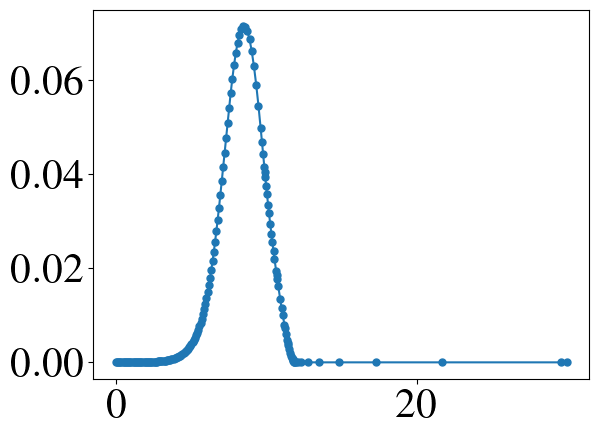

In [67]:
# plt.plot(t_vals_ssn * fault.Tscale / fault.second, np.mean(y_vals_ssn[:,:N_DOFS],axis=1) * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title('Velocity vs Time (SSN)')
# # plt.legend()
# plt.grid()
# plt.show()

# plt.plot(t_vals_ssn * fault.Tscale / fault.second,y_vals_ssn[:,:N_DOFS] * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Timemarkert# .ylabel('Velocity (m/s)')
plt# .title('Velocity vs Time (SSN)')
# p# lt.legend()
plt# .grid()
plt# .show()
t_scaled = t_vals_ssn * fault.Tscale / fault.second
mean_vel = np.mean(y_vals_ssn[:, :N_DOFS], axis=1) * fault.Vscale

plt.plot(t_scaled, mean_vel, linestyle='-', color='C0', label='Velocity (ssn)')
plt.scatter(t_scaled, mean_vel, color='C0', s=25)  # one marker per time point

In [68]:
t_vals_ssn[-1] * fault.Tscale / fault.second

np.float64(30.0)

np.float64(30.0)

In [69]:
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# print(v_max)
# # print(0.07/fault.Vscale)

In [70]:
import numpy as np
# # alpha_reference = 2.0  # legacy default retained for reference
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# # print(v_max)


import numpy as np

def build_reward_fn(alpha_value: float):
    """
    Build a reward function parameterized by alpha_value.

    alpha_value controls how harshly we punish numerical error via A = exp(-alpha*E).
    Larger alpha_value => more accuracy-obsessed agent.
    """

    alpha_value = float(alpha_value)

    def my_reward_fn(solver_perf, dt_attempt, xk, env):
        # solver_perf layout from env.increment_env:
        # [ runtime_inc,
        #   dts,
        #   error_LO,
        #   error_lil1,
        #   error_HI,
        #   E,                # global RMS scaled error
        #   success_LO,
        #   success_lil1,
        #   success_HI,
        #   kiter_LO,
        #   iter_lil1,
        #   kiter_HI ]
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # We'll need this a few times
        dt_range = env.dt_max - env.dt_min

        # If the integrator did not advance time (reject / failure path):
        # dts will be 0.0, success flags likely False.
        if dts == 0.0:
            # Penalize requesting a too-large step that got rejected.
            # Normalize dt_attempt to [0,1] and assign negative reward.
            dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
            # Clip to be safe
            # dt_norm_attempt = float(np.clip(dt_norm_attempt, 0.0, 1.0))
            # print(f" Step rejected. dt_attempt: {dt_attempt}, dt_norm_attempt: {dt_norm_attempt}")
            return -dt_norm_attempt  # more aggressive ask that failed => more negative

        # Otherwise: this step was accepted and advanced time by dts.

        # -----------------
        # S1: step size score
        # -----------------
        # We reward taking a large *accepted* step.
        dt_norm = (dts - env.dt_min) / dt_range
        S1 = float(np.clip(dt_norm, 0.0, 1.0))

        # -----------------
        # S2: runtime score
        # -----------------
        # Track per-step runtime and update the running maximum to normalize S2 dynamically
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))

        # Maintain a running max runtime seen so far
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        # track min as well as max
        if not hasattr(env, 'min_runtime_seen'):
            env.min_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc < env.min_runtime_seen:
                env.min_runtime_seen = float(runtime_inc)
        # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
        rt_min =  float(env.min_runtime_seen)
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom

        A = float(np.exp(-alpha_value * E))
        # print(f" S1: {S1}, S2: {S2},  A: {A}")
        # Final reward
        reward = S1 * S2 * A
        return reward

    return my_reward_fn



def build_obs_fn(alpha_value: float):
    """
    Factory that returns an observation function using the SAME alpha as the reward.
    This keeps reward shaping and observation aligned.

    The returned function will be called as:
        obs_fn(dt_attempt, converged, xk, solver_perf, fk, env)

    Where:
      - dt_attempt: the candidate step the agent just asked for (float or None at reset)
      - converged: 1 if the accepted high-accuracy solve succeeded, else 0 (None at reset)
      - xk: current state vector after the env step (or initial state at reset)
      - solver_perf: list of solver diagnostics from env.increment_env(...) (None at reset)
      - fk: current residual (not used here, but passed in by env)
      - env: the AdaptiveStepperEnv instance
    """
    alpha_value = float(alpha_value)

    def my_obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None, "env must be provided by AdaptiveStepperEnv"

        # ------------------------------------------------------------------
        # 1. Extract physics state features from xk
        # ------------------------------------------------------------------
        n = N_DOFS  # assuming N_DOFS is defined in outer scope
        v = xk[:n]          # velocities / slip rates
        u = xk[n:2*n]       # displacements / slips

        avg_v = float(np.mean(v))

        # Internal elastic energy 0.5 * u^T K u
        ks_u = KS @ u       # KS must be defined in outer scope
        E_int = 0.5 * float(np.dot(u, ks_u))

        # Normalize internal energy by Uintc (critical energy), if available and >0
        try:
            if Uintc > 0.0:
                E_norm = float(E_int / Uintc)
            else:
                E_norm = float(E_int)
        except NameError:
            # Fallback if Uintc isn't in scope
            E_norm = float(E_int)

        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0
        # ------------------------------------------------------------------
        # 2. Reset branch (env.reset calls us with dt_attempt=None, solver_perf=None)
        # ------------------------------------------------------------------
        if dt_attempt is None or solver_perf is None:
            # We still return a valid 6-D observation vector.
            # Fill in placeholders for solver-derived quantities.
            dt_norm_default = 0.5  # neutral midpoint in [0,1]
            conv_flag = 0.0 if converged is None else float(converged)

            return np.array([
                E_norm,                # elastic energy normalized
                avg_v / (0.07/fault.Vscale),         # avg slip rate normalized (v_max provided externally)
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag,             # "converged" flag at reset (0 or None -> 0)
                0.0,                   # exp(-alpha * 0) = 1.0 as a neutral accuracy proxy
                conv_flag_bipolar * dt_norm_default,       # normalized dt ~ mid
            ], dtype=np.float64)

        # ------------------------------------------------------------------
        # 3. Normal step branch: unpack solver_perf
        # ------------------------------------------------------------------
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E_global,        # global RMS scaled error (Richardson)
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # ------------------------------------------------------------------
        # 4. Normalize dt_attempt into [0,1]
        # ------------------------------------------------------------------
        dt_range = env.dt_max - env.dt_min
        if dt_range <= 0.0:
            dt_norm = 0.0
        else:
            dt_norm = (dt_attempt - env.dt_min) / dt_range
            dt_norm = float(np.clip(dt_norm, 0.0, 1.0))

        # ------------------------------------------------------------------
        # 5. Accuracy proxy, aligned with reward shaping
        # ------------------------------------------------------------------
        # 6. Convergence flag
        # ------------------------------------------------------------------
        # env.step sets converged = 1 if dts > 0 else 0 before calling obs_fn.
        conv_flag = float(converged) if converged is not None else 0.0
        if conv_flag:
            acc = 1/(1 + E_global)
        else:
            # print(f"Not converged step detected in obs_fn.")
            acc = 0.0

        # print(f"E_norm: {E_norm}, avg_v/v_max: {avg_v / v_max}, iter_error: {(env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0}, conv_flag: {conv_flag}, acc: {acc}, dt_norm: {dt_norm}")
        # ------------------------------------------------------------------
        # 7. Assemble observation vector
        # ------------------------------------------------------------------
        print(f"observed step {conv_flag_bipolar*dt_norm}")
        return np.array([
            E_norm,                        # normalized elastic energy
            avg_v / (0.07/fault.Vscale),                 # normalized average slip rate
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag,                     # 1 if high-accuracy solve accepted, else 0
            acc,                   # exp(-alpha * error), same shaping as reward
            conv_flag_bipolar *dt_norm,                       # normalized proposed dt in [0,1]
        ], dtype=np.float64)

    return my_obs_fn


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(
        self,
        Vscale=1.0,
        Dscale=1.0,
        Tscale=1.0,
        update_freq=50,
        offset_increment=10.0,
        num_envs=1,
        verbose=0,
    ):
        """
        Live training monitor for SB3 in Jupyter.

        Panels per env:
          (0) step-by-step reward trace, with green vertical lines at episode ends
          (1) per-episode return
          (2) avg_v (green, left y) and avg_u (blue, right y) vs physical time t_k1,
              zoomed to last ~2-3 episodes
          (3) steps_per_episode (here we record Sim_time at episode end)

        Vscale, Dscale, Tscale are just multiplicative scalars in case your units
        are nondimensional internally and you want to rescale for plotting.
        """
        super().__init__(verbose)
        self.update_freq = int(update_freq)
        self.offset_increment = float(offset_increment)

        self.Vscale = float(Vscale)  # scales avg_v
        self.Dscale = float(Dscale)  # scales avg_u
        self.Tscale = float(Tscale)  # not currently used in plot, reserved

        # will get overwritten in _init_callback
        self.num_envs = int(num_envs)

        # buffers (will be resized in _init_callback)
        self.rewards = None
        self.episode_rewards = None
        self.current_episode_rewards = None

        self.avg_v_values = None
        self.avg_u_values = None
        self.t_k1_values = None

        self.steps = None
        self.episodes = None
        self.episode_end_steps = None
        self.episode_end_indices = None
        self.current_offsets = None
        self.steps_per_episode = None

        self.fig = None
        self.axs = None     # shape [num_envs][4]
        self.axs2 = None    # list of twin y-axes, len = num_envs

    def _init_callback(self) -> None:
        """Called by SB3 at the beginning of .learn()."""
        # detect actual number of envs from VecEnv
        self.num_envs = getattr(self.training_env, "num_envs", 1)

        # allocate buffers for each env
        self.rewards = [[] for _ in range(self.num_envs)]               # step-wise reward
        self.episode_rewards = [[] for _ in range(self.num_envs)]       # per-episode return
        self.current_episode_rewards = [0.0] * self.num_envs            # running sum this ep

        self.avg_v_values = [[] for _ in range(self.num_envs)]          # avg_v trace
        self.avg_u_values = [[] for _ in range(self.num_envs)]          # avg_u trace
        self.t_k1_values  = [[] for _ in range(self.num_envs)]          # physical time trace (offset per ep)

        self.steps = [0] * self.num_envs
        self.episodes = [0] * self.num_envs

        self.episode_end_steps   = [[] for _ in range(self.num_envs)]   # x-locations of ep ends in panel 0
        self.episode_end_indices = [[] for _ in range(self.num_envs)]   # indices for trimming panel 2
        self.current_offsets     = [0.0] * self.num_envs                # time offset added after each ep
        self.steps_per_episode   = [[] for _ in range(self.num_envs)]   # store Sim_time snapshot at ep end

        # set up figure
        self.fig, self.axs = plt.subplots(self.num_envs, 4, figsize=(25, 5 * self.num_envs))
        if self.num_envs == 1:
            # normalize shape so we can always index axs[i][col]
            self.axs = [self.axs]

        # make twin y-axes for avg_u in panel (2)
        self.axs2 = []
        for i in range(self.num_envs):
            # panel 0: reward vs steps
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")

            # panel 1: per-episode return
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # panel 2: avg_v / avg_u vs t_k1
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # panel 3: steps_per_episode
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

            ax2 = self.axs[i][2].twinx()
            ax2.set_ylabel("avg_u", color="b")
            ax2.tick_params(axis="y", labelcolor="b")
            self.axs2.append(ax2)

        display(self.fig)

    def _on_step(self) -> bool:
        """
        Called by SB3 every environment step (actually every rollout collection step).

        We read self.locals["rewards"], self.locals["dones"], self.locals["infos"].
        With VecEnv:
            rewards -> np.array shape (n_envs,)
            dones   -> np.array shape (n_envs,)
            infos   -> list[dict] length n_envs
        With single env:
            they can be scalars/dicts; we wrap them to lists.
        """
        rewards = self.locals["rewards"]
        dones   = self.locals["dones"]
        infos   = self.locals["infos"]

        # unify shape for num_envs==1
        if self.num_envs == 1 and not isinstance(rewards, (list, tuple, np.ndarray)):
            rewards = [rewards]
            dones   = [dones]
            infos   = [infos]

        for i in range(self.num_envs):
            r_i = float(rewards[i])
            self.rewards[i].append(r_i)
            self.current_episode_rewards[i] += r_i
            self.steps[i] += 1

            info_i = infos[i]


            xk = info_i.get("xk", None)
            if xk is not None:
                n = N_DOFS
                v = xk[:n]* self.Vscale
                u = xk[n:2*n]* self.Dscale
            #     mean_vel.append(float(np.mean(v)))
            # mean_slip.append(float(np.mean(u)))

            # # pull diagnostics from env.info
            # # we scaled in env.step(), now we optionally rescale for plotting
            # avg_v_i  = float(info_i.get("avg_v", 0.0)) * self.Vscale
            # avg_u_i  = float(info_i.get("avg_u", 0.0)) * self.Dscale
            t_k1_i   = float(info_i.get("t_k1", 0.0))
            sim_time = float(info_i.get("Sim_time", 0.0))

            # append traces
            self.avg_v_values[i].append(float(np.mean(v)))
            self.avg_u_values[i].append(float(np.mean(u)))
            # add offset to make t_k1 increase monotonically across episodes
            self.t_k1_values[i].append(t_k1_i + self.current_offsets[i])

            # handle episode boundary
            if dones[i]:
                # store episode return
                self.episode_rewards[i].append(self.current_episode_rewards[i])
                # mark step index where this episode ended
                self.episode_end_steps[i].append(len(self.rewards[i]))
                # mark index in avg_v_values so we can "zoom to last 2-3 episodes"
                self.episode_end_indices[i].append(len(self.avg_v_values[i]))

                # snapshot "steps per episode" panel: we're using sim_time here
                self.steps_per_episode[i].append(sim_time)

                # reset accumulators for next ep
                self.current_episode_rewards[i] = 0.0
                self.episodes[i] += 1
                self.steps[i] = 0

                # bump offset so next episode's t_k1 timeline is shifted forward
                if self.t_k1_values[i]:
                    last_t = self.t_k1_values[i][-1]
                    self.current_offsets[i] = last_t + self.offset_increment

        # redraw occasionally
        total_steps_all_envs = sum(self.steps)
        if (total_steps_all_envs % self.update_freq) == 0:
            self._update_plot()

        return True

    def _update_plot(self):
        """Refresh the 4-panel figure for each env."""
        for i in range(self.num_envs):
            # clear each panel
            self.axs[i][0].cla()
            self.axs[i][1].cla()
            self.axs[i][2].cla()
            self.axs2[i].cla()
            self.axs[i][3].cla()

            # (0) reward per step, with episode boundaries
            self.axs[i][0].plot(self.rewards[i], "b-")
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")
            for step_idx in self.episode_end_steps[i]:
                self.axs[i][0].axvline(x=step_idx, color="g", linestyle="--")

            # (1) episode return
            if len(self.episode_rewards[i]) > 1:
                self.axs[i][1].plot(
                    self.episode_rewards[i][1:],
                    color="r",
                    marker="o",
                    linestyle="-",
                )
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # choose window for panel (2): last ~2-3 episodes
            if len(self.episode_end_indices[i]) >= 3:
                start_index = self.episode_end_indices[i][-3]
            elif len(self.episode_end_indices[i]) == 2:
                start_index = self.episode_end_indices[i][-2]
            else:
                start_index = 0
            end_index = len(self.avg_v_values[i])

            # (2) avg_v vs physical time
            self.axs[i][2].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_v_values[i][start_index:end_index],
                color="g",
                marker="o",
                linestyle="-",
                label="avg_v",
            )
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # (2 twin) avg_u vs physical time
            self.axs2[i].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_u_values[i][start_index:end_index],
                color="b",
                marker="x",
                linestyle="--",
                label="avg_u",
            )
            self.axs2[i].set_ylabel("avg_u", color="b")
            self.axs2[i].tick_params(axis="y", labelcolor="b")

            # combined legend
            lines_1, labels_1 = self.axs[i][2].get_legend_handles_labels()
            lines_2, labels_2 = self.axs2[i].get_legend_handles_labels()
            self.axs[i][2].legend(
                lines_1 + lines_2,
                labels_1 + labels_2,
                loc="upper left",
            )

            # (3) steps_per_episode (we're storing Sim_time snapshots)
            if len(self.steps_per_episode[i]) > 1:
                self.axs[i][3].plot(self.steps_per_episode[i][1:], "b-")
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

        clear_output(wait=True)
        display(self.fig)


In [72]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod, Trapezoidal
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from Solve_IVP_NS.rl.callbacks import CustomMetricsCallback
from gymnasium import spaces
from pathlib import Path
import json
from copy import deepcopy

from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


# Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]
component_slices_solver = [slice(0, 3 * N_DOFS)]  # solver works on full state vector
# For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
rhok = np.ones(N_DOFS, dtype=float)

# Create the projection operator
projection = CoulombProjection(
    con_force_func=con_force,
    rhok=rhok,
    component_slices=component_slices,
    constraint_indices=np.arange(N_DOFS, dtype=np.int32),
    # use_numba=True,  # use Numba acceleration
    # jac_func=con_force_jacobian,  # analytical Jacobian for CoulombProjection
)

# Configure the implicit solver
solver_mp = ImplicitEquationSolver(
    method='VI',
    proj=projection,
    component_slices=component_slices,
    tol=solver_opts_ssn.get('tol', 1e-6),
    max_iter=solver_opts_ssn.get('max_iter', 100),
    vi_strict_block_lipschitz=solver_opts_ssn.get("vi_strict_block_lipschitz", False),
    vi_max_block_adjust_iters=solver_opts_ssn.get("vi_max_block_adjust_iters", 10),
)
solver_mp.rhs_jacobian = rhs_jac  # expose analytical RHS Jacobian to integrators

# Use the composite method (which calls the solver internally)
method_mp = CompositeMethod(solver=solver_mp, A=A)



# --- Adaptive RL training over an alpha sweep ---
# Here we iterate over a list of alpha values, train a policy for each,
# and persist the resulting models, normalization stats, and metadata
# into per-alpha subdirectories for easy organization.
dt0 = 1e-3
t0 = t_span[0]
tnmax = t_span[1]
dt_min = 1e-7  # * fault.second / fault.Tscale
dt_max = 30 / 5 * fault.second / fault.Tscale
nparams = (1e-6, 100)

# Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
obs_dim = 6
obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

alpha_grid = [0.5, 1.0, 2.0, 4.0, 16.0, 32.0, 128.0]  # customize as desired
# alpha_grid = [8.0]  # customize as desired

total_timesteps = 20_000
RUN_ROOT = Path("rl_runs")
RUN_ROOT.mkdir(parents=True, exist_ok=True)

def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

_base_policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64], n_critics=5)
)



In [73]:
reward_callback = RewardCallback(num_envs=1,Vscale = fault.Vscale, Dscale = fault.Dscale, Tscale = fault.Tscale/fault.second, update_freq=100)




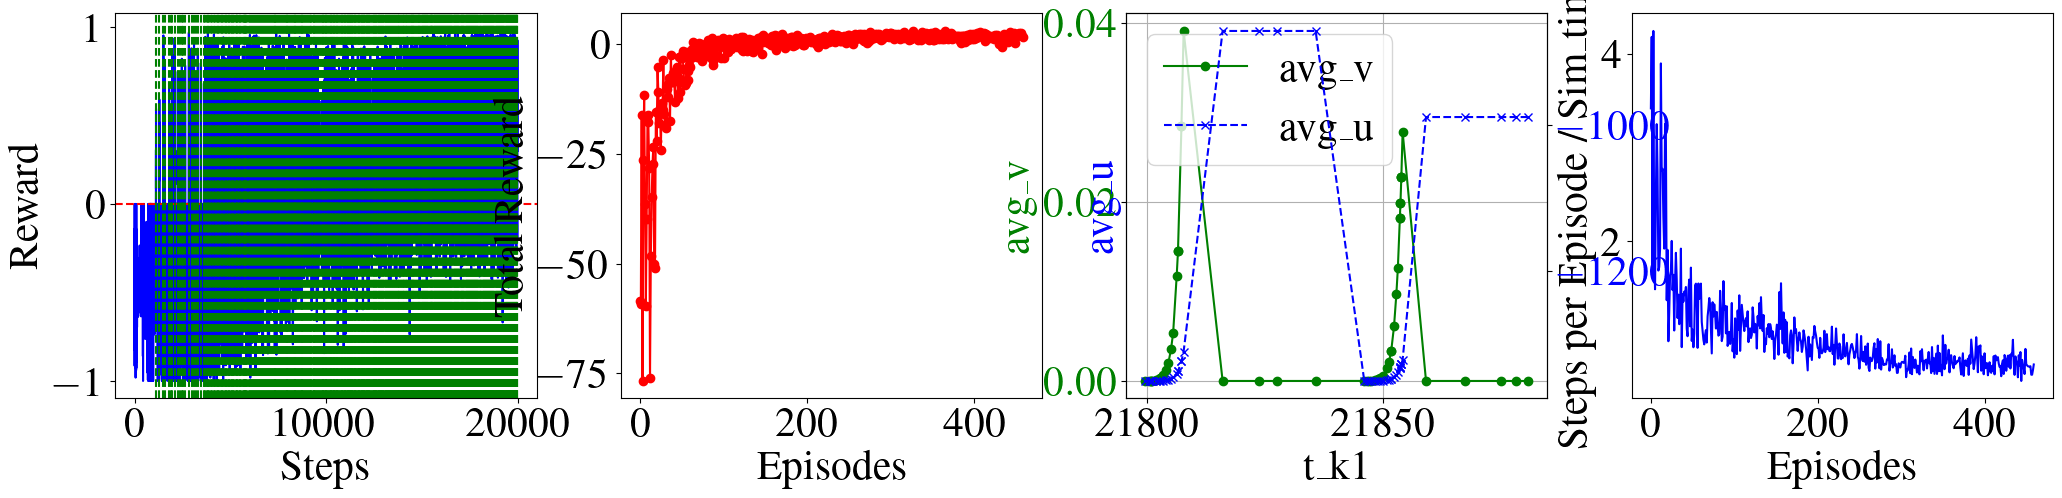

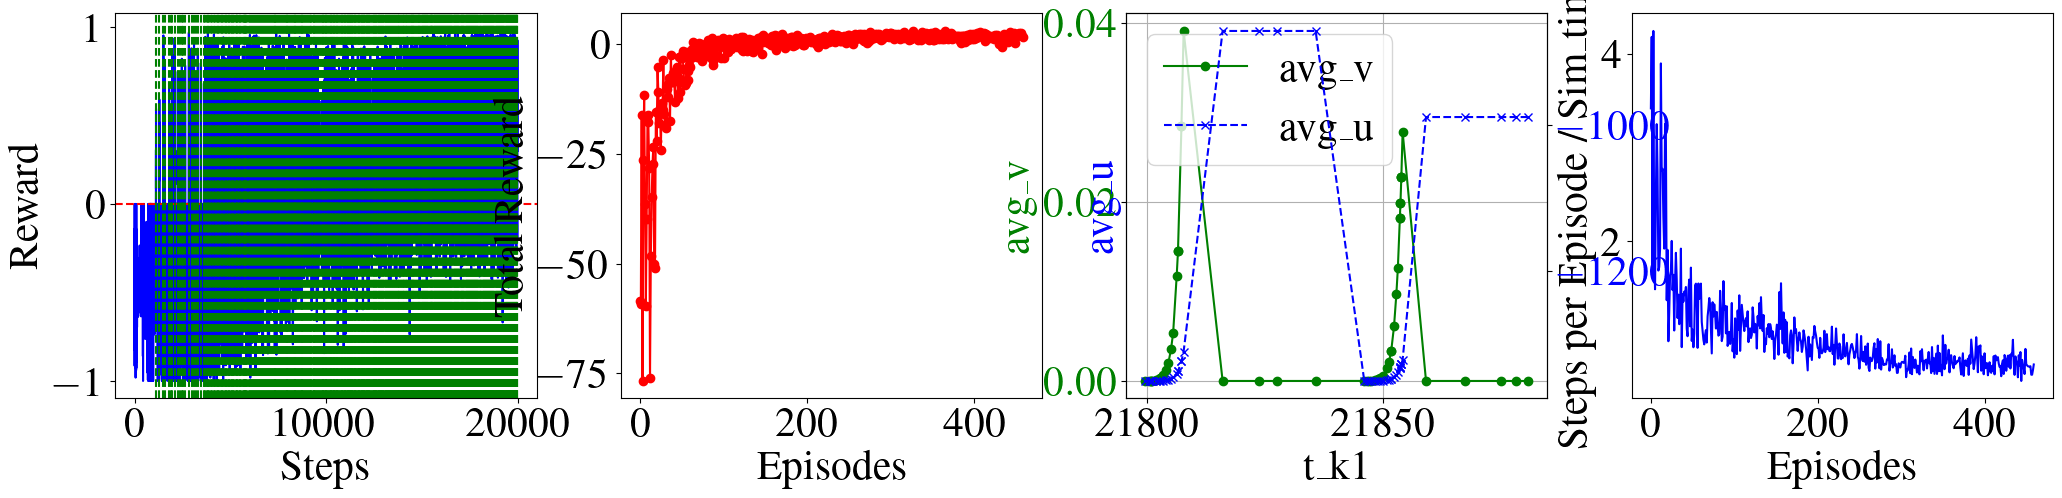

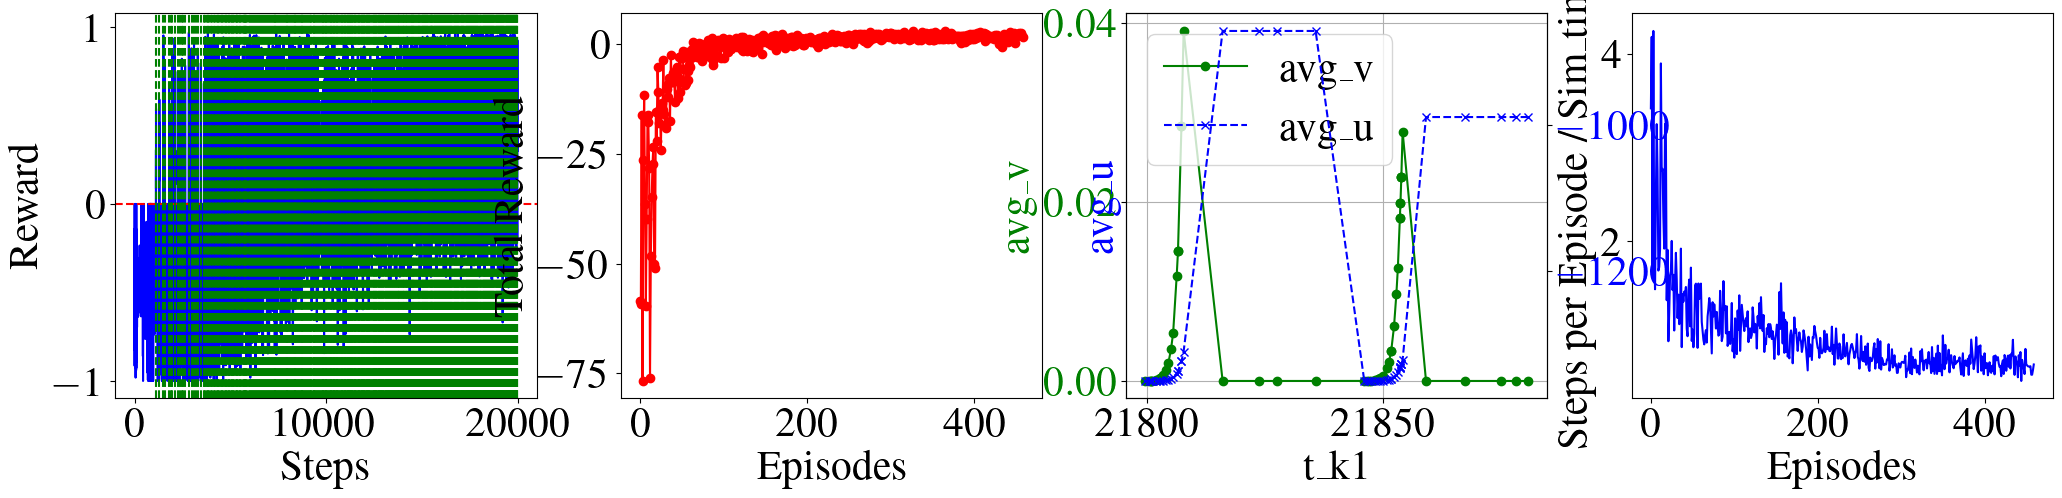

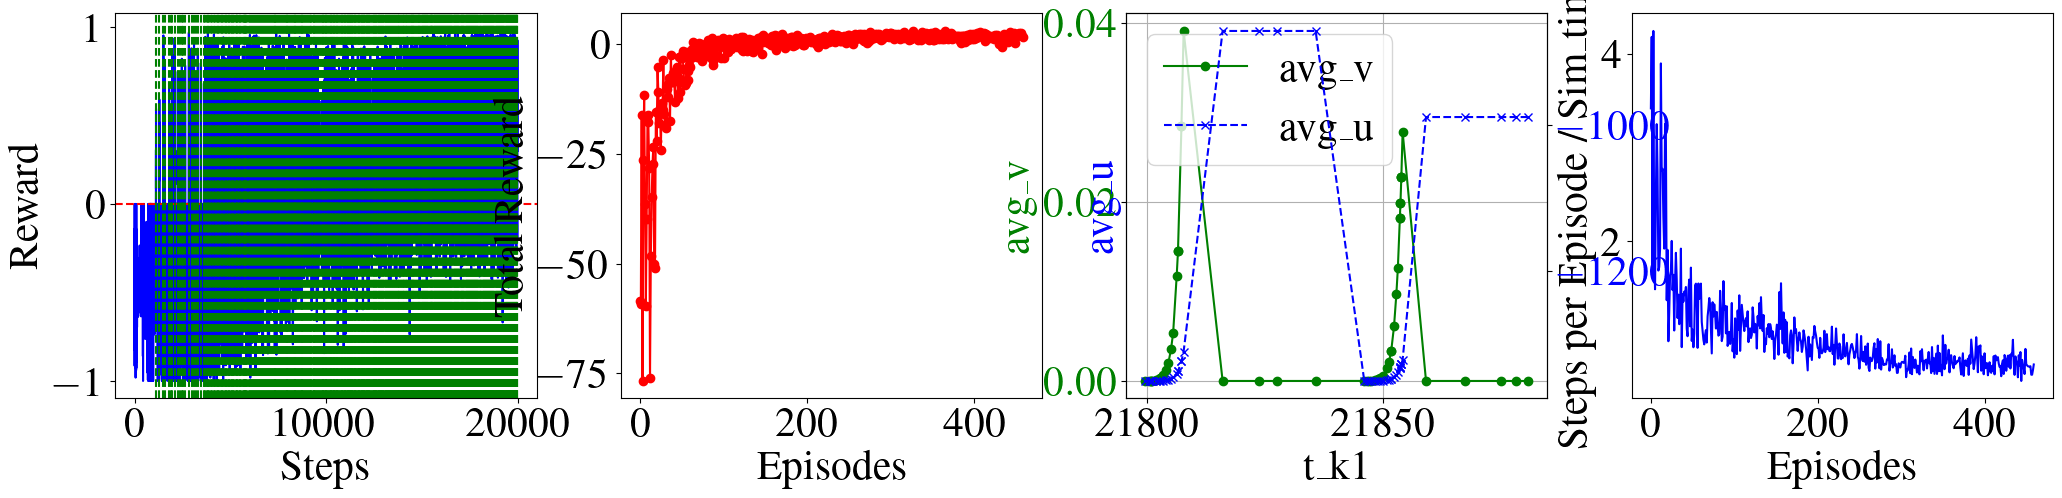

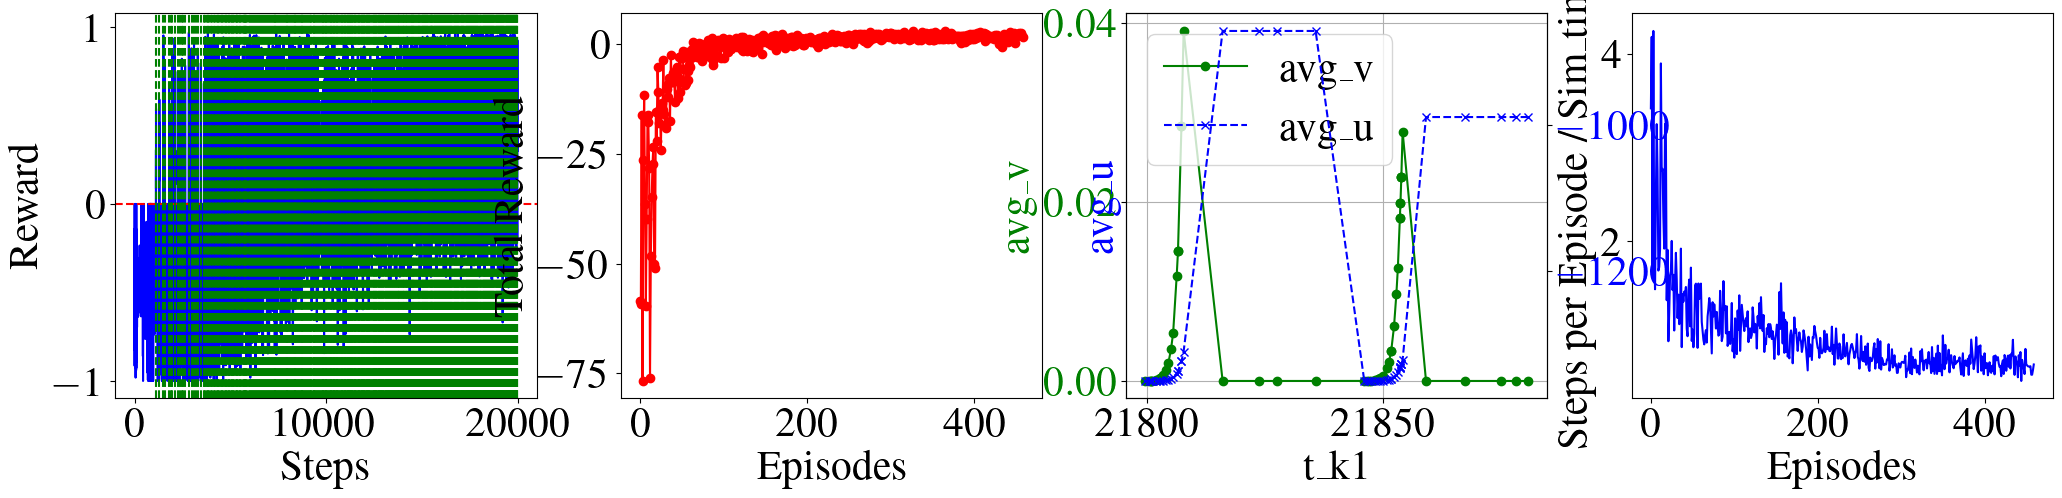

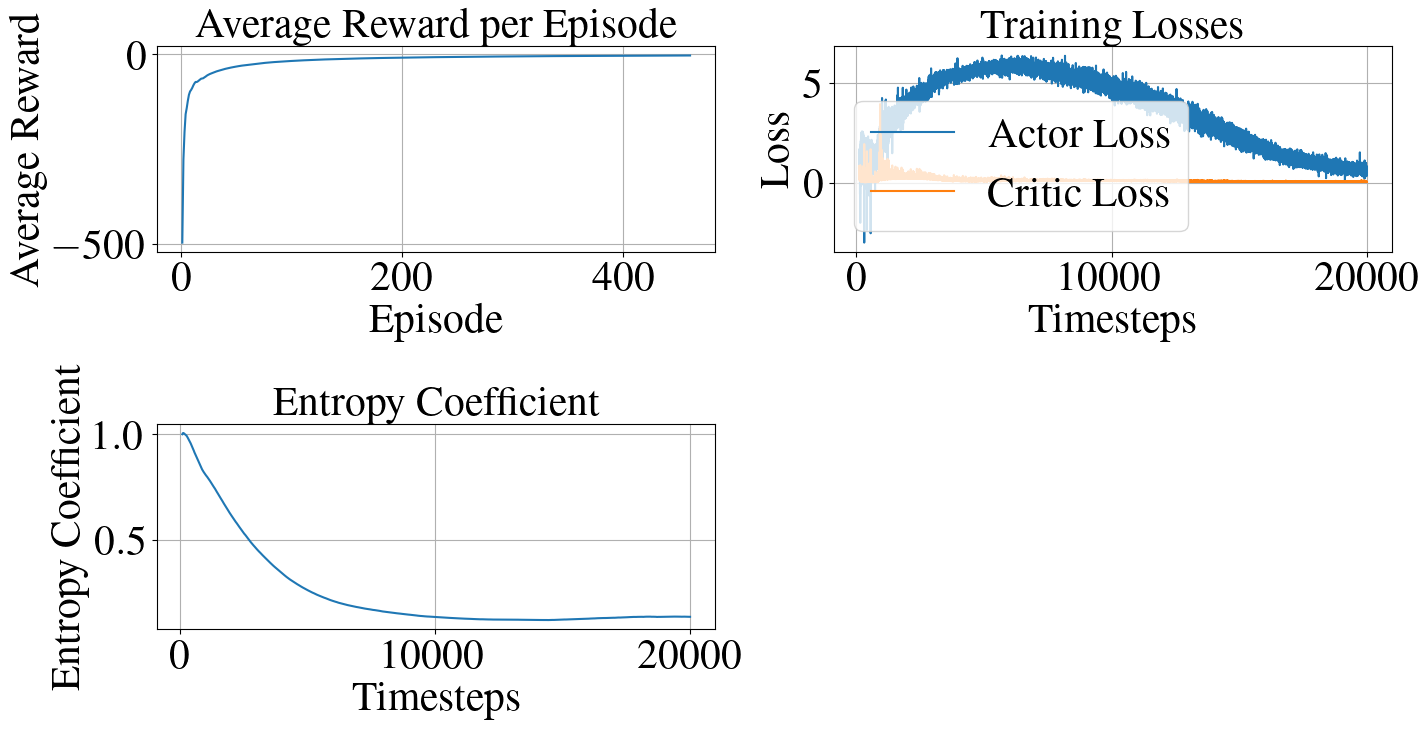

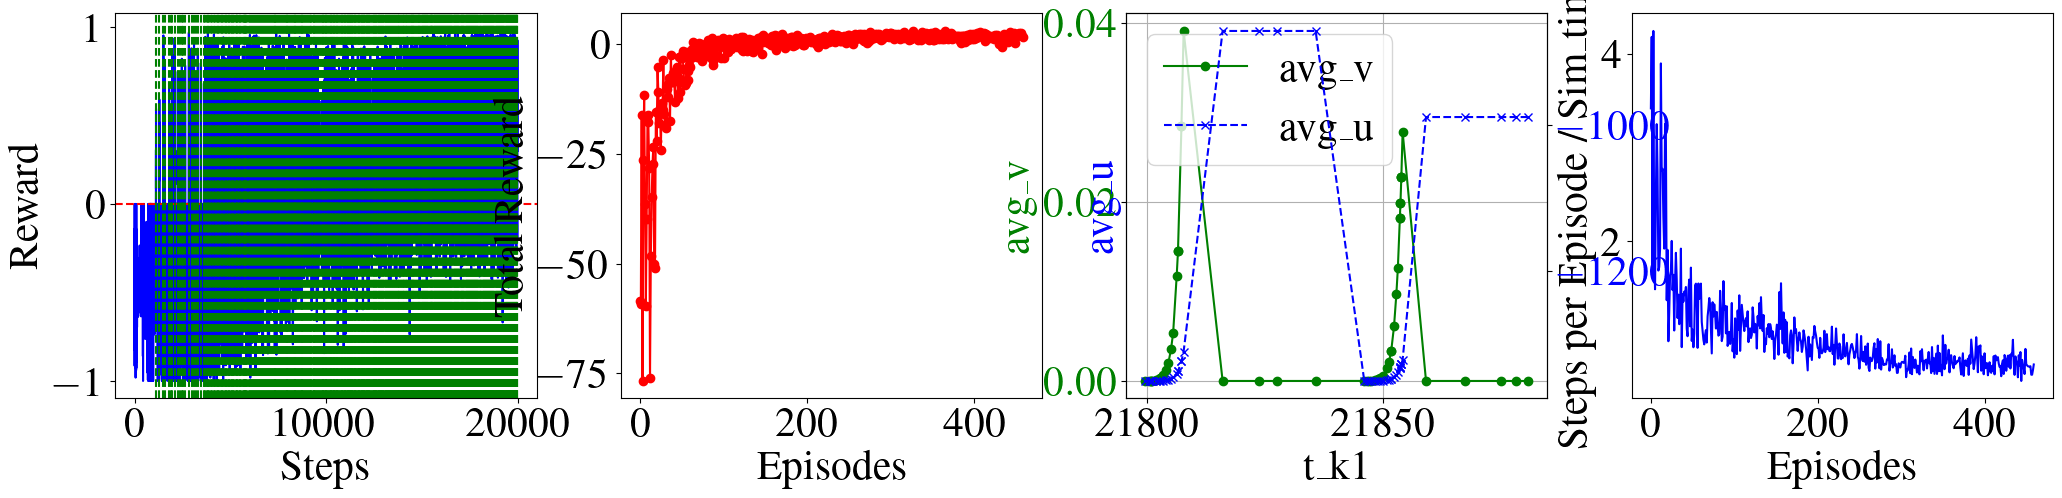

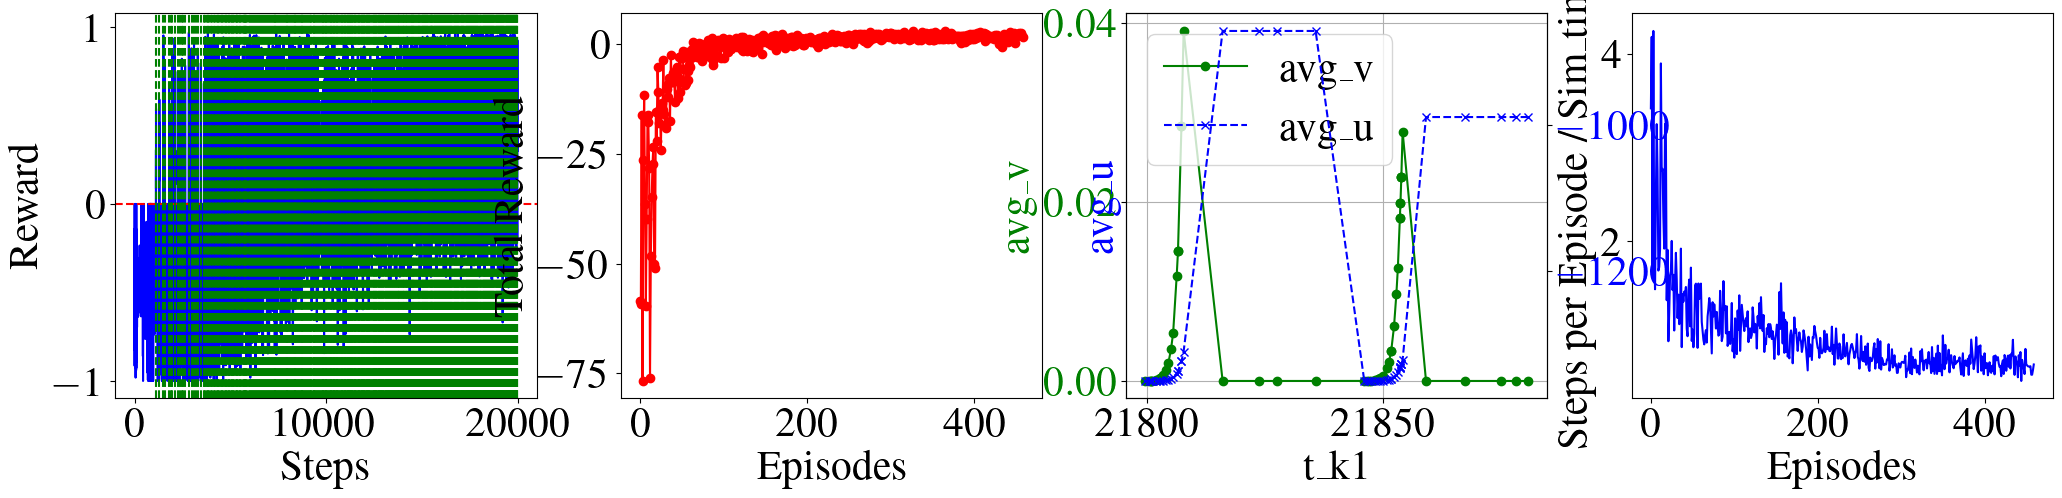

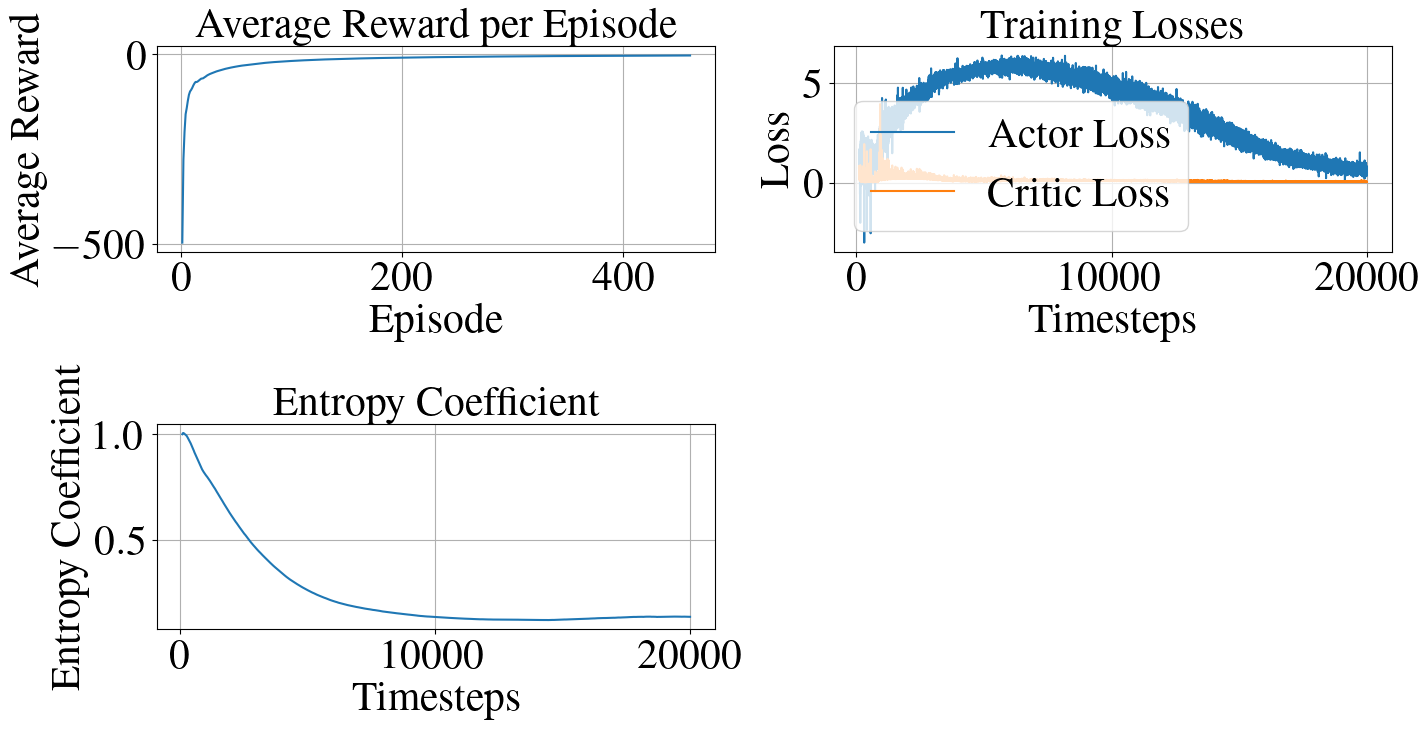

TQC training time: 743.15 seconds
Completed alpha sweep training. Models stored in: rl_runs


In [55]:
def _policy_kwargs():
    return dict(_base_policy_kwargs)

def _build_tqc(vec_env):
    return TQC(
        "MlpPolicy",
        vec_env,
        batch_size=256,
        use_sde=True,
        verbose=0,
        policy_kwargs=_policy_kwargs())

def _build_td3(vec_env):
    # The noise objects for TD3
    n_actions = vec_env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    return TD3(
        "MlpPolicy",
        vec_env,
        batch_size=256,
        verbose=0,
        action_noise=action_noise,
        policy_kwargs=_policy_kwargs())

algorithms = {
    # "TQC": dict(builder=_build_tqc),
    "TD3": dict(builder=_build_td3),
}

for alpha_value in alpha_grid:
    print("=" * 60)
    print(f"Preparing training runs with alpha = {alpha_value}")
    alpha_dir = RUN_ROOT / f"alpha_{_alpha_label(alpha_value)}"
    alpha_dir.mkdir(parents=True, exist_ok=True)

    reward_fn = build_reward_fn(alpha_value)
    obs_fn = build_obs_fn(alpha_value)

    def make_env():
        return AdaptiveStepperEnv(
            system=rhs,
            dt0=dt0,
            t0=t0,
            x0=y0,
            tnmax=tnmax,
            dt_min=dt_min,
            dt_max=dt_max,
            nparams=nparams,
            integrator=method_mp,
            component_slices=component_slices,
            reward_fn=reward_fn,
            obs_fn=obs_fn,
            obs_space=obs_space,
            verbose=False,
            # atol=1e-9,
            # rtol=1e-6,
            alpha=alpha_value,  # ensure env.alpha matches this run's alpha
)

    for algo_name, algo_cfg in algorithms.items():
        print("-" * 60)
        print(f"Training {algo_name} adaptive controller with alpha = {alpha_value}")
        vec_env = DummyVecEnv([make_env])
        vec_env = VecNormalize(vec_env, norm_obs=False, norm_reward=False)
        model = algo_cfg["builder"](vec_env)

        metrics_callback = CustomMetricsCallback()
        start_time = time.time()
        # model.learn(total_timesteps=total_timesteps)
        model.learn(total_timesteps=total_timesteps, callback=[reward_callback, metrics_callback])
        # model.learn(total_timesteps=total_timesteps, callback=[metrics_callback])
        elapsed = time.time() - start_time
        print(f"{algo_name} training time: {elapsed:.2f} seconds")

        run_dir = alpha_dir / algo_name
        run_dir.mkdir(parents=True, exist_ok=True)
        model_path = run_dir / "model"
        vecnorm_path = run_dir / "vec_norm.pkl"
        meta_path = run_dir / "metadata.json"
        model.save(str(model_path))
        vec_env.save(str(vecnorm_path))

        meta = {
            "alpha": alpha_value,
            "algorithm": algo_name,
            "total_timesteps": total_timesteps,
            "training_wall_time_sec": elapsed,
            "model_path": str(model_path.with_suffix('.zip')),
            "vecnorm_path": str(vecnorm_path),
        }
        with open(meta_path, "w", encoding="utf-8") as fh:
            json.dump(meta, fh, indent=2)

        vec_env.close()
        del vec_env, model

print("Completed alpha sweep training. Models stored in:", RUN_ROOT)

## Evaluation: roll out each trained alpha and compare to adaptive integrator

This section loads each trained RL policy from `rl_runs/alpha_*`, runs a rollout on the same fault setup, and plots:
- Average velocity over DOFs vs. time
- Average slip over DOFs vs. time
It also adds the adaptive integrator baseline computed earlier and builds a small runtime table.

Notes:
- No training happens here; we only load saved artifacts.
- We assume models were saved by the training cell into `rl_runs/alpha_<label>/model(.zip)` with optional `vec_norm.pkl`.
- Observation normalization is the same as training (your `my_obs_fn`) and uses per-discretization scalars already defined above.

In [74]:
# from pathlib import Path
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from sb3_contrib import TQC
# from stable_baselines3 import TD3
# import time
# try:
#     import pandas as pd
#     from IPython.display import display
#     _HAVE_PANDAS = True
# except Exception:
#     _HAVE_PANDAS = False

# adaptive_opts = dict(
#     h0=5e-3,
#     h_min=1e-7,
#     h_down=0.6,
#     h_up=1.8,
#     method_order=1,        # p = 1 → nonsmooth first-order scheme, so k = p+1 = 2
#     controller="H211b",   # <--- THIS picks the PI digital filter variant to test
#     b_param=4.0,         # only if controller == "H211b"
#     skip_error_indices=[],
# )


# # Utility: format alpha subfolder names identical to training
# def _alpha_label(alpha_value: float) -> str:
#     sign = "m" if alpha_value < 0 else ""
#     magnitude = str(abs(alpha_value)).replace(".", "p")
#     return f"{sign}{magnitude}"

# RUN_ROOT = Path("rl_runs").resolve()

# ALGO_REGISTRY = {
#     "TQC": TQC,
#     # "TD3": TD3,
# }

# # Discover trained runs from disk (alpha_* folders)
# alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
# if not alpha_dirs:
#     raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}. Expected folders like alpha_1p0/TQC, alpha_10p0/TD3, ...")
# dt0 = 1e-3
# # Helper to rebuild the same environment used for training
# def make_eval_env(reward_fn, obs_fn, alpha_value: float):
#     return AdaptiveStepperEnv(
#         system=rhs,
#         dt0=dt0,
#         t0=0.0,
#         x0=y0,
#         tnmax=tnmax,
#         dt_min=dt_min,
#         dt_max=dt_max,
#         nparams=nparams,
#         integrator=method_mp,
#         component_slices=component_slices,
#         reward_fn=reward_fn,  # not used in deterministic rollout, but env expects it
#         obs_fn=obs_fn,
#         obs_space=obs_space,
#         verbose=False,
#         # atol=1e-8,
#         # rtol=1e-6,
#         alpha=alpha_value,   # ensure env.alpha is set (for completeness)
# )

# def rollout_policy_on_env(model, env, run_name="(unnamed)"):
#     obs, info = env.reset()
#     times = []
#     mean_vel = []
#     mean_slip = []
#     start = time.time()
#     done = False
#     term = False
#     # Repeated-time guard
#     last_t = None
#     repeat_count = 0
#     broke_stuck = False
#     last_converged = None
#     while not (done or term):
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, term, info = env.step(action)
#         t_now = info.get("t_k1", np.nan)
#         # Track last converged flag if provided by env
#         if isinstance(info, dict) and ("converged" in info):
#             last_converged = info.get("converged")
#         # Check for repeated time values to avoid infinite loops
#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
#                 repeat_count += 1
#                 if repeat_count >= 10:
#                     print(f"[{run_name}] WARNING: Time stuck at {current_t} for 10 iterations, breaking loop")
#                     broke_stuck = True
#                     break
#             else:
#                 repeat_count = 0  # Reset counter if time advances
#             last_t = current_t
#         xk = info.get("xk", None)
#         if xk is not None:
#             n = N_DOFS
#             v = xk[:n]
#             u = xk[n:2*n]
#             times.append(float(t_now))
#             mean_vel.append(float(np.mean(v)))
#             mean_slip.append(float(np.mean(u)))
#     wall = time.time() - start

#     # Determine success: p2fer env-provided converged, else reach tnmax and not stuck
#     tnmax_val = getattr(env, 'tnmax', None)
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         if len(times) > 0 and tnmax_val is not None:
#             success = (times[-1] >= 0.999 * float(tnmax_val)) and not broke_stuck
#         else:
#             success = not broke_stuck

#     # Convert to arrays
#     return np.asarray(times), np.asarray(mean_vel), np.asarray(mean_slip), wall, success

# # Storage for plotting and table
# series = {}  # key -> dict(times, mean_v, mean_u, runtime)

# for alpha_dir in alpha_dirs:
#     algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
#     if not algo_dirs:
#         print(f"Skipping {alpha_dir.name}: no algorithm runs found")
#         continue
#     for algo_dir in algo_dirs:
#         algo_name = algo_dir.name
#         ModelClass = ALGO_REGISTRY.get(algo_name)
#         if ModelClass is None:
#             print(f"Skipping {algo_dir}: unknown algorithm '{algo_name}'")
#             continue
#         meta_path = algo_dir / "metadata.json"
#         model_path_zip = algo_dir / "model.zip"
#         model_path_plain = algo_dir / "model"

#         if not meta_path.exists():
#             print(f"Skipping {algo_dir}: missing metadata.json")
#             continue
#         with open(meta_path, "r", encoding="utf-8") as fh:
#             meta = json.load(fh)
#         alpha_value = float(meta.get("alpha", np.nan))
#         if np.isnan(alpha_value):
#             # Try to parse from parent folder name: alpha_1p0 -> 1.0
#             try:
#                 alabel = alpha_dir.name.split("alpha_")[-1]
#                 alpha_value = float(alabel.replace("p", ".").replace("m", "-"))
#             except Exception:
#                 print(f"Could not infer alpha from {alpha_dir.name}; skipping {algo_dir}")
#                 continue

#         key = f"{algo_name} alpha={alpha_value:g}"
#         print(f"Evaluating {key} from {(algo_dir.relative_to(RUN_ROOT))}...")

#         # Build reward/obs EXACTLY as training for this alpha
#         reward_fn = build_reward_fn(alpha_value)
#         obs_fn = build_obs_fn(alpha_value)
#         env = make_eval_env(reward_fn, obs_fn, alpha_value)

#         mdl_path = str(model_path_zip) if model_path_zip.exists() else str(model_path_plain)
#         if not Path(mdl_path).exists():
#             print(f"Skipping {algo_dir}: no model found at {model_path_zip} or {model_path_plain}")
#             continue
#         model = ModelClass.load(mdl_path, device="cpu")

#         # Rollout - average over 10 runs for robust runtime measurement
#         try:
#             runtimes = []
#             success_runs = []
#             for run_idx in range(1):
#                 t_arr, v_mean, u_mean, wall, success = rollout_policy_on_env(model, env, run_name=key)
#                 runtimes.append(wall)
#                 success_runs.append(bool(success))
#                 if run_idx == 0:
#                     # Store trajectory data from first run only
#                     t_arr_store = t_arr
#                     v_mean_store = v_mean
#                     u_mean_store = u_mean
#             avg_runtime = np.mean(runtimes)
#             std_runtime = np.std(runtimes)
#             any_success = any(success_runs)
#             print(f"Finished {key}: avg_wall={avg_runtime:.3f}s ± {std_runtime:.3f}s, steps={len(t_arr_store)}, t_end={(t_arr_store[-1] if len(t_arr_store)>0 else 'NA')}, converged_any={any_success}")
#             series[key] = {
#                 "times": t_arr_store,
#                 "mean_v": v_mean_store,
#                 "mean_u": u_mean_store,
#                 "runtime_s": float(avg_runtime),
#                 "runtime_std": float(std_runtime),
#                 "converged": bool(any_success),
#             }
#         except Exception as e:
#             print(f"FAILED {key}: {e}")
#             continue

# # Baseline: adaptive integrator (from earlier SSN run or re-run if needed)
# def adaptive_integrator_baseline():
#     # Use Solve_IVP_NS.solve_ivp_ns as in the earlier cell
#     # Run 10 times for consistent runtime measurement
#     runtimes_b = []
#     t_store = None
#     y_store = None
#     for run_idx in range(1):
#         try:
#             if run_idx == 0:
#                 # Use cached values for first run if available
#                 t_vals_b = t_vals_ssn
#                 y_vals_b = y_vals_ssn
#                 wall_b = rt_nb
#             else:
#                 raise NameError  # Force re-run for timing
#         except NameError:
#             start_b = time.time()
#             projection_opts_nb = dict(projection_opts)
#             projection_opts_nb['use_numba'] = True
#             (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=rhs,
#                 t_span=t_span,
#                 y0=y0,
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts_nb,
#                 solver_opts=solver_opts_ssn,
#                 adaptive=True,
#                 adaptive_opts=adaptive_opts,
#                 # atol=1e-8,
#                 # rtol=1e-6,
#                 h0=adaptive_opts['h0'],
#                 component_slices=component_slices,
#                 verbose=False,
#                 A=A,
#             )
#             wall_b = time.time() - start_b
#         runtimes_b.append(wall_b)
#         if run_idx == 0:
#             # Store trajectory from first run
#             t_store = t_vals_b
#             y_store = y_vals_b
    
#     n = N_DOFS
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)
#     avg_runtime_b = np.mean(runtimes_b)
#     std_runtime_b = np.std(runtimes_b)
#     print(f"Adaptive integrator: avg_wall={avg_runtime_b:.3f}s ± {std_runtime_b:.3f}s")
#     # Treat baseline as converged if it reaches end time
#     success_b = (len(t_store) > 0 and t_store[-1] >= 0.999 * t_span[1])
#     return t_store, v_b, u_b, avg_runtime_b, std_runtime_b, success_b

# t_b, v_b, u_b, wall_b, wall_b_std, succ_b = adaptive_integrator_baseline()
# series["adaptive_integrator"] = {
#     "times": np.asarray(t_b),
#     "mean_v": np.asarray(v_b),
#     "mean_u": np.asarray(u_b),
#     "runtime_s": float(wall_b),
#     "runtime_std": float(wall_b_std),
#     "converged": bool(succ_b),
# }

# # Plot velocity
# plt.figure(figsize=(10,6))
# for name, data in series.items():
#     t_plot = data["times"] * fault.Tscale / fault.second
#     v_plot = data["mean_v"] * fault.Vscale
#     plt.plot(t_plot, v_plot, label=name)
# plt.xlabel("Time (s)")
# plt.ylabel("Average velocity (m/s)")
# plt.title("Average velocity vs time: RL policies and adaptive integrator")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot slip
# plt.figure(figsize=(10,6))
# for name, data in series.items():
#     t_plot = data["times"] * fault.Tscale / fault.second
#     u_plot = data["mean_u"] * fault.Dscale
#     plt.plot(t_plot, u_plot, label=name)
# plt.xlabel("Time (s)")
# plt.ylabel("Average slip (m)")
# plt.title("Average slip vs time: RL policies and adaptive integrator")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot runtime vs log10(alpha) — skip non-converged entries
# from collections import defaultdict
# runtime_by_algo = defaultdict(list)
# baseline_runtime = None

# for name, data in series.items():
#     # Extract alpha from the key name (e.g., "TQC alpha=1.0")
#     if "alpha=" in name:
#         parts = name.split("alpha=")
#         algo = parts[0].strip()
#         alpha = float(parts[1])
#         if data.get("converged", True):  # only include converged runs
#             runtime = data["runtime_s"]
#             runtime_by_algo[algo].append((alpha, runtime))
#     elif "adaptive_integrator" in name:
#         if data.get("converged", True):
#             baseline_runtime = data["runtime_s"]

# if runtime_by_algo:
#     plt.figure(figsize=(10, 6))
#     for algo_name, pairs in runtime_by_algo.items():
#         if not pairs:
#             continue
#         pairs_sorted = sorted(pairs, key=lambda x: x[0])
#         alphas = [p[0] for p in pairs_sorted]
#         runtimes = [p[1] for p in pairs_sorted]
#         plt.plot(np.log10(alphas), runtimes, marker='o', label=algo_name, linewidth=2, markersize=8)
    
#     if baseline_runtime is not None:
#         plt.axhline(baseline_runtime, color='k', linestyle='--', linewidth=2, label='adaptive integrator baseline')
    
#     plt.xlabel("log10(alpha)")
#     plt.ylabel("Runtime (s)")
#     plt.title("Runtime vs log10(alpha): RL policies and adaptive integrator (converged only)")
#     plt.grid(True)
#     plt.legend()
#     plt.show()

# # Runtime table
# rows = [{"method": name, "wall_time_s": data["runtime_s"], "converged": data.get("converged", True)} for name, data in series.items()]
# if _HAVE_PANDAS:
#     df = pd.DataFrame(rows).sort_values(["converged", "wall_time_s"], ascending=[False, True]).reset_index(drop=True)
#     print("Runtime summary (seconds):")
#     display(df)
# else:
#     print("Runtime summary (seconds) — converged first:")
#     for row in sorted(rows, key=lambda r: (not r["converged"], r["wall_time_s"])):
#         tag = " (failed)" if not row["converged"] else ""
#         print(f"- {row['method']}: {row['wall_time_s']:.3f}s{tag}")

Skipping /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/rl_runs/alpha_0p5/TD3: unknown algorithm 'TD3'
Evaluating TQC alpha=0.5 from alpha_0p5/TQC...
observed step 0.1776444911956787
observed step 0.1776444911956787
observed step 0.17805606126785278
observed step 0.17805606126785278
observed step 0.17764291167259214
observed step 0.17764291167259214
observed step 0.17512807250022888
observed step 0.17512807250022888
observed step 0.16779494285583496
observed step 0.16779494285583496
observed step 0.32630506157875055
observed step -0.9820138216018677
observed step 0.32630506157875055
observed step -0.9820138216018677
observed step 0.6778357028961182
observed step 0.9816458225250244
observed step 0.9820138216018677
observed step 0.9523987770080566
observed step 0.9468365907669067
Finished TQC alpha=0.5: avg_wall=2.885s ± 0.000s, steps=11, t_end=33.230889435218714, success_rate=0.0% (0/1)
Evaluating TQC alpha=128 from alpha_128p0/TQC...
observed step 0.6778357028961182
observed s

Skipping /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/rl_runs/alpha_0p5/TD3: unknown algorithm 'TD3'
Evaluating TQC alpha=0.5 from alpha_0p5/TQC...
observed step 0.1776444911956787
observed step 0.1776444911956787
observed step 0.17805606126785278
observed step 0.17805606126785278
observed step 0.17764291167259214
observed step 0.17764291167259214
observed step 0.17512807250022888
observed step 0.17512807250022888
observed step 0.16779494285583496
observed step 0.16779494285583496
observed step 0.32630506157875055
observed step -0.9820138216018677
observed step 0.32630506157875055
observed step -0.9820138216018677
observed step 0.6778357028961182
observed step 0.9816458225250244
observed step 0.9820138216018677
observed step 0.9523987770080566
observed step 0.9468365907669067
Finished TQC alpha=0.5: avg_wall=2.885s ± 0.000s, steps=11, t_end=33.230889435218714, success_rate=0.0% (0/1)
Evaluating TQC alpha=128 from alpha_128p0/TQC...
observed step 0.6778357028961182
observed s

KeyboardInterrupt: 


Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s


Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))



Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g


Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g

/tmp/ipykernel_5980/2921130900.py:102: RuntimeWarning: overflow encountered in multiply
  out[:n] = mu_vals * SIGMA_N_l



Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g

/tmp/ipykernel_5980/2921130900.py:102: RuntimeWarning: overflow encountered in multiply
  out[:n] = mu_vals * SIGMA_N_l


  PI baseline run 0: 21.919s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json



Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g

/tmp/ipykernel_5980/2921130900.py:102: RuntimeWarning: overflow encountered in multiply
  out[:n] = mu_vals * SIGMA_N_l


  PI baseline run 0: 21.919s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json


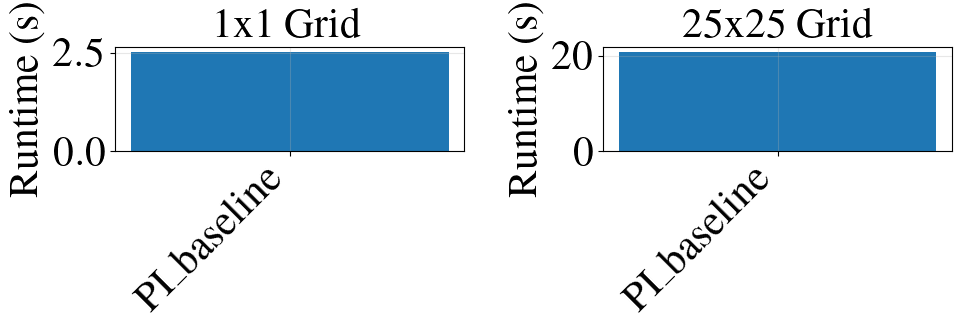


Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g

/tmp/ipykernel_5980/2921130900.py:102: RuntimeWarning: overflow encountered in multiply
  out[:n] = mu_vals * SIGMA_N_l


  PI baseline run 0: 21.919s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json


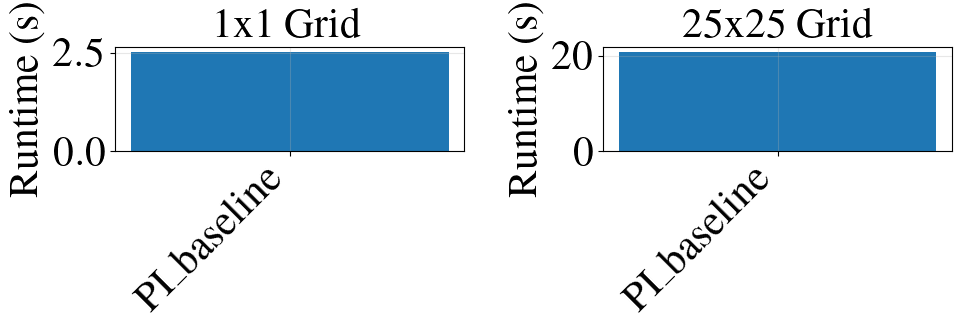

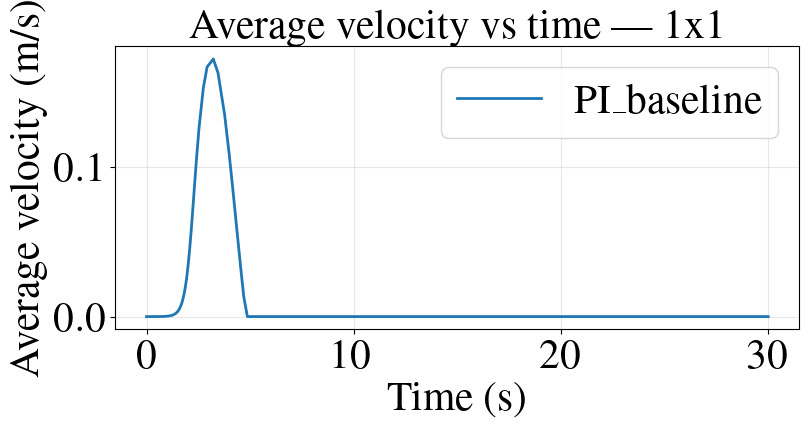


Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g

/tmp/ipykernel_5980/2921130900.py:102: RuntimeWarning: overflow encountered in multiply
  out[:n] = mu_vals * SIGMA_N_l


  PI baseline run 0: 21.919s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json


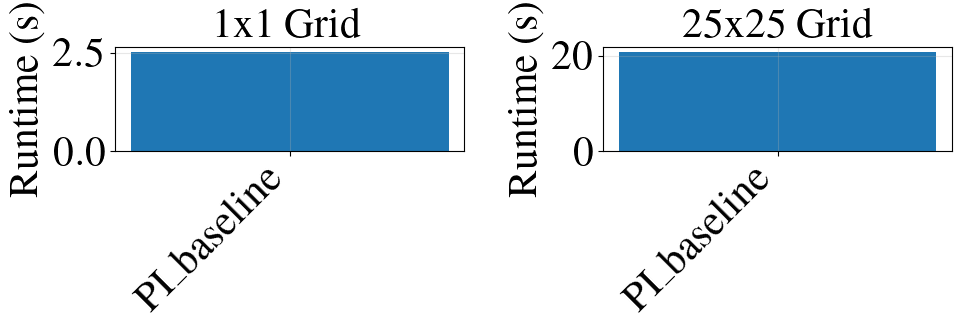

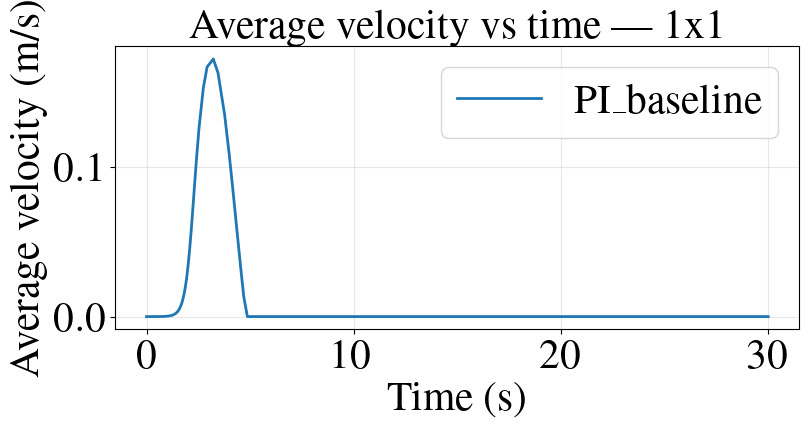

Saved: plots_velocity/velocity_vs_time_1x1.png



Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] WARNING: time stuck at 0.0
[TQC alpha=0.5 run0] Done: wall_time=0.426s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s, steps=10, final_t=0.0, s_end=0.000000e+00

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] WARNING: time stuck at 0.0
[TQC alpha=128 run0] Done: wall_time=0.435s

/tmp/ipykernel_5980/2921130900.py:100: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC))


  PI baseline run 0: 2.569s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 1: 2.485s, success=True
coulomb
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  PI baseline run 2: 2.523s, success=True
Saved results to eval_results_1x1.json

Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,g

/tmp/ipykernel_5980/2921130900.py:102: RuntimeWarning: overflow encountered in multiply
  out[:n] = mu_vals * SIGMA_N_l


  PI baseline run 0: 21.919s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 1: 19.752s, success=True
coulomb
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json
  PI baseline run 2: 20.621s, success=True
Saved results to eval_results_25x25.json


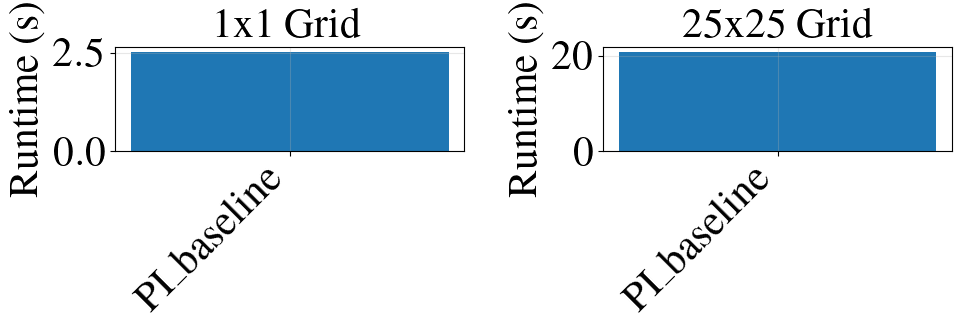

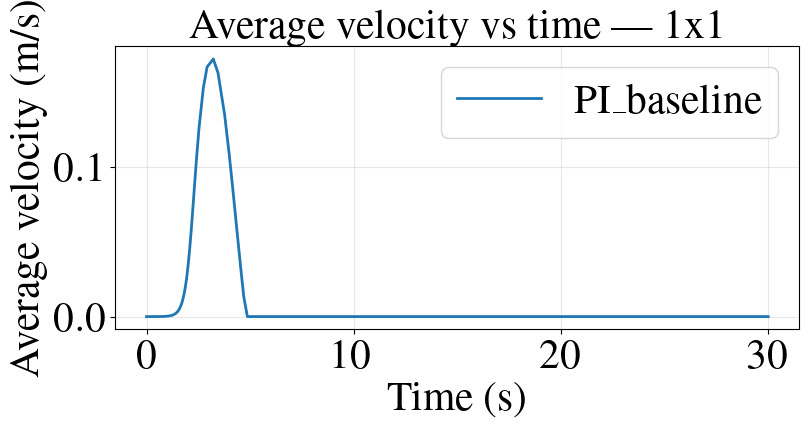

Saved: plots_velocity/velocity_vs_time_1x1.png


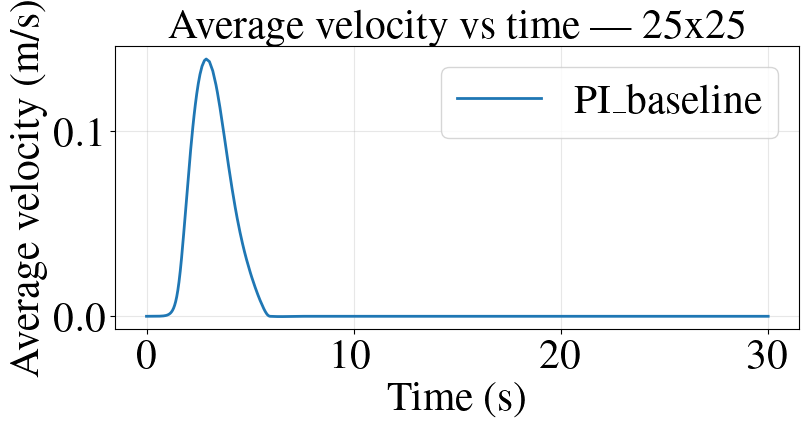

Saved: plots_velocity/velocity_vs_time_25x25.png

EVALUATION COMPLETE


In [53]:
import numpy as np
import time
import json
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.sparse as sp

from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from sb3_contrib import TQC
# from stable_baselines3 import TD3

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
import Solve_IVP_NS
from plants.faults import strikeslip

###############################################################################
# Configuration
###############################################################################
ALGO_REGISTRY = {
    "TQC": TQC,
    # "TD3": TD3,
}

RUN_ROOT = Path("rl_runs").resolve()
N_EVAL_RUNS = 1  # Number of evaluation runs for runtime averaging

# Grid specifications with their specific v_max values
GRID_SPECS = [
    {"Nz": 1, "Nx": 1, "label": "1x1", "v_max": 0.07},  # Training grid
    # {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.07},  # Same v_max as 1x1
    # {"Nz": 5, "Nx": 5, "label": "5x5", "v_max": 0.18},  # Different v_max
]

# Time span (assuming you have this defined globally)
# t_span = [0.0, your_final_time]

# Friction parameters (must match training)
DMU = -0.1
DC = 100.0  # Will be scaled by fault.Dscale
MU_RES = 0.5

###############################################################################
# Build fault and solver for a given grid
###############################################################################
def build_fault_and_solver(Nz, Nx):
    """
    Build a fault model and solver stack for a given grid size.
    Returns dict with all necessary components.
    """
    
    # 1. Create fault for this grid
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
        G=30000., rho=2.5e-3, zeta=0.8/3,
        Ks_path="./Data/", gamma_s=25., gamma_w=10.,
        sigma_ref=100., depth_ini=0., vinf=3.171e-10,
        Dmu_estimate=.5,
    )
    
    # 2. Extract plant matrices
    MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
    N_DOFS_l = fault_local.N
    VINF_l = VINF_raw_l * np.ones(N_DOFS_l) * 0  # Set to zero as in your code
    
    # 3. Build block diagonal A matrix
    I_N = sp.eye(N_DOFS_l, format='csr')
    A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')
    
    # 4. Component slices
    component_slices_l = [
        slice(0, N_DOFS_l),              # v
        slice(N_DOFS_l, 2 * N_DOFS_l),   # u
        slice(2 * N_DOFS_l, 3 * N_DOFS_l) # s
    ]
    
    # 5. Scaled DC for this grid
    DC_scaled = DC / fault_local.Dscale
    
    # 6. Contact force function
    def con_force_l(state, fk=None):
        n = N_DOFS_l
        slip_hist = state[2*n:3*n]
        mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))
        out = np.zeros_like(state)
        out[:n] = mu_vals * SIGMA_N_l
        return out
    
    # 7. Initial state
    y0_l = np.zeros(3 * N_DOFS_l)
    friction_force0 = con_force_l(y0_l)
    uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
    y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)
    
    # 8. Critical energy for normalization
    Uintc_l = 0.5 * float(uc @ (KS_l @ uc))
    
    # 9. Projection operator
    projection_l = CoulombProjection(
        con_force_func=con_force_l,
        rhok=np.ones(N_DOFS_l, dtype=float),
        component_slices=component_slices_l,
        constraint_indices=list(range(N_DOFS_l)),
        use_numba=True,
    )
    
    # 10. VI solver

    # Tuned nonlinear-solver options shared by VI and SSN
    solver_opts_common = dict(
        tol=1e-8,
        max_iter=200,
    )

    # Adaptive controller tuned for nonsmooth dynamics
    adaptive_opts = dict(
        h0=5e-2,
        h_min=1e-7,
        h_down=0.6,
        h_up=1.8,
        method_order=1,           # conservative order for nonsmooth dynamics
        skip_error_indices=[],
        controller='h211b',              # smoother steps with PI control
        b_param=4.0,         # only if controller == "H211b"
        mode = 'ratio'

    )

    # SSN-specific tweaks for robustness and speed
    solver_opts_ssn = dict(solver_opts_common)
    solver_opts_ssn.update({
        "vi_strict_block_lipschitz": False,   # was True by default
        "vi_max_block_adjust_iters": 5,       # smaller safety cap
        "globalization": 'line_search',    # more robust globalization
    })
    solver_mp_l = ImplicitEquationSolver(
        method='VI',
        proj=projection_l,
        component_slices=component_slices_l,
        tol=solver_opts_ssn.get('tol', 1e-6),
        max_iter=solver_opts_ssn.get('max_iter', 100),
        vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
        vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
    )
    
    # 11. Composite method
    method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)
    
    # 12. RHS function
    def rhs_l(t, y):
        n = N_DOFS_l
        v = y[:n]
        u = y[n:2*n]
        
        vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
        udot = v - VINF_l
        sdot = np.abs(v)
        return np.concatenate((vdot, udot, sdot))
    
    return dict(
        fault=fault_local,
        KS=KS_l,
        ES=ES_l,
        SIGMA_N=SIGMA_N_l,
        VINF=VINF_l,
        N_DOFS=N_DOFS_l,
        A=A_l,
        component_slices=component_slices_l,
        con_force=con_force_l,
        y0=y0_l,
        Uintc=Uintc_l,
        method_mp=method_mp_l,
        rhs=rhs_l,
        DC_scaled=DC_scaled,
    )

###############################################################################
# Build observation and reward functions (WITH SIGNED DT_NORM)
###############################################################################
def build_reward_fn(alpha_value: float):
    """Your existing reward function"""
    alpha_value = float(alpha_value)
    
    def my_reward_fn(solver_perf, dt_attempt, xk, env):
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf
        
        dt_range = env.dt_max - env.dt_min
        
        if dts == 0.0:
            dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
            return -dt_norm_attempt
        
        # S1: step size score
        dt_norm = (dts - env.dt_min) / dt_range
        S1 = float(np.clip(dt_norm, 0.0, 1.0))
        
        # S2: runtime score (simplified version)
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))
        
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        
        if not hasattr(env, 'min_runtime_seen'):
            env.min_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc < env.min_runtime_seen:
                env.min_runtime_seen = float(runtime_inc)
        
        rt_min = float(env.min_runtime_seen)
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom
        
        # A: accuracy score
        A = float(np.exp(-alpha_value * E))
        
        reward = S1 * S2 * A
        return reward
    
    return my_reward_fn

def make_obs_reward(alpha_value, grid, v_max_override):
    """
    Build observation and reward functions for evaluation.
    Uses v_max_override for velocity normalization.
    """
    reward_fn = build_reward_fn(alpha_value)
    
    def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None, "env must be provided"
        
        # Extract physics state
        n = grid['N_DOFS']
        v = xk[:n]
        u = xk[n:2*n]
        
        avg_v = float(np.mean(v))
        
        # Elastic energy
        ks_u = grid['KS'] @ u
        E_int = 0.5 * float(np.dot(u, ks_u))
        E_norm = float(E_int / grid['Uintc']) if grid['Uintc'] > 0 else float(E_int)
        
        # Bipolar convergence flag for signed dt_norm
        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0
        
        # RESET BRANCH
        if dt_attempt is None or solver_perf is None:
            dt_norm_default = 0.5
            conv_flag = 0.0 if converged is None else float(converged)
            
            return np.array([
                E_norm,
                avg_v / (v_max_override / grid['fault'].Vscale),  # Use override
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag,
                0.0,  # accuracy proxy neutral
                conv_flag_bipolar * dt_norm_default,  # SIGNED!
            ], dtype=np.float64)
        
        # NORMAL STEP BRANCH
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E_global,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf
        
        # Normalize dt_attempt
        dt_range = env.dt_max - env.dt_min
        if dt_range <= 0.0:
            dt_norm = 0.0
        else:
            dt_norm = (dt_attempt - env.dt_min) / dt_range
            dt_norm = float(np.clip(dt_norm, 0.0, 1.0))
        
        # Convergence and accuracy
        conv_flag = float(converged) if converged is not None else 0.0
        if conv_flag:
            acc = 1.0 / (1.0 + E_global)
        else:
            acc = 0.0
        
        # Return observation with SIGNED dt_norm
        return np.array([
            E_norm,
            avg_v / (v_max_override / grid['fault'].Vscale),  # Use override
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag,
            acc,
            conv_flag_bipolar * dt_norm,  # SIGNED!
        ], dtype=np.float64)
    
    return reward_fn, obs_fn

###############################################################################
# Rollout helper
###############################################################################
def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
    """Roll out a policy on a VecEnv and collect trajectory data."""
    vec_env.training = False
    vec_env.norm_obs = False
    vec_env.norm_reward = False
    
    base_env = vec_env.venv.envs[0]
    
    obs = vec_env.reset()
    times = []
    mean_vel = []
    mean_slip = []
    
    last_t = None
    repeat_count = 0
    broke_stuck = False
    last_converged = None
    last_xk = None
    
    start = time.time()
    done = False
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = vec_env.step(action)
        
        done = bool(dones[0])
        info = infos[0]
        
        t_now = info.get("t_k1", np.nan)
        xk = info.get("xk", None)
        if xk is not None:
            last_xk = xk
        
        if "converged" in info:
            last_converged = info.get("converged")
        
        # Check for stuck time
        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and current_t == last_t:
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: time stuck at {current_t}")
                    broke_stuck = True
                    break
            else:
                repeat_count = 0
            last_t = current_t
        
        # Store trajectory data
        if xk is not None and current_t is not None:
            n = xk.shape[0] // 3
            v_block = xk[:n]
            u_block = xk[n:2*n]
            times.append(current_t)
            mean_vel.append(float(np.mean(v_block)))
            mean_slip.append(float(np.mean(u_block)))
    
    wall_time = time.time() - start
    
    # Determine success
    if last_converged is not None:
        success = bool(last_converged)
    else:
        if len(times) > 0 and hasattr(base_env, 'tnmax'):
            success = (times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck
        else:
            success = not broke_stuck
    
    # Final slip mean
    if last_xk is not None:
        n = last_xk.shape[0] // 3
        s_block = last_xk[2*n:3*n]
        s_end_mean = float(np.mean(s_block))
    else:
        s_end_mean = np.nan
    
    print(f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, "
          f"final_t={(times[-1] if len(times)>0 else 'NA'):.3f}, "
          f"s_end={s_end_mean:.6e}")
    
    return (
        np.asarray(times, dtype=float),
        np.asarray(mean_vel, dtype=float),
        np.asarray(mean_slip, dtype=float),
        float(wall_time),
        bool(success),
        s_end_mean,
    )

###############################################################################
# Evaluate policies on a specific grid
###############################################################################
def evaluate_policies_for_grid(grid, spec, alpha_dirs):
    """Evaluate all trained policies on a specific grid configuration."""
    
    v_max_override = spec['v_max']
    grid_label = spec['label']
    
    # Time step bounds (adjust as needed)
    local_dt_min = 1e-7
    local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale
    
    series = {}
    
    for alpha_dir in alpha_dirs:
        algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
        
        for algo_dir in algo_dirs:
            algo_name = algo_dir.name
            ModelClass = ALGO_REGISTRY.get(algo_name)
            if ModelClass is None:
                continue
            
            meta_path = algo_dir / "metadata.json"
            model_path = algo_dir / "model.zip"
            if not model_path.exists():
                model_path = algo_dir / "model"
            vecnorm_path = algo_dir / "vec_norm.pkl"
            
            if not meta_path.exists() or not model_path.exists():
                continue
            
            with open(meta_path, "r", encoding="utf-8") as fh:
                meta = json.load(fh)
            
            alpha_value = float(meta.get("alpha", np.nan))
            if not np.isfinite(alpha_value):
                continue
            
            # Build reward/obs functions for this grid
            reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)
            
            # Environment factory
            def make_env():
                obs_space = spaces.Box(
                    low=-np.inf,
                    high=np.inf,
                    shape=(6,),
                    dtype=np.float64
                )
                return AdaptiveStepperEnv(
                    system=grid['rhs'],
                    dt0=local_dt_min,
                    t0=t_span[0],
                    x0=grid['y0'],
                    tnmax=t_span[1],
                    dt_min=local_dt_min,
                    dt_max=local_dt_max,
                    nparams=(1e-6, 100),
                    integrator=grid['method_mp'],
                    component_slices=grid['component_slices'],
                    reward_fn=reward_fn,
                    obs_fn=obs_fn,
                    obs_space=obs_space,
                    verbose=False,
                    alpha=alpha_value,
                )
            
            # Load model
            model = ModelClass.load(str(model_path), device="cpu")
            
            # Run evaluations
            runtimes = []
            success_runs = []
            slip_end_list = []
            t_store = None
            v_store = None
            u_store = None
            
            key = f"{algo_name} alpha={alpha_value:g}"
            print(f"\nEvaluating {key} on grid {grid_label}...")
            
            for run_idx in range(N_EVAL_RUNS):
                # Create fresh env for each run
                base_vec_env = DummyVecEnv([make_env])
                
                # Load VecNormalize if available
                if vecnorm_path.exists():
                    vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
                    vec_env.training = False
                    vec_env.norm_obs = False  # Disable since we handle normalization
                    vec_env.norm_reward = False
                else:
                    vec_env = base_vec_env
                
                # Attach env to model
                model.set_env(vec_env)
                
                # Rollout
                t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
                    model, vec_env, run_name=f"{key} run{run_idx}"
                )
                
                runtimes.append(wall)
                success_runs.append(success)
                slip_end_list.append(s_end_mean)
                
                if run_idx == 0:
                    t_store = t_arr
                    v_store = v_mean
                    u_store = u_mean
                
                vec_env.close()
                
                # Stop if first run failed (deterministic policy)
                if run_idx == 0 and not success:
                    break
            
            # Record results if any run succeeded
            if any(success_runs):
                series[key] = dict(
                    times=t_store if t_store/fault.Tscale is not None else np.array([]),
                    mean_v=v_store if v_store/fault.Vscale is not None else np.array([]),
                    mean_u=u_store if u_store/fault.Dscale is not None else np.array([]),
                    runtime_s=float(np.mean(runtimes)),
                    runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
                    converged=True,
                    success_rate=sum(success_runs) / len(success_runs),
                    s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])),
                )
                print(f"  Success rate: {series[key]['success_rate']:.1%}, "
                      f"Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s")
    
    return series

###############################################################################
# PI Baseline
###############################################################################
def adaptive_baseline_for_grid(grid, adaptive_opts):
    """Run classical PI adaptive controller as baseline."""
    
    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )
    
    local_adapt = dict(adaptive_opts)
    local_adapt["use_PI"] = True
    
    runtimes_b = []
    success_runs = []
    slip_end_list = []
    t_store = None
    y_store = None
    
    for run_idx in range(N_EVAL_RUNS):
        start_b = time.time()
        try:
            (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
                fun=grid['rhs'],
                t_span=t_span,
                y0=grid['y0'],
                method='composite',
                projection='coulomb',
                solver='VI',
                projection_opts=projection_opts_nb,
                solver_opts=solver_opts_ssn,
                adaptive=True,
                adaptive_opts=local_adapt,
                h0=local_adapt.get('h0', 5e-3),
                component_slices=grid['component_slices'],
                verbose=False,
                A=grid['A'],
            )
            wall_b = time.time() - start_b
            
            success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
            success_runs.append(success)
            runtimes_b.append(wall_b)
            
            n = grid['N_DOFS']
            s_final_block = y_vals_b[-1, 2*n:3*n]
            s_end_mean = float(np.mean(s_final_block))
            slip_end_list.append(s_end_mean)
            
            if run_idx == 0:
                t_store = t_vals_b
                y_store = y_vals_b
            
            print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")
                
        except Exception as e:
            print(f"  PI baseline run {run_idx} failed: {e}")
            success_runs.append(False)
    
    if not any(success_runs):
        print("  WARNING: PI baseline failed all runs")
        return None
    
    n = grid['N_DOFS']
    v_b = np.mean(y_store[:, :n], axis=1)
    u_b = np.mean(y_store[:, n:2*n], axis=1)
    
    return dict(
        times=np.asarray(t_store, dtype=float),
        mean_v=np.asarray(v_b),
        mean_u=np.asarray(u_b),
        runtime_s=float(np.mean(runtimes_b)),
        runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
        converged=True,
        success_rate=sum(success_runs) / len(success_runs),
        s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])),
    )

###############################################################################
# Main Execution
###############################################################################
if __name__ == "__main__":
    # Discover trained models
    alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
    if not alpha_dirs:
        raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")
    
    # PI controller settings
    adaptive_opts_pi = dict(
        h0=5e-3,
        h_min=1e-7,
        h_down=0.6,
        h_up=1.8,
        method_order=1,
        controller="H211b",
        b_param=4.0,
        skip_error_indices=[],
    )
    
    # Results storage
    all_results = {}
    
    # Evaluate on each grid
    for spec in GRID_SPECS:
        print(f"\n{'='*60}")
        print(f"Evaluating on {spec['label']} grid (v_max={spec['v_max']})")
        print('='*60)
        
        # Build grid
        grid = build_fault_and_solver(spec["Nz"], spec["Nx"])
        
        # Evaluate RL policies
        series = evaluate_policies_for_grid(grid, spec, alpha_dirs)
        
        # Evaluate PI baseline
        print(f"\nRunning PI baseline on {spec['label']}...")
        baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
        if baseline is not None:
            series["PI_baseline"] = baseline
        
        all_results[spec['label']] = series
        
        # Save results
        cache_path = Path(f"eval_results_{spec['label']}.json")
        
        # Convert numpy arrays to lists for JSON serialization
        json_series = {}
        for key, data in series.items():
            json_series[key] = {
                "times": data["times"].tolist() if isinstance(data["times"], np.ndarray) else data["times"],
                "mean_v": data["mean_v"].tolist() if isinstance(data["mean_v"], np.ndarray) else data["mean_v"],
                "mean_u": data["mean_u"].tolist() if isinstance(data["mean_u"], np.ndarray) else data["mean_u"],
                "runtime_s": data["runtime_s"],
                "runtime_std": data["runtime_std"],
                "converged": data["converged"],
                "success_rate": data.get("success_rate", 1.0),
                "s_end_mean": data.get("s_end_mean", 0.0),
            }
        
        with open(cache_path, "w") as f:
            json.dump(json_series, f, indent=2)
        print(f"Saved results to {cache_path}")
    
    # Plot comparisons across grids
    import matplotlib.pyplot as plt
    
    # Runtime comparison
    fig, axes = plt.subplots(1, len(GRID_SPECS), figsize=(5*len(GRID_SPECS), 4))
    if len(GRID_SPECS) == 1:
        axes = [axes]
    
    for idx, spec in enumerate(GRID_SPECS):
        ax = axes[idx]
        series = all_results.get(spec['label'], {})
        
        methods = []
        runtimes = []
        for name, data in series.items():
            if data.get('converged', False):
                methods.append(name)
                runtimes.append(data['runtime_s'])
        
        if methods:
            x_pos = np.arange(len(methods))
            ax.bar(x_pos, runtimes)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(methods, rotation=45, ha='right')
            ax.set_ylabel('Runtime (s)')
            ax.set_title(f'{spec["label"]} Grid')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('runtime_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("EVALUATION COMPLETE")
    print("="*60)

In [ ]:
# Multi-grid baseline evaluation: mean velocity/slip (physical units) and runtimes
from collections import OrderedDict
if 'build_fault_and_solver' not in globals():
    raise RuntimeError("build_fault_and_solver must be defined before running this cell.")

# Default grid sweep if none provided elsewhere
if 'GRID_SPECS' not in globals():
    GRID_SPECS = [
        dict(Nz=25, Nx=25, label="25x25"),
        dict(Nz=30, Nx=30, label="30x30"),
        dict(Nz=40, Nx=40, label="40x40"),
    ]

multi_grid_results = OrderedDict()
runtime_rows = []

for spec in GRID_SPECS:
    if isinstance(spec, dict):
        Nz = spec.get('Nz')
        Nx = spec.get('Nx')
        label = spec.get('label', f"{Nz}x{Nx}")
    else:
        Nz, Nx = spec
        label = f"{Nz}x{Nx}"
    if Nz is None or Nx is None:
        raise ValueError(f"Grid spec must provide Nz and Nx, got {spec}")

    print(f"\n=== Solving baseline for grid {label} (Nz={Nz}, Nx={Nx}) ===")

    grid = build_fault_and_solver(int(Nz), int(Nx))
    fault_grid = grid['fault']
    v_scale = getattr(fault_grid, 'Vscale', 1.0)
    d_scale = getattr(fault_grid, 'Dscale', 1.0)
    # Convert solver time to physical seconds: Tscale (model -> physical) divided by fault.second (physical s)
    t_scale = getattr(fault_grid, 'Tscale', 1.0) / getattr(fault_grid, 'second', 1.0)

    projection_opts_grid = dict(
'con_force_func': grid['con_force'],
'rhok': np.ones(grid['N_DOFS'], dtype=float),
'component_slices': grid['component_slices'],
'constraint_indices': list(range(grid['N_DOFS'])),
'use_numba': True,
)

    start = time.time()
    t_vals, y_vals, h_vals, fk_vals, solver_info = Solve_IVP_NS.solve_ivp_ns(
        fun=grid['rhs'],
t_span=t_span,
y0=grid['y0'],
method='composite',
projection='coulomb',
solver='VI',
projection_opts=projection_opts_grid,
solver_opts=solver_opts_ssn,
adaptive=True,
adaptive_opts=adaptive_opts,
h0=adaptive_opts['h0'],
component_slices=grid['component_slices'],
verbose=False,
A=grid['A'],
)
    runtime = time.time() - start

    n = grid['N_DOFS']
    mean_v = np.mean(y_vals[:, :n], axis=1) * v_scale
    mean_u = np.mean(y_vals[:, n:2*n], axis=1) * d_scale
    times_physical = np.asarray(t_vals, dtype=float) * t_scale

    multi_grid_results[label] = dict(
        times=times_physical,
mean_v=mean_v,
mean_u=mean_u,
runtime_s=float(runtime),
Nz=int(Nz),
Nx=int(Nx),
v_scale=v_scale,
d_scale=d_scale,
t_scale=t_scale,
)

    series_key = f"baseline_{label}"
    series[series_key] = {
'times': times_physical,
'mean_v': mean_v,
'mean_u': mean_u,
'runtime_s': float(runtime),
'runtime_std': 0.0,
'converged': bool(len(t_vals) > 0 and t_vals[-1] >= 0.999 * t_span[1]),
}

    runtime_rows.append({
'grid': label,
'Nz': int(Nz),
'Nx': int(Nx),
'runtime_s': float(runtime),
'steps': len(t_vals),
})
print(f"finished grid {label}: runtime {runtime:.3f} s, steps {len(t_vals)}")

if _HAVE_PANDAS:
    df_grids = pd.DataFrame(runtime_rows)
    display(df_grids)
else:
    print("Runtime summary:")
    for row in runtime_rows:
        print(row)

    multi_grid_results[label] = dict(
        times=np.asarray(t_vals, dtype=float),
mean_v=np.asarray(mean_v, dtype=float),
mean_u=np.asarray(mean_u, dtype=float),
runtime_s=float(runtime),
Nz=int(Nz),
Nx=int(Nx),
)

    series_key = f"baseline_{label}"
    series[series_key] = {
'times': multi_grid_results[label]['times'],
'mean_v': multi_grid_results[label]['mean_v'],
'mean_u': multi_grid_results[label]['mean_u'],
'runtime_s': multi_grid_results[label]['runtime_s'],
'runtime_std': 0.0,
'converged': bool(len(t_vals) > 0 and t_vals[-1] >= 0.999 * t_span[1]),
}

    runtime_rows.append({
'grid': label,
'Nz': int(Nz),
'Nx': int(Nx),
'runtime_s': multi_grid_results[label]['runtime_s'],
'steps': len(t_vals),
})
print(f"finished grid {label}: runtime {runtime:.3f} s, steps {len(t_vals)}")

if _HAVE_PANDAS:
    df_grids = pd.DataFrame(runtime_rows)
    display(df_grids)
else:
    print("Runtime summary:")
    for row in runtime_rows:
        print(row)
   grid = build_fault_and_solver(Nz, Nx)
    projection_opts_grid = dict(
'con_force_func': grid['con_force'],
'rhok': np.ones(grid['N_DOFS'], dtype=float),
'component_slices': grid['component_slices'],
'constraint_indices': list(range(grid['N_DOFS'])),
'use_numba': True,
)

    start = time.time()
    t_vals, y_vals, h_vals, fk_vals, solver_info = Solve_IVP_NS.solve_ivp_ns(
        fun=grid['rhs'],
t_span=t_span,
y0=grid['y0'],
method='composite',
projection='coulomb',
solver='VI',
projection_opts=projection_opts_grid,
solver_opts=solver_opts_ssn,
adaptive=True,
adaptive_opts=adaptive_opts,
h0=adaptive_opts['h0'],
component_slices=grid['component_slices'],
verbose=False,
A=grid['A'],
)
    runtime = time.time() - start

    n = grid['N_DOFS']
    mean_v = np.mean(y_vals[:, :n], axis=1)
    mean_u = np.mean(y_vals[:, n:2*n], axis=1)

    multi_grid_results[label] = dict(
        times=np.asarray(t_vals, dtype=float),
mean_v=np.asarray(mean_v, dtype=float),
mean_u=np.asarray(mean_u, dtype=float),
runtime_s=float(runtime),
Nz=int(Nz),
Nx=int(Nx),
)

    series_key = f"baseline_{label}"
    series[series_key] = {
'times': multi_grid_results[label]['times'],
'mean_v': multi_grid_results[label]['mean_v'],
'mean_u': multi_grid_results[label]['mean_u'],
'runtime_s': multi_grid_results[label]['runtime_s'],
'runtime_std': 0.0,
'converged': bool(len(t_vals) > 0 and t_vals[-1] >= 0.999 * t_span[1]),
}

    runtime_rows.append({
'grid': label,
'Nz': Nz,
'Nx': Nx,
'runtime_s': multi_grid_results[label]['runtime_s'],
'steps': len(t_vals),
})
print(f"finished grid {label}: runtime {runtime:.3f} s, steps {len(t_vals)}")

if _HAVE_PANDAS:
    df_grids = pd.DataFrame(runtime_rows)
    display(df_grids)
else:
    print("Runtime summary:")
    for row in runtime_rows:
        print(row)
 - MU_RES, DMU, DC
# - solver_opts_ssn
# - estimate_v_max_range(...)
# - t_span (2-tuple of [t0, t_final])

###############################################################################
# Registry so we can grab the right class from folder name "TD3"/"TQC"
###############################################################################
ALGO_REGISTRY = {
    # "TD3": TD3,
    "TQC": TQC,
}

###############################################################################
# Discover trained alpha directories on disk
###############################################################################
RUN_ROOT = Path("rl_runs").resolve()
alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
if not alpha_dirs:
    raise FileNotFoundError(
        f"No trained runs found under {RUN_ROOT}. "
        "Expected folders like alpha_1p0/TQC, alpha_1p0/TD3, etc."
    )


###############################################################################
# Build fault, plant matrices, solver stack, RHS for a given grid (Nz, Nx)
###############################################################################
def build_fault_and_solver(Nz, Nx):
    """
    Build a model and solver stack for a fault discretized with (Nz, Nx).

    Returns dict with:
      fault, KS, ES, SIGMA_N, VINF,
      N_DOFS, A, component_slices,
      con_force, y0, Uintc, v_max,
      method_mp, rhs
    """

    # 1. Make fault for this grid
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
        G=30000., rho=2.5e-3, zeta=0.8/3,
        Ks_path="./Data/", gamma_s=25., gamma_w=10.,
        sigma_ref=100., depth_ini=0., vinf=3.171e-10,
        Dmu_estimate=.5,
    )

    # 2. Extract plant
    MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
    N_DOFS_l = fault_local.N
    VINF_l = VINF_raw_l * np.ones(N_DOFS_l)

    # 3. Build A = blockdiag(MA, I, I) to match state [v,u,s]
    I_N = sp.eye(N_DOFS_l, format='csr')
    A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

    # 4. Component slices for [v, u, s] in y
    component_slices_l = [
        slice(0, N_DOFS_l),              # v
        slice(N_DOFS_l, 2 * N_DOFS_l),   # u
        slice(2 * N_DOFS_l, 3 * N_DOFS_l) # s
    ]

    # 5. Contact/friction force law for this grid
    def con_force_l(state, fk=None):
        # state layout: [v, u, s]
        n = N_DOFS_l
        slip_hist = state[2*n:3*n]  # s = cumulative slip measure
        mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / (DC)))
        out = np.zeros_like(state)
        out[:n] = mu_vals * SIGMA_N_l
        return out

    # 6. Initial state y0
    # start with zeros, then perturb u around static equilibrium
    y0_l = np.zeros(3 * N_DOFS_l)
    friction_force0 = con_force_l(y0_l)
    uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
    y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)

    # 7. Uintc for energy normalization
    Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

    # 8. v_max estimate for scaling avg slip rate in obs
    vmax_info = estimate_v_max_range(
        y0_l, KS_l, ES_l, SIGMA_N_l, MU_RES, DMU, DC, VINF_l
    )
    v_max_l = vmax_info['kb_estimate']  # <-- scalar velocity scale

    # 9. Projection operator for VI solver
    projection_l = CoulombProjection(
        con_force_func=con_force_l,
        rhok=np.ones(N_DOFS_l, dtype=float),
        component_slices=component_slices_l,
        constraint_indices=list(range(N_DOFS_l)),
        use_numba=True,
    )

    # 10. Nonlinear VI solver
    solver_mp_l = ImplicitEquationSolver(
        method='VI',
        proj=projection_l,
        component_slices=component_slices_l,
        tol=solver_opts_ssn.get('tol', 1e-6),
        max_iter=solver_opts_ssn.get('max_iter', 100),
        vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
        vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
    )

    # 11. Time-stepping method
    method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

    # 12. RHS for this grid
    def rhs_l(t, y):
        """
        y = [v, u, s]
        vdot = -(KS u) - (ES (v - VINF))
        udot = v - VINF
        sdot = |v|
        """
        n = N_DOFS_l
        v = y[:n]
        u = y[n:2*n]
        s = y[2*n:3*n]  # noqa: F841 (s not used explicitly in rhs)

        vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
        udot = v - VINF_l
        sdot = np.abs(v)
        return np.concatenate((vdot, udot, sdot))

    return dict(
        fault=fault_local,
        KS=KS_l,
        ES=ES_l,
        SIGMA_N=SIGMA_N_l,
        VINF=VINF_l,
        N_DOFS=N_DOFS_l,
        A=A_l,
        component_slices=component_slices_l,
        con_force=con_force_l,
        y0=y0_l,
        Uintc=Uintc_l,
        v_max=v_max_l,
        method_mp=method_mp_l,
        rhs=rhs_l,
    )


###############################################################################
# Build obs_fn and reward_fn for a given alpha, using THIS grid's scalings
###############################################################################
def make_obs_reward(alpha_value, KS_l, Uintc_l, v_max_l):
    """
    Returns:
      reward_fn   = build_reward_fn(alpha_value)
      obs_fn(...) = fn(dt_attempt, converged, xk, solver_perf, fk, env)
                    -> 6-D np.array observation

    NOTE: we assume build_reward_fn(alpha) already exists globally
    exactly like you had in training.
    """
    reward_fn = build_reward_fn(alpha_value)

    def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        """
        Observation layout (size 6):
            [0] E_norm          (elastic energy / Uintc_l)
            [1] avg_v / v_max_l (mean slip rate scaled)
            [2] iter_error/4    (solver iteration quality proxy)
            [3] conv_flag       (1 if accepted step)
            [4] acc             (accuracy proxy ~ 1/(1+alpha*err))
            [5] dt_norm         (proposed dt in [0,1])

        Works both on reset and normal steps.
        """

        n = KS_l.shape[0]
        v = xk[:n]
        u = xk[n:2*n]

        # elastic energy
        ks_u = KS_l @ u
        E_int = 0.5 * float(np.dot(u, ks_u))
        E_norm = float(E_int / Uintc_l) if Uintc_l > 0 else 0.0

        avg_v = float(np.mean(v))

        # RESET BRANCH: env.reset() calls obs_fn(dt_attempt=None,...)
        if dt_attempt is None or solver_perf is None:
            dt_norm_default = 0.5
            conv_flag_reset = 0.0 if converged is None else float(converged)

            return np.array([
                E_norm,
                avg_v / max(v_max_l, 1e-12),
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag_reset,
                0.0,                 # accuracy proxy neutral on reset
                dt_norm_default,
            ], dtype=np.float64)

        # NORMAL STEP BRANCH:
        # Richardson / global error estimate from solver_perf[5]
        err_val = 0.0
        if solver_perf is not None and len(solver_perf) > 5 and solver_perf[5] is not None:
            try:
                candidate = float(solver_perf[5])
                if np.isfinite(candidate):
                    err_val = candidate
            except Exception:
                err_val = 0.0

        conv_flag = 1.0 if bool(converged) else 0.0

        # normalize dt
        if env is not None and getattr(env, 'dt_max', None) is not None and getattr(env, 'dt_min', None) is not None:
            denom = max(1e-12, env.dt_max - env.dt_min)
            dt_norm = float((dt_attempt - env.dt_min) / denom)
        else:
            dt_norm = 0.0

        # accuracy proxy consistent w/ reward shaping
        if conv_flag:
            acc = 1.0 / (1.0 + alpha_value * err_val)
        else:
            acc = 0.0

        return np.array([
            E_norm,
            avg_v / max(v_max_l, 1e-12),
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag,
            acc,
            dt_norm,
        ], dtype=np.float64)

    return reward_fn, obs_fn


###############################################################################
# Reference "truth" solve with tiny constant dt
###############################################################################
def constant_dt_reference_for_grid(grid, local_dt_min):
    """
    Run a super-small fixed-step solve (no RL, no adaptive controller)
    as a high-accuracy reference.

    We use dt_ref = local_dt_min/10 and adaptive=False.

    Returns:
        s_ref_mean  = average final slip-history block s over DOFs
        ref_runtime = wallclock for that run
        dt_ref      = dt_ref we used
    """

    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )

    dt_ref = local_dt_min / 10.0
    start_t = time.time()

    (t_vals_ref,
     y_vals_ref,
     h_vals_ref,
     fk_vals_ref,
     solver_info_ref) = Solve_IVP_NS.solve_ivp_ns(
        fun=grid['rhs'],
        t_span=t_span,
        y0=grid['y0'],
        method='composite',
        projection='coulomb',
        solver='VI',
        projection_opts=projection_opts_nb,
        solver_opts=solver_opts_ssn,
        adaptive=False,
        adaptive_opts=None,
        h0=dt_ref,
        component_slices=grid['component_slices'],
        verbose=False,
        A=grid['A'],
    )

    ref_runtime = time.time() - start_t

    n = grid['N_DOFS']
    s_final_block = y_vals_ref[-1, 2*n:3*n]
    s_ref_mean = float(np.mean(s_final_block))

    return s_ref_mean, float(ref_runtime), float(dt_ref)


###############################################################################
# Rollout helper for a *VecEnv* (DummyVecEnv + VecNormalize)
###############################################################################
def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
    """
    Roll out a trained SB3 policy attached to a VecNormalize-wrapped DummyVecEnv.

    Tracks:
      - times (physical time from env info["t_k1"])
      - mean velocity over DOFs
      - mean slip over DOFs
      - elapsed wall-clock
      - success flag (hit tnmax without getting stuck OR env says converged)
      - s_end_mean (avg final cumulative slip-history s)

    Returns:
      times_arr, mean_vel_arr, mean_slip_arr, wall_time, success, s_end_mean
    """

    # Make sure we're in eval mode (no stat updates)
    vec_env.training    = False
    vec_env.norm_obs    = False
    vec_env.norm_reward = False

    # grab the underlying single AdaptiveStepperEnv for metadata
    base_env = vec_env.venv.envs[0]

    obs = vec_env.reset()  # obs is shape (1, obs_dim) because vec env
    times = []
    mean_vel = []
    mean_slip = []

    last_t = None
    repeat_count = 0
    broke_stuck = False
    last_converged = None
    last_xk = None

    start = time.time()
    done = False

    while not done:
        # deterministic policy action
        action, _ = model.predict(obs, deterministic=True)

        obs, rewards, dones, infos = vec_env.step(action)

        done = bool(dones[0])
        info = infos[0]

        # pluck data from info
        t_now = info.get("t_k1", np.nan)
        xk = info.get("xk", None)
        if xk is not None:
            last_xk = xk

        if "converged" in info:
            last_converged = info.get("converged")

        # repeated-time guard to avoid infinite loops
        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and current_t == last_t:
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: time stuck at {current_t} for 10 iterations, aborting rollout")
                    broke_stuck = True
                    break
            else:
                repeat_count = 0
            last_t = current_t

        # store traces if we have both time + state
        if xk is not None and current_t is not None:
            n = xk.shape[0] // 3
            v_block = xk[:n]
            u_block = xk[n:2*n]
            times.append(current_t)
            mean_vel.append(float(np.mean(v_block)))
            mean_slip.append(float(np.mean(u_block)))

    wall_time = time.time() - start
    print(
        f"[{run_name}] Rollout finished: wall_time={wall_time:.3f}s, "
        f"steps={len(times)}, final_t={(times[-1] if len(times)>0 else 'NA')}"
    )

    # success logic
    if last_converged is not None:
        success = bool(last_converged)
    else:
        if len(times) > 0 and hasattr(base_env, 'tnmax') and base_env.tnmax is not None:
            success = (times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck
        else:
            success = not broke_stuck

    # final slip mean
    if last_xk is not None:
        n = last_xk.shape[0] // 3
        s_block = last_xk[2*n:3*n]
        s_end_mean = float(np.mean(s_block))
        print(f"[{run_name}] Final cumulative slip mean s_end_mean={s_end_mean:.6e}")
    else:
        s_end_mean = np.nan

    return (
        np.asarray(times, dtype=float),
        np.asarray(mean_vel, dtype=float),
        np.asarray(mean_slip, dtype=float),
        float(wall_time),
        bool(success),
        s_end_mean,
    )


###############################################################################
# Evaluate every saved policy (TQC/TD3) on a target grid
# using that grid's solver + obs/reward builders
###############################################################################
def evaluate_policies_for_grid(
    grid,
    alpha_dirs,
    repeats,
    local_dt_min,
    local_dt_max,
    s_ref_mean
):
    """
    For each alpha_* folder and each algo subfolder (TQC, TD3), do:
      - rebuild reward_fn/obs_fn for THIS grid
      - rebuild env factory for THIS grid
      - load vec_norm.pkl and re-wrap env in DummyVecEnv+VecNormalize
      - load model.zip and attach that vec_env
      - rollout the policy repeats times

    We record:
      times, mean_v, mean_u (from first successful rollout)
      avg runtime, std runtime
      relative slip error wrt s_ref_mean
    """
    method_mp_l = grid['method_mp']
    component_slices_l = grid['component_slices']
    series = {}

    for alpha_dir in alpha_dirs:
        algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
        if not algo_dirs:
            continue

        for algo_dir in algo_dirs:
            algo_name = algo_dir.name  # "TQC" or "TD3"
            ModelClass = ALGO_REGISTRY.get(algo_name)
            if ModelClass is None:
                continue

            meta_path      = algo_dir / "metadata.json"
            mdl_zip        = algo_dir / "model.zip"
            mdl_plain      = algo_dir / "model"
            vecnorm_path   = algo_dir / "vec_norm.pkl"

            if not meta_path.exists():
                continue
            if not vecnorm_path.exists():
                # without VecNormalize stats we can't faithfully recreate training interface
                continue

            with open(meta_path, "r", encoding="utf-8") as fh:
                meta = json.load(fh)

            try:
                alpha_value = float(meta.get("alpha", "nan"))
            except Exception:
                continue
            if not np.isfinite(alpha_value):
                continue

            mdl_path = mdl_zip if mdl_zip.exists() else mdl_plain
            if not mdl_path.exists():
                continue

            # Build per-grid, per-alpha reward/obs
            reward_fn, obs_fn = make_obs_reward(
                alpha_value,
                grid['KS'],
                grid['Uintc'],
                grid['v_max'],
            )

            # Env constructor that matches training layout except for grid changes
            def make_env():
                obs_dim = 6
                obs_space = spaces.Box(
                    low=-np.inf,
                    high=np.inf,
                    shape=(obs_dim,),
                    dtype=np.float64
                )
                return AdaptiveStepperEnv(
                    system=grid['rhs'],
                    dt0=local_dt_min,
                    t0=t_span[0],
                    x0=grid['y0'],
                    tnmax=t_span[1],
                    dt_min=local_dt_min,
                    dt_max=local_dt_max,
                    nparams=(1e-6, 100),
                    integrator=method_mp_l,
                    component_slices=component_slices_l,
                    reward_fn=reward_fn,
                    obs_fn=obs_fn,
                    obs_space=obs_space,
                    verbose=False,
                    alpha=alpha_value,
                )

            # Load model ONCE (weights only, no env yet)
            model = ModelClass.load(str(mdl_path), device="cpu")

            runtimes   = []
            success_rs = []
            slip_end_list = []

            t_store = None
            v_store = None
            u_store = None

            for rep in range(repeats):
                # For each repeat, build a fresh vec env with the same stats
                base_vec_env = DummyVecEnv([make_env])

                # Restore VecNormalize (this recreates the wrapper from training-time)
                vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)

                # Put VecNormalize in eval mode
                vec_env.training    = False
                vec_env.norm_obs    = False
                vec_env.norm_reward = False

                # Attach env to model so predict() can interact cleanly
                model.set_env(vec_env)

                # Rollout
                t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
                    model,
                    vec_env,
                    run_name=f"{algo_name} alpha={alpha_value}"
                )

                runtimes.append(float(wall))
                success_rs.append(bool(success))
                slip_end_list.append(float(s_end_mean))

                if rep == 0:
                    # We'll store the first trajectory for plotting/reporting.
                    t_store = t_arr
                    v_store = v_mean
                    u_store = u_mean

                # If the first run already failed (deterministic policy),
                # no point doing more repeats.
                if rep == 0 and not success:
                    break

            # Only record this series if we got at least one successful run
            if any(success_rs):
                denom = max(abs(s_ref_mean), 1e-12)
                rel_err_runs = [
                    abs(s_i - s_ref_mean) / denom
                    for s_i in slip_end_list
                    if np.isfinite(s_i)
                ]
                rel_err_mean = float(np.mean(rel_err_runs)) if rel_err_runs else float('nan')
                rel_err_std  = float(np.std(rel_err_runs))  if rel_err_runs else float('nan')

                key = f"{algo_name} alpha={alpha_value:g}"
                series[key] = dict(
                    times       = np.asarray(t_store) if t_store is not None else np.asarray([]),
                    mean_v      = np.asarray(v_store) if v_store is not None else np.asarray([]),
                    mean_u      = np.asarray(u_store) if u_store is not None else np.asarray([]),
                    runtime_s   = float(np.mean(runtimes)),
                    runtime_std = float(np.std(runtimes)),
                    converged   = True,
                    rel_err     = rel_err_mean,
                    rel_err_std = rel_err_std,
                )
            else:
                print(f"[{algo_name} alpha={alpha_value}] skipped: no successful rollouts")

    return series


###############################################################################
# Baseline PI adaptive controller (classical timestep controller, no RL)
###############################################################################
def adaptive_baseline_for_grid(grid, controller_opts, repeats, s_ref_mean):
    """
    Run your classical adaptive PI/digital-filter timestep controller
    as a baseline on this grid.

    controller_opts should include
        h0, h_min, h_down, h_up,
        method_order,
        controller="H211b",
        b_param=4.0,
        skip_error_indices=[...],
        etc.

    We'll force use_PI=True and run `repeats` times.
    We report runtime stats, relative slip error vs the high-accuracy reference,
    and we also pull out mean velocity/slip vs time for the first run.
    """

    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )

    local_adapt = dict(controller_opts)
    local_adapt["use_PI"] = True  # enforce PI controller

    runtimes_b = []
    success_runs = []
    slip_end_list = []

    t_store = None
    y_store = None

    for rep in range(repeats):
        start_b = time.time()
        try:
            (t_vals_b,
             y_vals_b,
             h_vals_b,
             fk_vals_b,
             solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
                fun=grid['rhs'],
                t_span=t_span,
                y0=grid['y0'],
                method='composite',
                projection='coulomb',
                solver='VI',
                projection_opts=projection_opts_nb,
                solver_opts=solver_opts_ssn,
                adaptive=True,
                adaptive_opts=local_adapt,
                h0=local_adapt.get('h0', 5e-3),
                component_slices=grid['component_slices'],
                verbose=False,
                A=grid['A'],
            )
            wall_b = time.time() - start_b

            # success if we basically reached final time
            success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
            success_runs.append(bool(success))
            runtimes_b.append(float(wall_b))

            # final slip mean for THIS run
            n = grid['N_DOFS']
            s_final_block = y_vals_b[-1, 2*n:3*n]
            s_end_mean = float(np.mean(s_final_block))
            slip_end_list.append(s_end_mean)

            # keep trajectory from first run for plotting
            if rep == 0:
                t_store = t_vals_b
                y_store = y_vals_b

        except Exception as e:
            print(f"Baseline PI run {rep+1} failed: {e}")
            success_runs.append(False)
            # skip runtime/slip append here on failure

    if not any(success_runs):
        print("WARNING: PI baseline did not converge in any repeat(s)")
        return None

    avg_runtime_b = float(np.mean(runtimes_b))
    std_runtime_b = float(np.std(runtimes_b))

    # relative slip error vs reference
    denom = max(abs(s_ref_mean), 1e-12)
    rel_err_runs = [
        abs(s_i - s_ref_mean) / denom
        for s_i in slip_end_list
        if np.isfinite(s_i)
    ]
    rel_err_mean = float(np.mean(rel_err_runs)) if rel_err_runs else float('nan')
    rel_err_std  = float(np.std(rel_err_runs))  if rel_err_runs else float('nan')

    # extract mean velocity & mean slip vs time from first stored run
    if y_store is not None:
        n = grid['N_DOFS']
        v_b = np.mean(y_store[:, :n], axis=1)
        u_b = np.mean(y_store[:, n:2*n], axis=1)
        t_arr_b = np.asarray(t_store, dtype=float)
    else:
        v_b = np.asarray([], dtype=float)
        u_b = np.asarray([], dtype=float)
        t_arr_b = np.asarray([], dtype=float)

    return dict(
        times       = t_arr_b,
        mean_v      = np.asarray(v_b),
        mean_u      = np.asarray(u_b),
        runtime_s   = avg_runtime_b,
        runtime_std = std_runtime_b,
        converged   = True,
        rel_err     = rel_err_mean,
        rel_err_std = rel_err_std,
    )


###############################################################################
# (Optional) Example driver usage
###############################################################################
if __name__ == "__main__":
    # controller options for baseline PI
    controller_opts_pi = dict(
        h0=5e-3,
        h_min=1e-12,
        h_down=0.6,
        h_up=2.0,
        method_order=1,         # p = 1 => k = p+1 = 2
        controller="H211b",     # digital filter flavor
        b_param=4.0,
        skip_error_indices=[],
    )

    # which grids you want to test generalization on
    specs = [
        {"Nz": 25, "Nx": 25, "label": "25x25"},
        # {"Nz": 50, "Nx": 50, "label": "50x50"},
    ]

    CACHE_ROOT = Path("rl_eval_cache")
    CACHE_ROOT.mkdir(parents=True, exist_ok=True)

    for spec in specs:
        print(f"\n=== Evaluating grid {spec['label']} ===")
        grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

        # dt bounds for this grid, similar to what you used in training
        local_dt_min = 1e-3 #* grid['fault'].second / grid['fault'].Tscale
        local_dt_max = (30/4) * grid['fault'].second / grid['fault'].Tscale

        # high-accuracy reference
        s_ref_mean, ref_runtime, dt_ref = constant_dt_reference_for_grid(
            grid,
            local_dt_min=local_dt_min * 10.0,  # <-- your previous scaling choice
        )
        print(
            f"Reference final slip mean: {s_ref_mean:.4e} "
            f"(dt_ref={dt_ref:.3e}), ref_runtime={ref_runtime:.3f}s"
        )

        # evaluate RL policies (TD3/TQC, each alpha_*, each algo dir)
        series = evaluate_policies_for_grid(
            grid=grid,
            alpha_dirs=alpha_dirs,
            repeats=1,
            local_dt_min=local_dt_min,
            local_dt_max=local_dt_max,
            s_ref_mean=s_ref_mean,
        )

        # evaluate PI baseline
        baseline_PI = adaptive_baseline_for_grid(
            grid=grid,
            controller_opts=controller_opts_pi,
            repeats=1,
            s_ref_mean=s_ref_mean,
        )

        # save cache
        payload = dict(
            grid_label   = spec['label'],
            dt_ref       = dt_ref,
            s_ref_mean   = s_ref_mean,
            ref_runtime  = ref_runtime,
            series       = series,
            baseline_PI  = baseline_PI,
        )

        cache_path = CACHE_ROOT / f"eval_cache_{spec['label']}.json"
        with open(cache_path, "w", encoding="utf-8") as fh:
            json.dump(payload, fh, indent=2)

        print(f"Saved evaluation cache to {cache_path}")



Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] Done: wall_time=0.354s, steps=11, final_t=35.252, s_end=3.028117e+03
  Success rate: 100.0%, Runtime: 0.354s ± 0.000s

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] Done: wall_time=0.354s, steps=11, final_t=35.252, s_end=3.028117e+03
  Success rate: 100.0%, Runtime: 0.354s ± 0.000s

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] Done: wall_time=0.336s, steps=11, final_t=40.310, s_end=2.752926e+03
  Success rate: 100.0%, Runtime: 0.336s ± 0.000s

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] Done: wall_time=0.336s, steps=11, final_t=40.310, s_end=2.


Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] Done: wall_time=0.354s, steps=11, final_t=35.252, s_end=3.028117e+03
  Success rate: 100.0%, Runtime: 0.354s ± 0.000s

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] Done: wall_time=0.354s, steps=11, final_t=35.252, s_end=3.028117e+03
  Success rate: 100.0%, Runtime: 0.354s ± 0.000s

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] Done: wall_time=0.336s, steps=11, final_t=40.310, s_end=2.752926e+03
  Success rate: 100.0%, Runtime: 0.336s ± 0.000s

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] Done: wall_time=0.336s, steps=11, final_t=40.310, s_end=2.

/tmp/ipykernel_5980/1568523382.py:87: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))



Evaluating on 1x1 grid (v_max=0.07)
Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 1x1...
[TQC alpha=0.5 run0] Done: wall_time=0.354s, steps=11, final_t=35.252, s_end=3.028117e+03
  Success rate: 100.0%, Runtime: 0.354s ± 0.000s

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=0.5 run0] Done: wall_time=0.354s, steps=11, final_t=35.252, s_end=3.028117e+03
  Success rate: 100.0%, Runtime: 0.354s ± 0.000s

Evaluating TQC alpha=128 on grid 1x1...
[TQC alpha=128 run0] Done: wall_time=0.336s, steps=11, final_t=40.310, s_end=2.752926e+03
  Success rate: 100.0%, Runtime: 0.336s ± 0.000s

Evaluating TQC alpha=16 on grid 1x1...
[TQC alpha=128 run0] Done: wall_time=0.336s, steps=11, final_t=40.310, s_end=2.

/tmp/ipykernel_5980/1568523382.py:87: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))


  PI baseline run 0: 3.402s, success=True
Saved results to eval_results_1x1.json


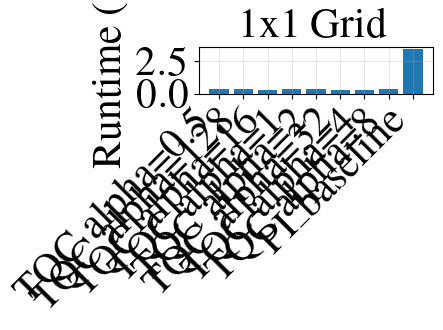


EVALUATION COMPLETE


In [50]:
adaptive_opts = dict(
    h0=5e-3,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,        # p = 1 → nonsmooth first-order scheme, so k = p+1 = 2
    controller="H211b",   # <--- THIS picks the PI digital filter variant to test
    b_param=4.0,         # only if controller == "H211b"
    skip_error_indices=[],
)


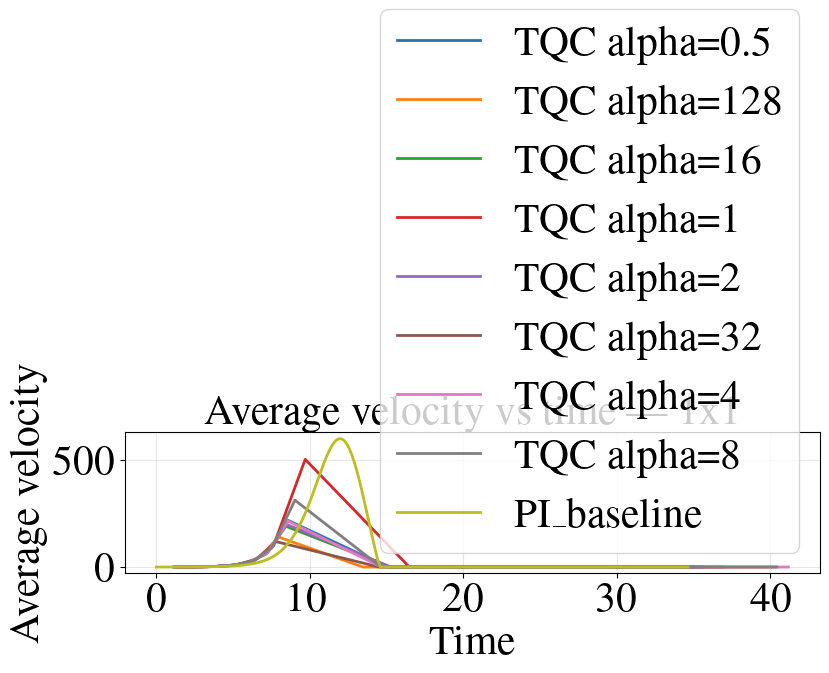

Saved: plots_velocity/velocity_vs_time_1x1.png


In [51]:
# ------------------------------------------------------------
# Plot: Average velocity vs time for each scenario (grid)
# ------------------------------------------------------------
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def plot_velocity_vs_time(all_results, save_dir="plots", scales=None, use_physical_units=False):
    """
    Parameters
    ----------
    all_results : dict
        Output you built, mapping grid_label -> series dict.
        Each series entry must contain "times" and "mean_v".
    save_dir : str or Path
        Directory to save PNGs.
    scales : dict or None
        Optional per-grid scaling:
        {
          "1x1":   {"Tscale": <sec_per_env_unit>, "Vscale": <m_per_env_vel>},
          "25x25": {"Tscale": ..., "Vscale": ...},
          ...
        }
        If None, no scaling is applied.
    use_physical_units : bool
        If True, axis labels use (s) and (m/s).
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    for grid_label, series in all_results.items():
        plt.figure(figsize=(9, 5))
        any_plotted = False

        for name, data in series.items():
            t = np.asarray(data.get("times", []), dtype=float)
            v = np.asarray(data.get("mean_v", []), dtype=float)
            if t.size == 0 or v.size == 0:
                continue

            # Optional scaling to physical units
            if scales and grid_label in scales:
                Tscale = float(scales[grid_label].get("Tscale", 1.0))
                Vscale = float(scales[grid_label].get("Vscale", 1.0))
            else:
                Tscale, Vscale = 1.0, 1.0

            t_plot = t * Tscale
            v_plot = v * Vscale

            plt.plot(t_plot, v_plot, lw=2, label=name)
            any_plotted = True

        if not any_plotted:
            plt.close()
            print(f"[plot_velocity_vs_time] No valid series to plot for '{grid_label}'.")
            continue

        plt.xlabel("Time (s)" if use_physical_units else "Time")
        plt.ylabel("Average velocity (m/s)" if use_physical_units else "Average velocity")
        plt.title(f"Average velocity vs time — {grid_label}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()

        out = save_dir / f"velocity_vs_time_{grid_label}.png"
        plt.savefig(out, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved: {out}")

# --------------------------
# Example usage (after your loop populates `all_results`)
# --------------------------

# If you want raw env units:
plot_velocity_vs_time(all_results, save_dir="plots_velocity", scales=None, use_physical_units=False)

# If you stored/know physical scales per grid, pass them like this:
# scales = {
#   "1x1":   {"Tscale": fault_1x1.Tscale / fault_1x1.second, "Vscale": fault_1x1.Vscale},
#   "25x25": {"Tscale": fault_25.Tscale / fault_25.second,   "Vscale": fault_25.Vscale},
# }
# plot_velocity_vs_time(all_results, save_dir="plots_velocity_phys", scales=scales, use_physical_units=True)


In [ ]:
# # === Multi-grid evaluation helpers (fixed) ===
# # Provides grid-specific rhs, robust obs_fn, and baseline using the grid's projection/force.
# # Use these helpers to evaluate trained RL policies on 10x10, 30x30, etc.

# from pathlib import Path
# import json
# import numpy as np
# import time
# import matplotlib.pyplot as plt
# from Solve_IVP_NS.projections import CoulombProjection
# from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
# from Solve_IVP_NS.integrations import CompositeMethod
# from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
# from plants.faults import strikeslip
# import Solve_IVP_NS


# def build_fault_and_solver(Nz, Nx):
#     """
#     Build a fault and solver stack for a new discretization (Nz, Nx), keeping the same 3x3 size.
#     Returns a dict containing:
#       fault, KS, ES, SIGMA_N, VINF, N_DOFS, A, component_slices, con_force, y0, Uintc, v_max,
#       method_mp, rhs (grid-specific RHS function)
#     """
#     fault_local = strikeslip.qs_strikeslip_fault(
#         zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
#         G=30000., rho=2.5e-3, zeta=0.8/3,
#         Ks_path="./Data/", gamma_s=25., gamma_w=10.,
#         sigma_ref=100., depth_ini=0., vinf=3.171e-10,
#         Dmu_estimate=.5,
#     )
#     MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()

#     N_DOFS_l = fault_local.N
#     I_N = np.eye(N_DOFS_l)
#     Z_N = np.zeros((N_DOFS_l, N_DOFS_l))
#     A_l = np.block([
#         [MA_l, Z_N, Z_N],
#         [Z_N, I_N, Z_N],
#         [Z_N, Z_N, I_N],
#     ])
#     I_N = sp.eye(N_DOFS_l, format='csr')
#     A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

#     component_slices_l = [
#         slice(0, N_DOFS_l),
#         slice(N_DOFS_l, 2 * N_DOFS_l),
#         slice(2 * N_DOFS_l, 3 * N_DOFS_l),
#     ]
#     VINF_l = VINF_raw_l * np.ones(N_DOFS_l)

#     # Grid-specific friction force function using globals DMU, MU_RES, DC
#     def con_force_l(state, fk=None):
#         n = N_DOFS_l
#         slip = state[2*n:3*n]
#         mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip / (DC)))
#         out = np.zeros_like(state)
#         out[:n] = mu_vals * SIGMA_N_l
#         return out

#     # Initial condition and normalization energy Uintc for this grid
#     y0_l = np.zeros(3 * N_DOFS_l)
#     friction_force = con_force_l(y0_l)
#     uc = -np.linalg.solve(KS_l, friction_force[:N_DOFS_l])
#     y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1 + 1e-5)
#     Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

#     # Velocity normalization estimate for this grid
#     res_l = estimate_v_max_range(y0_l, KS_l, ES_l, SIGMA_N_l, MU_RES, DMU, DC, VINF_l)
#     v_max_l = res_l['kb_estimate']

#     # Build solver stack: projection/solver/method (Numba-enabled)
#     projection_l = CoulombProjection(
#         con_force_func=con_force_l,
#         rhok=1.0,
#         component_slices=component_slices_l,
#         constraint_indices=list(range(N_DOFS_l)),
#         use_numba=True,
#     )
#     solver_mp_l = ImplicitEquationSolver(
#         method='VI', proj=projection_l, component_slices=component_slices_l,
#         tol=1e-6, max_iter=100, vi_strict_block_lipschitz=False
#     )
#     method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

#     # Grid-specific RHS using local KS/ES/VINF
#     def rhs_l(t, y):
#         n = N_DOFS_l
#         v = y[:n]
#         u = y[n:2*n]
#         s = y[2*n:3*n]
#         vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
#         udot = v - VINF_l
#         sdot = np.abs(v)
#         return np.concatenate((vdot, udot, sdot))

#     return dict(
#         fault=fault_local, KS=KS_l, ES=ES_l, SIGMA_N=SIGMA_N_l, VINF=VINF_l,
#         N_DOFS=N_DOFS_l, A=A_l, component_slices=component_slices_l,
#         con_force=con_force_l, y0=y0_l, Uintc=Uintc_l, v_max=v_max_l,
#         method_mp=method_mp_l, rhs=rhs_l,
#     )


# def make_obs_reward(alpha_value, KS_l, Uintc_l, v_max_l):
#     """
#     Returns (reward_fn, obs_fn) for the grid using its Uintc and v_max.
#     The obs_fn is robust to None/NaN in solver_perf and converged.
#     """
#     reward_fn = build_reward_fn(alpha_value)

#     def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
#         n = KS_l.shape[0]
#         v = xk[:n]
#         u = xk[n:2*n]
#         ks_u = KS_l @ u
#         E_int = 0.5 * float(np.dot(u, ks_u))
#         E_norm = float(E_int / Uintc_l) if Uintc_l > 0 else 0.0

#         # Reset branch
#         if dt_attempt is None:
#             return np.array([
#                 E_norm,
#                 float(np.mean(v)) / max(v_max_l, 1e-12),
#                 1.005,
#                 0.0,
#                 0.0,
#                 0.5,
#             ], dtype=np.float64)

#         # Safe error extraction from solver_perf[5]
#         err = 0.0
#         if solver_perf is not None and len(solver_perf) > 5 and solver_perf[5] is not None:
#             try:
#                 err_val = float(solver_perf[5])
#                 if np.isfinite(err_val):
#                     err = err_val
#             except Exception:
#                 err = 0.0

#         conv_val = 1.0 if bool(converged) else 0.0

#         if env is not None and getattr(env, 'dt_max', None) is not None and getattr(env, 'dt_min', None) is not None:
#             denom = max(1e-12, env.dt_max - env.dt_min)
#             dt_norm = float((dt_attempt - env.dt_min) / denom)
#         else:
#             dt_norm = 0.0

#         return np.array([
#             E_norm,
#             float(np.mean(v)) / max(v_max_l, 1e-12),
#             (getattr(env, 'iter_error', 0.0) / 4.0) if hasattr(env, 'iter_error') else 0.0,
#             conv_val,
#             float(np.exp(-float(alpha_value) * err)),
#             dt_norm,
#         ], dtype=np.float64)

#     return reward_fn, obs_fn


# def evaluate_policies_for_grid(grid, alpha_dirs, repeats=10, dt_min=None, dt_max=None):
#     """
#     Evaluate trained policies on the provided grid, averaging runtime over `repeats` runs.
#     Returns a series dict like your single-grid evaluation.
#     """
#     fault_l = grid['fault']
#     KS_l = grid['KS']; Uintc_l = grid['Uintc']; v_max_l = grid['v_max']
#     method_mp_l = grid['method_mp']
#     component_slices_l = grid['component_slices']

#     # Time-step bounds (can be tightened for stiffer/finer grids)
#     local_dt_min = dt_min if dt_min is not None else 1e-3 * fault_l.second / fault_l.Tscale
#     local_dt_max = dt_max if dt_max is not None else 30/4 * fault_l.second / fault_l.Tscale

#     series = {}

#     for alpha_dir in alpha_dirs:
#         algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
#         if not algo_dirs:
#             continue
#         for algo_dir in algo_dirs:
#             algo_name = algo_dir.name
#             ModelClass = ALGO_REGISTRY.get(algo_name)
#             if ModelClass is None:
#                 continue
#             meta_path = algo_dir / "metadata.json"
#             mdl_zip = algo_dir / "model.zip"
#             mdl_plain = algo_dir / "model"
#             if not meta_path.exists():
#                 continue
#             meta = json.load(open(meta_path, 'r', encoding='utf-8'))
#             try:
#                 alpha_value = float(meta.get('alpha', 'nan'))
#             except Exception:
#                 continue
#             if not np.isfinite(alpha_value):
#                 continue

#             reward_fn, obs_fn = make_obs_reward(alpha_value, KS_l, Uintc_l, v_max_l)

#             def make_env():
#                 return AdaptiveStepperEnv(
#                     system=grid['rhs'],
#                     dt0=1e-3,
#                     t0=t_span[0], x0=grid['y0'], tnmax=t_span[1],
#                     dt_min=local_dt_min, dt_max=local_dt_max, nparams=(1e-6, 500),
#                     integrator=method_mp_l, component_slices=component_slices_l,
#                     reward_fn=reward_fn, obs_fn=obs_fn, obs_space=obs_space,
#                     verbose=False, alpha=alpha_value,
#                 )

#             mdl_path = str(mdl_zip) if mdl_zip.exists() else str(mdl_plain)
#             if not Path(mdl_path).exists():
#                 continue

#             # Average runtime over repeats, tracking convergence
#             runtimes = []
#             success_runs = []
#             t_store = v_store = u_store = None
#             for i in range(repeats):
#                 env = make_env()
#                 model = ModelClass.load(mdl_path, device='cpu')
#                 t_arr, v_mean, u_mean, wall, success = rollout_policy_on_env(model, env, run_name=f"{algo_name} alpha={alpha_value}")
#                 runtimes.append(float(wall))
#                 success_runs.append(bool(success))
#                 if i == 0:
#                     t_store, v_store, u_store = t_arr, v_mean, u_mean

#             # Only include in series if at least one run converged
#             any_converged = any(success_runs)
#             if any_converged:
#                 key = f"{algo_name} alpha={alpha_value:g}"
#                 series[key] = dict(
#                     times=np.asarray(t_store) if t_store is not None else np.asarray([]),
#                     mean_v=np.asarray(v_store) if v_store is not None else np.asarray([]),
#                     mean_u=np.asarray(u_store) if u_store is not None else np.asarray([]),
#                     runtime_s=float(np.mean(runtimes)) if len(runtimes) else float('nan'),
#                     runtime_std=float(np.std(runtimes)) if len(runtimes) else float('nan'),
#                     converged=True,
#                 )
#             else:
#                 print(f"Skipping {algo_name} alpha={alpha_value}: no runs converged ({sum(success_runs)}/{len(success_runs)})")

#     return series


# def adaptive_baseline_for_grid(grid, use_PI, repeats=10):
#     """
#     Average the adaptive integrator runtime over `repeats` runs on this grid.
#     Uses the grid's con_force and component slices in projection options.
#     Returns a dict like the entries in `series`.
#     Only returns valid results if at least one run converges.
#     """
#     runtimes = []
#     success_runs = []
#     t_store = None
#     y_store = None

#     projection_opts_nb = dict(
#         con_force_func=grid['con_force'],
#         rhok=1.0,
#         component_slices=grid['component_slices'],
#         constraint_indices=list(range(grid['N_DOFS'])),
#         use_numba=True,
#     )
#     local_adapt = dict(adaptive_opts)
#     local_adapt['use_PI'] = bool(use_PI)

#     for i in range(repeats):
#         start_b = time.time()
#         try:
#             (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=grid['rhs'],
#                 t_span=t_span,
#                 y0=grid['y0'],
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts_nb,
#                 solver_opts=solver_opts_ssn,
#                 adaptive=True,
#                 adaptive_opts=local_adapt,
#                 # atol=1e-8,
#                 # rtol=1e-6,
#                 h0=local_adapt.get('h0', 5e-3),
#                 component_slices=grid['component_slices'],
#                 verbose=False,
#                 A=grid['A'],
#             )
#             wall_b = time.time() - start_b
#             # Check if baseline converged (reached end time)
#             success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
#             runtimes.append(float(wall_b))
#             success_runs.append(bool(success))
#             if i == 0:
#                 t_store = t_vals_b
#                 y_store = y_vals_b
#         except Exception as e:
#             print(f"Adaptive baseline run {i+1} failed: {e}")
#             success_runs.append(False)

#     n = grid['N_DOFS']
#     if y_store is not None:
#         v_b = np.mean(y_store[:, :n], axis=1)
#         u_b = np.mean(y_store[:, n:2*n], axis=1)
#     else:
#         v_b = np.asarray([])
#         u_b = np.asarray([])

#     # Only return valid results if at least one run converged
#     any_converged = any(success_runs)
#     if not any_converged:
#         print(f"Warning: Adaptive baseline (PI={use_PI}) did not converge in any of {repeats} runs")
#         return None

#     return dict(
#         times=np.asarray(t_store) if t_store is not None else np.asarray([]),
#         mean_v=np.asarray(v_b),
#         mean_u=np.asarray(u_b),
#         runtime_s=float(np.mean(runtimes)) if len(runtimes) else float('nan'),
#         runtime_std=float(np.std(runtimes)) if len(runtimes) else float('nan'),
#         converged=True,
#         success_rate=f"{sum(success_runs)}/{len(success_runs)}",
#     )


# def plot_runtime_alpha(series, baseline_off, baseline_on, title):
#     """
#     Plot runtime vs log10(alpha) for a given grid, with baselines for PI off/on.
#     RL algorithms are plotted as points only (no lines connecting them).
#     Only converged runs are included in the plot.
#     """
#     from collections import defaultdict
#     runtime_by_algo = defaultdict(list)
#     for name, data in series.items():
#         if 'alpha=' in name:
#             algo = name.split('alpha=')[0].strip()
#             try:
#                 alpha = float(name.split('alpha=')[1])
#             except Exception:
#                 continue
#             # Only include converged runs
#             if data.get('converged', False):
#                 runtime_by_algo[algo].append((alpha, data.get('runtime_s', np.nan)))

#     plt.figure(figsize=(10, 6))
#     for algo_name, pairs in runtime_by_algo.items():
#         if not pairs:
#             continue
#         pairs_sorted = sorted(pairs, key=lambda x: x[0])
#         alphas = [p[0] for p in pairs_sorted]
#         runtimes = [p[1] for p in pairs_sorted]
#         # Plot as points only (no lines) for RL algorithms
#         plt.scatter(np.log10(alphas), runtimes, label=algo_name, s=100, alpha=0.8)

#     if baseline_off and baseline_off is not None and np.isfinite(baseline_off.get('runtime_s', np.nan)):
#         plt.axhline(baseline_off['runtime_s'], color='k', linestyle='--', linewidth=2, label='adaptive baseline (PI off)')
#     if baseline_on and baseline_on is not None and np.isfinite(baseline_on.get('runtime_s', np.nan)):
#         plt.axhline(baseline_on['runtime_s'], color='k', linestyle=':', linewidth=2, label='adaptive baseline (PI on)')

#     plt.xlabel('log10(alpha)')
#     plt.ylabel('Runtime (s)')
#     plt.title(title)
#     plt.grid(True)
#     plt.legend()
#     plt.show()

# # Example usage (uncomment to run):
# specs = [dict(Nz=25, Nx=25, label='25x25'),dict(Nz=50, Nx=50, label='50x50')]
# for spec in specs:
#     print(f"\n=== Evaluating {spec['label']} grid ===")
#     grid = build_fault_and_solver(spec['Nz'], spec['Nx'])
#     series = evaluate_policies_for_grid(grid, alpha_dirs, repeats=5)
#     base_off = adaptive_baseline_for_grid(grid, use_PI=False, repeats=5)
#     base_on  = adaptive_baseline_for_grid(grid, use_PI=True,  repeats=5)
#     plot_runtime_alpha(series, base_off, base_on, title=f"Runtime vs log10(alpha) ({spec['label']}, 3x3 length)")
#     print(f"Converged RL runs: {len([k for k,v in series.items() if v.get('converged', False)])}")
#     if base_off: print(f"Baseline PI=False: converged={base_off.get('success_rate', 'N/A')}")
#     if base_on: print(f"Baseline PI=True: converged={base_on.get('success_rate', 'N/A')}")


In [64]:
import numpy as np
import time
import json
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.sparse as sp

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
import Solve_IVP_NS
from plants.faults import strikeslip
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


ALGO_REGISTRY = {
    "TD3": TD3,
    "TQC": TQC,
}


# ----------------------------------------
# Discover trained alpha directories
# ----------------------------------------
RUN_ROOT = Path("rl_runs").resolve()
alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
if not alpha_dirs:
    raise FileNotFoundError(
        f"No trained runs found under {RUN_ROOT}. "
        "Expected folders like alpha_1p0/TQC, alpha_10p0/TD3, etc."
    )



# -------------------------------------------------------------------------
# ROLLOUT OF A TRAINED RL POLICY ON AN ENVIRONMENT
# -------------------------------------------------------------------------
def rollout_policy_on_env(model, env, run_name="(unnamed)"):
    """
    Roll the given trained RL model on the provided AdaptiveStepperEnv until done/terminated.
    Tracks:
    - physical time steps
    - mean velocity over DOFs
    - mean slip over DOFs
    - wall-clock runtime of the rollout
    - a success flag (reached end without getting stuck)
    - final cumulative slip mean (s_end_mean)

    Returns:
        times          (np.ndarray)
        mean_vel       (np.ndarray)
        mean_slip      (np.ndarray)
        wall_time      (float)
        success        (bool)
        s_end_mean     (float)
    """
    obs, info = env.reset()
    times = []
    mean_vel = []
    mean_slip = []

    last_t = None
    repeat_count = 0
    broke_stuck = False
    last_converged = None
    last_xk = None  # last full state vector so we can read final cumulative slip s

    start = time.time()
    done = False
    term = False

    while not (done or term):
        # Deterministic policy for evaluation
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, term, info = env.step(action)

        # Pull out the current time and state from info
        t_now = info.get("t_k1", np.nan)
        xk = info.get("xk", None)

        # Cache state for final slip measurement
        if xk is not None:
            last_xk = xk

        # Did env tell us if last step converged?
        if isinstance(info, dict) and ("converged" in info):
            last_converged = info.get("converged")

        # Check for repeated time steps (guard against infinite loop)
        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and current_t == last_t: #np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: time stuck at {current_t} for 10 iterations, aborting rollout")
                    broke_stuck = True
                    break
            else:
                repeat_count = 0
            last_t = current_t

        # Record trajectory if we have a valid state
        if xk is not None and current_t is not None:
            n = xk.shape[0] // 3
            v_block = xk[:n]
            u_block = xk[n:2*n]
            times.append(current_t)
            mean_vel.append(float(np.mean(v_block)))
            mean_slip.append(float(np.mean(u_block)))

        if last_t * fault.Tscale/fault.second >= 30.:
            break

    wall_time = time.time() - start
    print(f"[{run_name}] Rollout finished: wall_time={wall_time:.3f}s, steps={len(times)}, final_t={(times[-1] if len(times)>0 else 'NA')}")
    # Determine success:
    # 1. If env told us converged -> trust it
    # 2. Else: if simulation reached ~tnmax without getting stuck, it's a success
    tnmax_val = getattr(env, 'tnmax', None)
    if last_converged is not None:
        success = bool(last_converged)
    else:
        if len(times) > 0 and tnmax_val is not None:
            success = (times[-1] >= 0.999 * float(tnmax_val)) and not broke_stuck
        else:
            success = not broke_stuck

    # Final cumulative slip mean s_end_mean
    if last_xk is not None:
        n = last_xk.shape[0] // 3
        s_block = last_xk[2*n:3*n]
        s_end_mean = float(np.mean(s_block))
        print(f"[{run_name}] Final cumulative slip mean s_end_mean={s_end_mean:.6e}")
    else:
        s_end_mean = np.nan

    return (
        np.asarray(times, dtype=float),
        np.asarray(mean_vel, dtype=float),
        np.asarray(mean_slip, dtype=float),
        float(wall_time),
        bool(success),
        s_end_mean,
    )


# -------------------------------------------------------------------------
# PER-GRID SETUP: BUILD FAULT, SOLVER STACK, RHS, NORMALIZATION CONSTANTS
# -------------------------------------------------------------------------
def build_fault_and_solver(Nz, Nx):
    """
    Build a model and solver stack for a fault discretized with (Nz, Nx).
    Returns a dict describing the grid:
      fault, KS, ES, SIGMA_N, VINF,
      N_DOFS, A, component_slices,
      con_force, y0, Uintc, v_max,
      method_mp, rhs
    """

    # Build the fault object for this spatial resolution
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
        G=30000., rho=2.5e-3, zeta=0.8/3,
        Ks_path="./Data/", gamma_s=25., gamma_w=10.,
        sigma_ref=100., depth_ini=0., vinf=3.171e-10,
        Dmu_estimate=.5,
    )

    # Extract plant matrices/vectors
    MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()

    N_DOFS_l = fault_local.N
    VINF_l = VINF_raw_l * np.ones(N_DOFS_l)

    # Build the block-diagonal mass-like matrix A for implicit solves:
    # blockdiag(MA_l, I, I) matching state [v,u,s]
    I_N = sp.eye(N_DOFS_l, format='csr')
    A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

    # Component slices for [v, u, s]
    component_slices_l = [
        slice(0, N_DOFS_l),
        slice(N_DOFS_l, 2 * N_DOFS_l),
        slice(2 * N_DOFS_l, 3 * N_DOFS_l),
    ]

    # Grid-specific contact/friction force (Coulomb-style law)
    def con_force_l(state, fk=None):
        # state layout: [v, u, s]
        n = N_DOFS_l
        slip_hist = state[2*n:3*n]  # s block encodes "history" / slip measure
        mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / (DC)))
        out = np.zeros_like(state)
        out[:n] = mu_vals * SIGMA_N_l
        return out

    # Initial condition: zero v,u,s except u slightly perturbed from static equilibrium
    y0_l = np.zeros(3 * N_DOFS_l)
    friction_force0 = con_force_l(y0_l)
    uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
    y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)

    # Normalization energy Uintc: ~ internal elastic energy at equilibrium
    Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

    # Velocity-scale estimate, used for normalizing obs
    res_l = estimate_v_max_range(y0_l, KS_l, ES_l, SIGMA_N_l, MU_RES, DMU, DC, VINF_l)
    v_max_l = res_l['kb_estimate']

    # Projection with per-DOF rhok (Numba-accelerated)
    projection_l = CoulombProjection(
        con_force_func=con_force_l,
        rhok=np.ones(N_DOFS_l, dtype=float),
        component_slices=component_slices_l,
        constraint_indices=list(range(N_DOFS_l)),
        use_numba=True,
    )

    # Nonlinear VI solver with solver_opts_ssn defaults
    solver_mp_l = ImplicitEquationSolver(
        method='VI',
        proj=projection_l,
        component_slices=component_slices_l,
        tol=solver_opts_ssn.get('tol', 1e-6),
        max_iter=solver_opts_ssn.get('max_iter', 100),
        vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
        vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
    )

    # Time-stepping method (CompositeMethod)
    method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

    # RHS for this grid
    def rhs_l(t, y):
        # Unpack state
        n = N_DOFS_l
        v = y[:n]
        u = y[n:2*n]
        s = y[2*n:3*n]
        # dynamics
        vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
        udot = v - VINF_l
        sdot = np.abs(v)
        return np.concatenate((vdot, udot, sdot))

    return dict(
        fault=fault_local,
        KS=KS_l,
        ES=ES_l,
        SIGMA_N=SIGMA_N_l,
        VINF=VINF_l,
        N_DOFS=N_DOFS_l,
        A=A_l,
        component_slices=component_slices_l,
        con_force=con_force_l,
        y0=y0_l,
        Uintc=Uintc_l,
        v_max=v_max_l,
        method_mp=method_mp_l,
        rhs=rhs_l,
    )


# -------------------------------------------------------------------------
# OBS/REWARD BUILDERS PER GRID + ALPHA
# -------------------------------------------------------------------------
def make_obs_reward(alpha_value, KS_l, Uintc_l, v_max_l):
    """
    Builds:
      reward_fn = build_reward_fn(alpha_value)  (uses your shaping with alpha)
      obs_fn    = observation builder that matches training layout but uses
                  this grid's KS, Uintc, v_max.
    """
    reward_fn = build_reward_fn(alpha_value)

    def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        """
        Returns observation vector [E_norm, mean(v)/v_max, iter_err/4,
                                   converged_flag, exp(-alpha * error),
                                   dt_norm]
        Works both on reset (dt_attempt is None) and during rollout.
        """
        n = KS_l.shape[0]
        v = xk[:n]
        u = xk[n:2*n]

        # Elastic energy for normalization
        ks_u = KS_l @ u
        E_int = 0.5 * float(np.dot(u, ks_u))
        E_norm = float(E_int / Uintc_l) if Uintc_l > 0 else 0.0
        avg_v = float(np.mean(v))
        # Reset branch (env.reset)
        if dt_attempt is None or solver_perf is None:
            # We still return a valid 6-D observation vector.
            # Fill in placeholders for solver-derived quantities.
            dt_norm_default = 0.5  # neutral midpoint in [0,1]
            conv_flag = 0.0 if converged is None else float(converged)

            return np.array([
                E_norm,                # elastic energy normalized
                avg_v / v_max,         # avg slip rate normalized (v_max provided externally)
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag,             # "converged" flag at reset (0 or None -> 0)
                0.0,                   # exp(-alpha * 0) = 1.0 as a neutral accuracy proxy
                dt_norm_default,       # normalized dt ~ mid
            ], dtype=np.float64)

        # Extract Richardson/global error estimate from solver_perf[5]
        err_val = 0.0
        if solver_perf is not None and len(solver_perf) > 5 and solver_perf[5] is not None:
            try:
                candidate = float(solver_perf[5])
                if np.isfinite(candidate):
                    err_val = candidate
            except Exception:
                err_val = 0.0

        conv_flag = 1.0 if bool(converged) else 0.0

        # Normalize dt_attempt to [0, 1]
        if env is not None and getattr(env, 'dt_max', None) is not None and getattr(env, 'dt_min', None) is not None:
            denom = max(1e-12, env.dt_max - env.dt_min)
            dt_norm = float((dt_attempt - env.dt_min) / denom)
        else:
            dt_norm = 0.0
        if conv_flag:
            acc = 1/(1 + alpha_value * err_val)
        else:
            # print(f"Not converged step detected in obs_fn.")
            acc = 0.0
        return np.array([
                            E_norm,                        # [0]
                            avg_v / v_max,                 # [1]
                            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,  # [2]
                            conv_flag,                     # [3]
                            acc,                           # [4]
                            dt_norm,                       # [5]
                        ], dtype=np.float64)

    return reward_fn, obs_fn


# -------------------------------------------------------------------------
# FIXED SMALL TIME STEP "REFERENCE" SOLUTION
# -------------------------------------------------------------------------
def constant_dt_reference_for_grid(grid, local_dt_min):
    """
    Compute a single high-accuracy reference solution on this grid
    using a fixed small step size dt_ref = local_dt_min / 10.
    adaptive=False, so this is a straight fixed step.

    Returns:
        s_ref_mean (float): final mean cumulative slip over all DOFs
        ref_runtime (float): wall time of this single fixed-step run
        dt_ref (float): the dt_ref used
    """
    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )

    dt_ref = local_dt_min / 10.0  # super conservative time step
    start_t = time.time()
    (t_vals_ref,
     y_vals_ref,
     h_vals_ref,
     fk_vals_ref,
     solver_info_ref) = Solve_IVP_NS.solve_ivp_ns(
        fun=grid['rhs'],
        t_span=t_span,
        y0=grid['y0'],
        method='composite',
        projection='coulomb',
        solver='VI',
        projection_opts=projection_opts_nb,
        solver_opts=solver_opts_ssn,
        adaptive=False,       # FIXED STEP
        adaptive_opts=None,
        # atol=1e-8,
        # rtol=1e-6,
        h0=dt_ref,
        component_slices=grid['component_slices'],
        verbose=False,
        A=grid['A'],
    )
    ref_runtime = time.time() - start_t

    # Get final slip block 's' at final time, average over DOFs
    n = grid['N_DOFS']
    s_final_block = y_vals_ref[-1, 2*n:3*n]
    s_ref_mean = float(np.mean(s_final_block))

    return s_ref_mean, float(ref_runtime), float(dt_ref)


# -------------------------------------------------------------------------
# EVALUATE TRAINED RL POLICIES ON A GIVEN GRID
# -------------------------------------------------------------------------
def evaluate_policies_for_grid(grid, alpha_dirs, repeats, local_dt_min, local_dt_max, s_ref_mean):
    method_mp_l = grid['method_mp']
    component_slices_l = grid['component_slices']
    series = {}

    for alpha_dir in alpha_dirs:
        algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
        if not algo_dirs:
            continue

        for algo_dir in algo_dirs:
            algo_name = algo_dir.name
            ModelClass = ALGO_REGISTRY.get(algo_name)
            if ModelClass is None:
                continue

            meta_path = algo_dir / "metadata.json"
            mdl_zip = algo_dir / "model.zip"
            mdl_plain = algo_dir / "model"
            if not meta_path.exists():
                continue

            with open(meta_path, "r", encoding="utf-8") as fh:
                meta = json.load(fh)

            try:
                alpha_value = float(meta.get('alpha', 'nan'))
            except Exception:
                continue
            if not np.isfinite(alpha_value):
                continue

            mdl_path = mdl_zip if mdl_zip.exists() else mdl_plain
            if not mdl_path.exists():
                continue

            # Per-grid, per-alpha reward/obs
            reward_fn, obs_fn = make_obs_reward(
                alpha_value,
                grid['KS'],
                grid['Uintc'],
                grid['v_max']
            )

            def make_env():
                # Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
                obs_dim = 6
                obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

                return AdaptiveStepperEnv(
                    system=grid['rhs'],
                    dt0=local_dt_min,
                    t0=t_span[0],
                    x0=grid['y0'],
                    tnmax=t_span[1],
                    dt_min=local_dt_min,
                    dt_max=local_dt_max,
                    nparams=(1e-6, 100),
                    integrator=method_mp_l,
                    component_slices=component_slices_l,
                    reward_fn=reward_fn,
                    obs_fn=obs_fn,
                    obs_space=obs_space,
                    verbose=False,
                    # atol=1e-8,
                    # rtol=1e-6,
                    alpha=alpha_value,
                )

            # Load model ONCE for this (algo, alpha)
            model = ModelClass.load(str(mdl_path), device='cpu')

            runtimes = []
            success_runs = []
            slip_end_list = []
            t_store = v_store = u_store = None

            for rep in range(repeats):
                env = make_env()
                t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_env(
                    model,
                    env,
                    run_name=f"{algo_name} alpha={alpha_value}"
                )

                runtimes.append(float(wall))
                success_runs.append(bool(success))
                slip_end_list.append(float(s_end_mean))

                if rep == 0:
                    # keep first trajectory for plotting
                    t_store, v_store, u_store = t_arr, v_mean, u_mean

                # EARLY EXIT LOGIC:
                # If the first rollout already failed (success == False),
                # there's no point doing more repeats because this policy/env
                # pair is deterministic. So bail out immediately.
                if rep == 0 and not success:
                    # no need to try more repeats for this alpha+algo
                    break

            # keep only if we got at least one successful rollout
            if any(success_runs):
                denom = max(abs(s_ref_mean), 1e-12)
                rel_err_runs = [
                    abs(s_i - s_ref_mean) / denom
                    for s_i in slip_end_list
                    if np.isfinite(s_i)
                ]
                rel_err_mean = float(np.mean(rel_err_runs)) if rel_err_runs else float('nan')
                rel_err_std  = float(np.std(rel_err_runs))  if rel_err_runs else float('nan')

                key = f"{algo_name} alpha={alpha_value:g}"
                series[key] = dict(
                    times=np.asarray(t_store) if t_store is not None else np.asarray([]),
                    mean_v=np.asarray(v_store) if v_store is not None else np.asarray([]),
                    mean_u=np.asarray(u_store) if u_store is not None else np.asarray([]),
                    runtime_s=float(np.mean(runtimes)),
                    runtime_std=float(np.std(runtimes)),
                    converged=True,
                    rel_err=rel_err_mean,
                    rel_err_std=rel_err_std,
                )
            else:
                print(f"[{algo_name} alpha={alpha_value}] skipped: no successful rollouts")

    return series


# -------------------------------------------------------------------------
# ADAPTIVE BASELINE WITH YOUR PI CONTROLLER (H211b ETC.)
# -------------------------------------------------------------------------
def adaptive_baseline_for_grid(grid, controller_opts, repeats, s_ref_mean):
    """
    Benchmark the classical adaptive time-stepper with your PI controller.
    controller_opts should include:
        h0, h_min, h_down, h_up,
        method_order,
        controller="H211b",
        b_param=4.0,
        skip_error_indices=[...]
    We'll also force use_PI=True.

    We do 'repeats' runs to average runtime and slip error.
    """

    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )

    # Copy controller options and force PI on
    local_adapt = dict(controller_opts)
    local_adapt["use_PI"] = True

    runtimes_b = []
    success_runs = []
    slip_end_list = []

    t_store = None
    y_store = None
    # plt.plot(grid['y0'])
    for rep in range(repeats):
        start_b = time.time()
        try:
            (t_vals_b,
             y_vals_b,
             h_vals_b,
             fk_vals_b,
             solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
                fun=grid['rhs'],
                t_span=t_span,
                y0=grid['y0'],
                method='composite',
                projection='coulomb',
                solver='VI',
                projection_opts=projection_opts_nb,
                solver_opts=solver_opts_ssn,
                adaptive=True,
                adaptive_opts=local_adapt,    # <-- controller="H211b", etc.
                # atol=1e-8,
                # rtol=1e-6,
                h0=local_adapt.get('h0', 5e-3),
                component_slices=grid['component_slices'],
                verbose=False,
                A=grid['A'],
            )
            wall_b = time.time() - start_b

            # success if we basically hit the final time
            success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
            success_runs.append(bool(success))
            runtimes_b.append(float(wall_b))



            # stash trajectory from first run only
            if rep == 0:
                t_store = t_vals_b
                y_store = y_vals_b

        except Exception as e:
            print(f"Baseline PI run {rep+1} failed: {e}")
            success_runs.append(False)

    if not any(success_runs):
        print("WARNING: PI baseline did not converge in any repeat(s)")
        return None
    # final slip mean
    n = grid['N_DOFS']
    s_final_block = y_vals_b[-1, 2*n:3*n]
    s_end_mean = float(np.mean(s_final_block))
    # Compute relative slip error vs reference
    denom = max(abs(s_ref_mean), 1e-12)
    rel_err_runs = [
        abs(s_i - s_ref_mean) / denom
        for s_i in slip_end_list
        if np.isfinite(s_i)
    ]
    print(f's_i: {slip_end_list}, s_ref_mean: {s_ref_mean}')
    rel_err_mean = float(np.mean(rel_err_runs)) if rel_err_runs else float('nan')
    rel_err_std  = float(np.std(rel_err_runs))  if rel_err_runs else float('nan')

    avg_runtime_b = float(np.mean(runtimes_b))
    std_runtime_b = float(np.std(runtimes_b))

    # Extract velocity/slip traces from first stored run for plotting
    if y_store is not None:
        n = grid['N_DOFS']
        v_b = np.mean(y_store[:, :n], axis=1)
        u_b = np.mean(y_store[:, n:2*n], axis=1)
        t_arr_b = np.asarray(t_store, dtype=float)
    else:
        v_b = np.asarray([], dtype=float)
        u_b = np.asarray([], dtype=float)
        t_arr_b = np.asarray([], dtype=float)

    return dict(
        times=t_arr_b,
        mean_v=np.asarray(v_b),
        mean_u=np.asarray(u_b),
        runtime_s=avg_runtime_b,
        runtime_std=std_runtime_b,
        converged=True,
        rel_err=rel_err_mean,
        rel_err_std=rel_err_std,
    )


def adaptive_baseline_for_grid(grid, controller_opts, repeats, s_ref_mean):
    """
    Run the classical adaptive time-stepper (your PI / digital filter controller)
    as a baseline on this grid.

    controller_opts should include things like:
        h0, h_min, h_down, h_up,
        method_order,
        controller="H211b",
        b_param=4.0,
        skip_error_indices=[...],
        etc.

    We do `repeats` runs to estimate:
        - avg runtime
        - avg relative slip error vs high-accuracy reference
        - traces (t, mean_v, mean_u) from the first run
    """

    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )

    # Copy and enforce PI enabled
    local_adapt = dict(controller_opts)
    local_adapt["use_PI"] = True  # force PI behavior in your AdaptiveStepping

    runtimes_b = []
    success_runs = []
    slip_end_list = []   # <-- this will hold final slip from each successful run

    t_store = None   # we'll save the first successful time vector
    y_store = None   # ...and the corresponding state history

    for rep in range(repeats):
        start_b = time.time()
        try:
            (t_vals_b,
             y_vals_b,
             h_vals_b,
             fk_vals_b,
             solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
                fun=grid['rhs'],
                t_span=t_span,
                y0=grid['y0'],
                method='composite',
                projection='coulomb',
                solver='VI',
                projection_opts=projection_opts_nb,
                solver_opts=solver_opts_ssn,
                adaptive=True,
                adaptive_opts=local_adapt,    # <- controller="H211b", etc.
                # if you actually want tight tolerances, uncomment these:
                # atol=1e-8,
                # rtol=1e-6,
                h0=local_adapt.get('h0', 5e-3),
                component_slices=grid['component_slices'],
                verbose=False,
                A=grid['A'],
            )
            wall_b = time.time() - start_b

            # Did we basically integrate to the final time?
            success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
            success_runs.append(bool(success))
            runtimes_b.append(float(wall_b))

            # Compute final slip mean for THIS run and stash it
            n = grid['N_DOFS']
            s_final_block = y_vals_b[-1, 2*n:3*n]          # take final s block
            s_end_mean = float(np.mean(s_final_block))     # mean slip over DOFs
            slip_end_list.append(s_end_mean)

            # Save the trajectory from the FIRST run only (for plotting later)
            if rep == 0:
                t_store = t_vals_b
                y_store = y_vals_b

        except Exception as e:
            print(f"Baseline PI run {rep+1} failed: {e}")
            success_runs.append(False)
            # we do NOT append a runtime/slip for failed runs

    # If literally no run finished the horizon, declare failure
    if not any(success_runs):
        print("WARNING: PI baseline did not converge in any repeat(s)")
        return None

    # --- Runtime stats over all repeats that ran ---
    avg_runtime_b = float(np.mean(runtimes_b))
    std_runtime_b = float(np.std(runtimes_b))

    # --- Relative slip error vs reference solution ---
    # rel_err = |s_end_mean - s_ref_mean| / |s_ref_mean|
    denom = max(abs(s_ref_mean), 1e-12)
    rel_err_runs = [
        abs(s_i - s_ref_mean) / denom
        for s_i in slip_end_list
        if np.isfinite(s_i)
    ]
    rel_err_mean = float(np.mean(rel_err_runs)) if rel_err_runs else float('nan')
    rel_err_std  = float(np.std(rel_err_runs))  if rel_err_runs else float('nan')

    # --- Extract mean velocity & mean slip vs time from the first stored run ---
    if y_store is not None:
        n = grid['N_DOFS']
        # per-time-step average velocity and displacement over DOFs
        v_b = np.mean(y_store[:, :n], axis=1)
        u_b = np.mean(y_store[:, n:2*n], axis=1)
        t_arr_b = np.asarray(t_store, dtype=float)
    else:
        # shouldn't really happen unless first repeat threw, but be safe
        v_b = np.asarray([], dtype=float)
        u_b = np.asarray([], dtype=float)
        t_arr_b = np.asarray([], dtype=float)

    return dict(
        times=t_arr_b,
        mean_v=np.asarray(v_b),
        mean_u=np.asarray(u_b),
        runtime_s=avg_runtime_b,
        runtime_std=std_runtime_b,
        converged=True,
        rel_err=rel_err_mean,
        rel_err_std=rel_err_std,
    )





TypeError: build_training_env.<locals>.obs_fn() takes 1 positional argument but 6 were given


=== Evaluating grid 25x25 ===
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
coulomb
Reference final slip mean: 2.3776e+03 (dt_ref=1.000e-02), ref_runtime=60.885s
[TD3 alpha=1.0] WARNING: time stuck at 0.0 for 10 iterations, aborting rollout
[TD3 alpha=1.0] Rollout finished: wall_time=0.546s, steps=10, final_t=0.0
[TD3 alpha=1.0] Final cumulative slip mean s_end_mean=0.000000e+00
[TD3 alpha=1.0] skipped: no successful rollouts
[TQC alpha=1.0] WARNING: time stuck at 8.494284709839626 for 10 iterations, aborting rollout
[TQC alpha=1.0] Rollout finished: wall_time=1.862s, steps=16, final_t=8.494284709839626
[TQC alpha=1.0] Final cumulative slip mean s_end_mean=9.502608e+02
[TQC alpha=1.0] skipped: no successful rollouts
coulomb


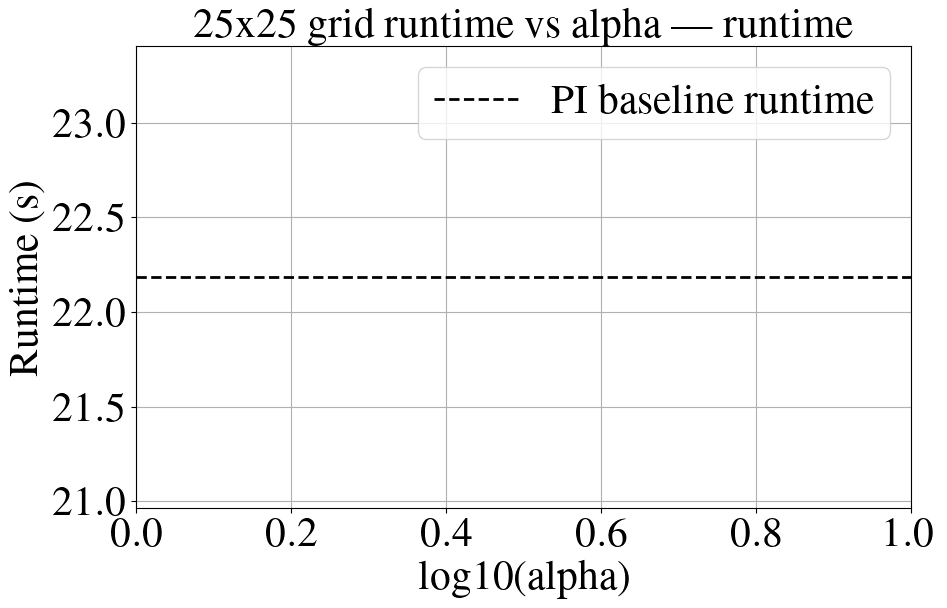

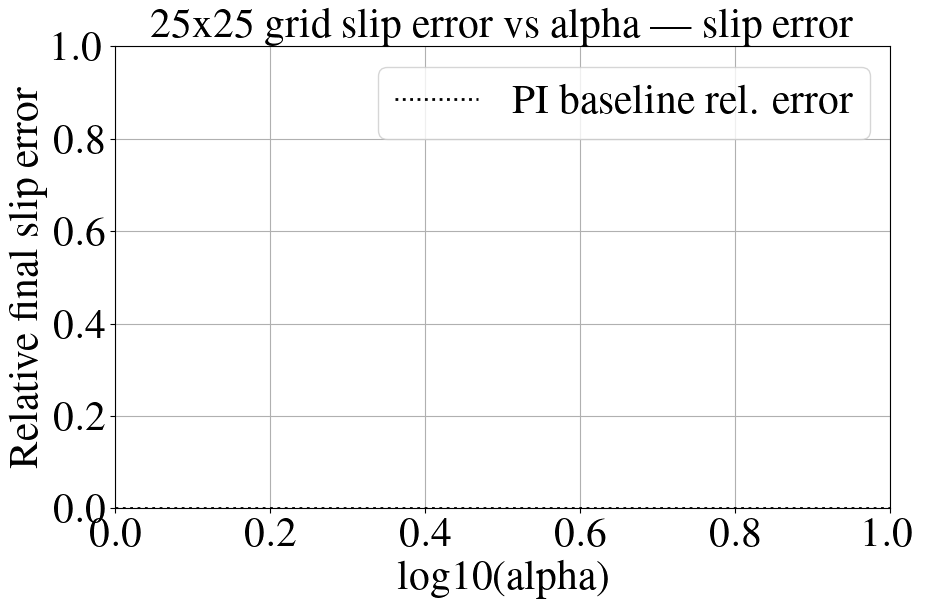

Saved evaluation cache to rl_eval_cache/eval_cache_25x25.json


In [ ]:
# -------------------------------------------------------------------------
# PLOTS: RUNTIME VS ALPHA AND RELATIVE SLIP ERROR VS ALPHA
# -------------------------------------------------------------------------
def plot_runtime_alpha(series, baseline_PI, title):
    """
    Scatter runtime vs log10(alpha) for RL controllers,
    add a horizontal line for the PI baseline runtime.
    """
    from collections import defaultdict
    runtime_by_algo = defaultdict(list)

    # Collect runtime for each algo at each alpha
    for name, data in series.items():
        if "alpha=" not in name:
            continue
        algo_name = name.split("alpha=")[0].strip()
        try:
            alpha_val = float(name.split("alpha=")[1])
        except Exception:
            continue
        if data.get("converged", False):
            runtime_by_algo[algo_name].append((alpha_val, data.get("runtime_s", np.nan)))

    # Plot scatter for each algorithm
    plt.figure(figsize=(10, 6))
    for algo_name, pairs in runtime_by_algo.items():
        # filter bad/zero alphas
        filtered = [(a, r) for (a, r) in pairs if a > 0 and np.isfinite(r)]
        if not filtered:
            continue
        filtered.sort(key=lambda x: x[0])
        alphas = [a for (a, r) in filtered]
        runtimes = [r for (a, r) in filtered]
        plt.scatter(alphas, runtimes, label=algo_name, s=100, alpha=0.8)

    # Baseline horizontal line
    if baseline_PI and np.isfinite(baseline_PI.get("runtime_s", np.nan)):
        plt.axhline(
            baseline_PI["runtime_s"],
            color='k',
            linestyle='--',
            linewidth=2,
            label='PI baseline runtime'
        )

    plt.xlabel("log10(alpha)")
    plt.ylabel("Runtime (s)")
    plt.title(title + " — runtime")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_error_alpha(series, baseline_PI, title):
    """
    Scatter relative slip error vs log10(alpha) for RL controllers,
    add a horizontal line for the PI baseline relative slip error.
    rel_err = |s_end - s_ref| / |s_ref|
    """
    from collections import defaultdict
    err_by_algo = defaultdict(list)

    # Collect error for each algo at each alpha
    for name, data in series.items():
        if "alpha=" not in name:
            continue
        algo_name = name.split("alpha=")[0].strip()
        try:
            alpha_val = float(name.split("alpha=")[1])
        except Exception:
            continue
        if data.get("converged", False):
            rel_err_val = data.get("rel_err", np.nan)
            if np.isfinite(rel_err_val):
                err_by_algo[algo_name].append((alpha_val, rel_err_val))

    # Plot scatter for each algorithm
    plt.figure(figsize=(10, 6))
    for algo_name, pairs in err_by_algo.items():
        filtered = [(a, e) for (a, e) in pairs if a > 0 and np.isfinite(e)]
        if not filtered:
            continue
        filtered.sort(key=lambda x: x[0])
        alphas = [a for (a, e) in filtered]
        errs = [e for (a, e) in filtered]
        plt.scatter(alphas, errs, label=algo_name, s=100, alpha=0.8)

    # Baseline horizontal line
    if baseline_PI and np.isfinite(baseline_PI.get("rel_err", np.nan)):
        plt.axhline(
            baseline_PI["rel_err"],
            color='k',
            linestyle=':',
            linewidth=2,
            label='PI baseline rel. error'
        )

    plt.xlabel("log10(alpha)")
    plt.ylabel("Relative final slip error")
    plt.title(title + " — slip error")
    plt.grid(True)
    plt.legend()
    plt.show()


# -------------------------------------------------------------------------
# JSON CACHE HELPER
# -------------------------------------------------------------------------
def _to_jsonable(obj):
    """
    Convert numpy arrays, numpy scalars, etc. into basic Python (lists, floats)
    so we can json.dump them without errors.
    """
    if isinstance(obj, dict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [_to_jsonable(v) for v in obj]
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer)):
        return float(obj)
    return obj


# -------------------------------------------------------------------------
# MAIN DRIVER EXAMPLE
# -------------------------------------------------------------------------
# Controller options for the adaptive PI baseline.
# This matches "H211b" with b_param=4.0, method_order=1, etc.
controller_opts_pi = dict(
    h0=5e-3,
    h_min=1e-12,
    h_down=0.6,
    h_up=2.0,
    method_order=1,         # p = 1 ⇒ nonsmooth first-order scheme ⇒ k = p+1 = 2
    controller="H211b",     # selects PI filter variant
    b_param=4.0,            # tuning param for H211b
    skip_error_indices=[],
)

CACHE_ROOT = Path("rl_eval_cache")
CACHE_ROOT.mkdir(parents=True, exist_ok=True)

# Example grids to evaluate
specs = [
    dict(Nz=25, Nx=25, label='25x25'),
    # dict(Nz=50, Nx=50, label='50x50'),
]

for spec in specs:
    print(f"\n=== Evaluating grid {spec['label']} ===")
    grid = build_fault_and_solver(spec['Nz'], spec['Nx'])

    # Grid-dependent dt bounds, consistent with how you trained/picked dt range
    local_dt_min = 1e-3 #* grid['fault'].second / grid['fault'].Tscale
    local_dt_max = (30/10) * grid['fault'].second / grid['fault'].Tscale

    # (1) High-accuracy fixed small step "reference" solve
    s_ref_mean, ref_runtime, dt_ref = constant_dt_reference_for_grid(
        grid,
        local_dt_min=local_dt_min*100,
    )
    print(f"Reference final slip mean: {s_ref_mean:.4e} (dt_ref={dt_ref:.3e}), ref_runtime={ref_runtime:.3f}s")

    # (2) Evaluate all trained RL policies on this grid
    series = evaluate_policies_for_grid(
        grid=grid,
        alpha_dirs=alpha_dirs,
        repeats=1,
        local_dt_min=local_dt_min,
        local_dt_max=local_dt_max,
        s_ref_mean=s_ref_mean,
    )

    # (3) Evaluate adaptive PI baseline (H211b, etc.)
    baseline_PI = adaptive_baseline_for_grid(
        grid=grid,
        controller_opts=controller_opts_pi,
        repeats=1,
        s_ref_mean=s_ref_mean,
    )

    # (4) Plot runtime vs alpha and slip error vs alpha
    plot_runtime_alpha(
        series,
        baseline_PI,
        title=f"{spec['label']} grid runtime vs alpha"
    )
    plot_error_alpha(
        series,
        baseline_PI,
        title=f"{spec['label']} grid slip error vs alpha"
    )

    # (5) Save cache so we can reload results later without re-simulating
    cache_payload = dict(
        grid_label=spec['label'],
        dt_ref=dt_ref,
        s_ref_mean=s_ref_mean,
        ref_runtime=ref_runtime,
        series=series,
        baseline_PI=baseline_PI,
    )
    cache_json = _to_jsonable(cache_payload)
    cache_path = CACHE_ROOT / f"eval_cache_{spec['label']}.json"
    with open(cache_path, "w", encoding="utf-8") as fh:
        json.dump(cache_json, fh, indent=2)

    print(f"Saved evaluation cache to {cache_path}")


In [ ]:

# (3) Evaluate adaptive PI baseline (H211b, etc.)
baseline_PI = adaptive_baseline_for_grid(
    grid=grid,
    controller_opts=controller_opts_pi,
    repeats=1,
    s_ref_mean=s_ref_mean,
)

coulomb


/tmp/ipykernel_6918/4177329664.py:191: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / (DC)))


In [ ]:
import numpy as np

# ---------- small helpers ----------
def _as_vec(x, n):
    if np.isscalar(x):
        return np.full(n, float(x))
    x = np.asarray(x, dtype=float)
    if x.shape != (n,):
        raise ValueError(f"Expected vector of length {n}, got {x.shape}")
    return x

def _sym(A):  # numerical symmetrization
    return 0.5 * (A + A.T)

def _lam_min_spd(M):
    w = np.linalg.eigvalsh(_sym(M))
    if w[0] <= 0:
        raise ValueError("Mass matrix M must be SPD.")
    return float(w[0])

def _first_omega(K, M=None, tol=1e-12):
    K = _sym(K)
    if M is None:
        w = np.linalg.eigvalsh(K)
    else:
        # generalized symmetric eigenproblem via Cholesky of M
        L = np.linalg.cholesky(_sym(M))
        Linv = np.linalg.solve(L, np.eye(L.shape[0]))
        A = Linv.T @ K @ Linv
        w = np.linalg.eigvalsh(_sym(A))
    pos = w[w > tol]
    if pos.size == 0:
        raise ValueError("No positive eigenvalues found for stiffness block.")
    return float(np.sqrt(pos[0]))

# ---------- main estimators ----------
def estimate_v_max_range(
    y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF, M=None,
    patch_indices=None, alpha_values=(1.0, 1.0, 2.0, 2.0)
):
    """
    Returns several max-velocity estimates without time integration.
    Works with vector SIGMA_N and optional mass matrix M.
    """
    SIGMA_N = np.atleast_1d(SIGMA_N).astype(float)
    n = SIGMA_N.size
    v0 = y0[:n]
    u0 = y0[n:2*n]
    s0 = y0[2*n:3*n] if y0.size >= 3*n else np.zeros(n)

    VINF_vec = _as_vec(VINF, n)
    M_eff = None if M is None else _sym(M)

    # weakening amount from your law: mu(0)=MU_RES - DMU  =>  Δμ = -DMU (clamped ≥0)
    dmu = max(0.0, -float(DMU))

    # ---------------- 1) Rigorous energy bound ----------------
    w0 = v0 - VINF_vec
    if M_eff is None:
        T0 = 0.5 * (w0 @ w0)
        lam_min_M = 1.0
    else:
        T0 = 0.5 * (w0 @ (M_eff @ w0))
        lam_min_M = _lam_min_spd(M_eff)
    U0 = 0.5 * (u0 @ (KS @ u0))
    E0 = T0 + U0
    w_max = np.sqrt(max(0.0, 2.0 * E0 / lam_min_M))
    v_rigorous = float(np.linalg.norm(VINF_vec) + w_max)

    # ---------------- 2) KB-style estimate (matrix-tailored) ----------------
    alpha2, alpha3, alpha4, alpha5 = alpha_values  # alpha2 unused here by design
    P = np.arange(n, dtype=int) if patch_indices is None else np.asarray(patch_indices, dtype=int)
    KPP = KS[np.ix_(P, P)]
    MPP = None if M_eff is None else M_eff[np.ix_(P, P)]
    omega1 = _first_omega(KPP, M=MPP)

    ones = np.ones(P.size)
    k_bar = float((ones @ (KPP @ ones)) / (ones @ ones))  # uniform-slip equivalent spring
    delta_tau_avg = float(np.mean(dmu * SIGMA_N[P]))

    v_kb = (alpha3 * alpha5 / (alpha4 * np.pi)) * (delta_tau_avg / k_bar) * omega1
    v_kb = float(np.linalg.norm(VINF_vec) + v_kb)

    # ---------------- 3) Damping-based heuristic ----------------
    diag_ES = np.diag(ES).astype(float)
    pos = diag_ES > 0
    if np.any(pos):
        v_damping = float(np.linalg.norm(VINF_vec) + np.max((dmu * SIGMA_N[pos]) / diag_ES[pos]))
    else:
        v_damping = float(np.inf)  # no viscous ceiling

    # ---------------- 4) Energy + weakening work (heuristic retention) ----------------
    # Total weakening work = sum_i Δμ σ_n,i D_c  (independent of s0 for this law)
    total_weaken_work = float(np.sum(dmu * SIGMA_N * DC))
    E_total = E0 + total_weaken_work

    # crude retention using average modal damping
    k_mean_diag = np.mean(np.diag(KS)[np.diag(KS) > 0]) if np.any(np.diag(KS) > 0) else 0.0
    c_mean_diag = np.mean(diag_ES[pos]) if np.any(pos) else 0.0
    if k_mean_diag > 0 and c_mean_diag > 0:
        omega_n = np.sqrt(k_mean_diag) if M_eff is None else np.sqrt(k_mean_diag / (np.trace(M_eff)/n))
        zeta = c_mean_diag / (2.0 * omega_n)  # M=I scaling
        retention = (0.5 / zeta) if zeta >= 1 else np.exp(-np.pi * zeta / np.sqrt(max(1e-12, 1 - zeta**2)))
    else:
        retention = 1.0
    E_eff = max(0.0, E_total * retention)
    w_max_eff = np.sqrt(2.0 * E_eff / lam_min_M)
    v_energy_fric = float(np.linalg.norm(VINF_vec) + w_max_eff)

    # ---------------- 5) Heterogeneity (local viscous cap) ----------------
    idx = int(np.argmax(dmu * SIGMA_N))
    c_local = ES[idx, idx]
    if c_local > 0:
        v_hetero = float(np.linalg.norm(VINF_vec) + (dmu * SIGMA_N[idx]) / c_local)
    else:
        v_hetero = float(np.inf)

    # pick a “best guess” (finite & smallest), ensure range ordered
    finite = [x for x in [v_kb, v_damping, v_energy_fric, v_hetero] if np.isfinite(x)]
    v_best = min(finite) if finite else v_rigorous
    v_low, v_high = min(0.8 * v_best, v_rigorous), max(v_best, v_rigorous)

    return {
        "rigorous_upper_bound": v_rigorous,
        "kb_estimate": v_kb if np.isfinite(v_kb) else None,
        "damping_estimate": v_damping,
        "energy_with_friction": v_energy_fric,
        "heterogeneous_estimate": v_hetero if np.isfinite(v_hetero) else None,
        "best_estimate": v_best,
        "range": (v_low, v_high),
        "stress_drop_max": float(np.max(dmu * SIGMA_N)),
        "stress_drop_mean": float(np.mean(dmu * SIGMA_N)),
        "kbar": k_bar,
        "omega1": omega1,
        "patch_size": int(P.size),
    }

def print_velocity_estimates(results, label="Velocity Estimates"):
    print(f"\n{label}")
    print("-" * 50)
    print(f"Rigorous Upper Bound:     {results['rigorous_upper_bound']:.6e}")
    if results['kb_estimate'] is not None:
        print(f"KB-style Estimate:        {results['kb_estimate']:.6e}")
    print(f"Damping-based Estimate:   {results['damping_estimate']:.6e}")
    print(f"Energy + Friction Bound:  {results['energy_with_friction']:.6e}")
    if results['heterogeneous_estimate'] is not None:
        print(f"Heterogeneous Estimate:   {results['heterogeneous_estimate']:.6e}")
    print(f"Best Estimate:            {results['best_estimate']:.6e}")
    lo, hi = results['range']
    print(f"Practical Range:          [{lo:.6e}, {hi:.6e}]")
    print(f"Patch size:               {results['patch_size']}")
    print(f"k̄ (uniform-slip):        {results['kbar']:.6e}")
    print(f"ω₁ (rad/your time unit): {results['omega1']:.6e}")
    print(f"Max/Mean Δτ:              {results['stress_drop_max']:.6e} / {results['stress_drop_mean']:.6e}")
# Compute estimates
results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
print_velocity_estimates(results, "Fault Model Velocity Estimates")

In [ ]:
# import numpy as np
# import time
# import matplotlib.pyplot as plt  # NEW
# import Solve_IVP_NS

# # Assumes you already have:
# # - rhs
# # - t_span
# # - y0
# # - projection_opts (or projection_opts_nb)
# # - solver_opts_ssn
# # - adaptive_opts
# # - component_slices
# # - A
# # - N_DOFS (or can be inferred from y0)
# #
# # and that Solve_IVP_NS.solve_ivp_ns(...) returns (t_vals, y_vals, h_vals, fk_vals, solver_info)
# # where y_vals has shape (num_steps, 3 * N_DOFS)
# #
# # We also assume each controller in controller_types only differs by the "controller" name
# # and maybe b_param, etc., which is already how you're doing it.


# # controllers we actually implemented in AdaptiveStepping._filter_coeffs()
# controller_types = [
#     {"name": "elementary",
#      "opts": dict(adaptive_opts, controller="elementary")},
#     {"name": "PI3040",
#      "opts": dict(adaptive_opts, controller="PI3040")},
#     {"name": "PI3333",
#      "opts": dict(adaptive_opts, controller="PI3333")},
#     {"name": "PI4020",
#      "opts": dict(adaptive_opts, controller="PI4020")},
#     {"name": "H211PI",
#      "opts": dict(adaptive_opts, controller="H211PI")},
#     {"name": "H211b_b2.0",
#      "opts": dict(adaptive_opts, controller="H211b", b_param=2.0)},
#     {"name": "H211b_b4.0",
#      "opts": dict(adaptive_opts, controller="H211b", b_param=4.0)},
#     {"name": "H211b_b6.0",
#      "opts": dict(adaptive_opts, controller="H211b", b_param=6.0)},
# ]

# results = []

# for ctrl in controller_types:
#     runtimes = []
#     run_timeseries = []  # we'll store (t_vals, v_mean) for each successful run
#     print(f"\nTesting controller: {ctrl['name']}")

#     for i in range(5):
#         opts = dict(ctrl["opts"])  # shallow copy so we can mutate per run if needed
#         start = time.time()
#         try:
#             (t_vals,
#              y_vals,
#              h_vals,
#              fk_vals,
#              solver_info) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=rhs,
#                 t_span=t_span,
#                 y0=y0,
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts,      # or projection_opts_nb for numba
#                 solver_opts=solver_opts_ssn,
#                 adaptive=True,
#                 adaptive_opts=opts,
#                 # atol=1e-8,
#                 # rtol=1e-6,
#                 h0=30/20 * fault.second / fault.Tscale,
#                 component_slices=component_slices,
#                 verbose=True,
#                 A=A,
#             )
#             wall = time.time() - start
#             print(f"  Run {i+1}: {wall:.3f} s")
#             runtimes.append(wall)

#             # --- NEW: compute avg velocity over DOFs for this run ---
#             # y_vals shape: (num_steps, 3*N_DOFS) with layout [v(0:n), u(n:2n), s(2n:3n)]
#             n = y_vals.shape[1] // 3  # infer N_DOFS in case N_DOFS isn't global
#             v_block = y_vals[:, :n]   # velocity block over time
#             v_mean = np.mean(v_block, axis=1)  # mean velocity across DOFs at each time step

#             run_timeseries.append({
#                 "run_idx": i,
#                 "t": np.asarray(t_vals, dtype=float),
#                 "v_mean": np.asarray(v_mean, dtype=float),
#             })

#         except Exception as e:
#             print(f"  Run {i+1} failed: {e}")
#             runtimes.append(float('nan'))
#             # don't append to run_timeseries if it failed

#     # After finishing all runs for THIS controller:
#     # make a plot of average velocity vs time for each successful run
#     if run_timeseries:
#         plt.figure(figsize=(10, 6))
#         for ts in run_timeseries:
#             plt.plot(ts["t"], ts["v_mean"], label=f'run {ts["run_idx"]+1}')
#         plt.xlabel("time")
#         plt.ylabel("mean velocity across DOFs")
#         plt.title(f"Controller {ctrl['name']}: mean velocity vs time")
#         plt.grid(True)
#         plt.legend()
#         plt.show()

#     # timing stats for this controller
#     avg_runtime = np.nanmean(runtimes)
#     std_runtime = np.nanstd(runtimes)
#     results.append({
#         "controller": ctrl["name"],
#         "avg_runtime": avg_runtime,
#         "std_runtime": std_runtime
#     })

# print("\nController timing summary (average over 5 runs):")
# for res in results:
#     print(f"- {res['controller']}: {res['avg_runtime']:.3f} s ± {res['std_runtime']:.3f} s")

# valid_results = [r for r in results if np.isfinite(r["avg_runtime"])]
# if valid_results:
#     fastest = min(valid_results, key=lambda r: r["avg_runtime"])
#     print(f"\nFastest controller: {fastest['controller']} ({fastest['avg_runtime']:.3f} s)")
# else:
#     print("\nNo controller produced a valid runtime.")


In [ ]:
# # controllers we actually implemented in AdaptiveStepping._filter_coeffs()
# controller_types = [
#     {"name": "elementary",
#      "opts": dict(adaptive_opts, controller="elementary")},
#     {"name": "PI3040",
#      "opts": dict(adaptive_opts, controller="PI3040")},
#     {"name": "PI3333",
#      "opts": dict(adaptive_opts, controller="PI3333")},
#     {"name": "PI4020",
#      "opts": dict(adaptive_opts, controller="PI4020")},
#     {"name": "H211PI",
#      "opts": dict(adaptive_opts, controller="H211PI")},
#     {"name": "H211b_b2.0",
#      "opts": dict(adaptive_opts, controller="H211b", b_param=2.0)},
#     {"name": "H211b_b4.0",
#      "opts": dict(adaptive_opts, controller="H211b", b_param=4.0)},
# ]

# results = []

# for ctrl in controller_types:
#     runtimes = []
#     print(f"\nTesting controller: {ctrl['name']}")
#     for i in range(5):
#         opts = dict(ctrl["opts"])  # shallow copy so we can mutate per run if needed
#         start = time.time()
#         try:
#             (t_vals, y_vals, h_vals, fk_vals, solver_info) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=rhs,
#                 t_span=t_span,
#                 y0=y0,
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts,      # or projection_opts_nb for numba
#                 solver_opts=solver_opts_ssn,
#                 adaptive=True,
#                 adaptive_opts=opts,
#                 atol=1e-6,
#                 rtol=1e-3,
#                 h0=opts.get('h0', 5e-3),
#                 component_slices=component_slices,
#                 verbose=False,
#                 A=A,
#             )
#             wall = time.time() - start
#             print(f"  Run {i+1}: {wall:.3f} s")
#             runtimes.append(wall)
#         except Exception as e:
#             print(f"  Run {i+1} failed: {e}")
#             runtimes.append(float('nan'))

#     avg_runtime = np.nanmean(runtimes)
#     std_runtime = np.nanstd(runtimes)
#     results.append({
#         "controller": ctrl["name"],
#         "avg_runtime": avg_runtime,
#         "std_runtime": std_runtime
#     })

# print("\nController timing summary (average over 5 runs):")
# for res in results:
#     print(f"- {res['controller']}: {res['avg_runtime']:.3f} s ± {res['std_runtime']:.3f} s")

# valid_results = [r for r in results if np.isfinite(r["avg_runtime"])]
# if valid_results:
#     fastest = min(valid_results, key=lambda r: r["avg_runtime"])
#     print(f"\nFastest controller: {fastest['controller']} ({fastest['avg_runtime']:.3f} s)")
# else:
#     print("\nNo controller produced a valid runtime.")
